In [1]:
import tensorflow as tf
import datetime, os
#hide tf logs 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'} 
#0 (default) shows all, 1 to filter out INFO logs, 2 to additionally filter out WARNING logs, and 3 to additionally filter out ERROR logs
import scipy.optimize
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import seaborn as sns 
import codecs, json
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 

# generates same random numbers each time
np.random.seed(1234)
tf.random.set_seed(1234)

print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.9.1


# *Data Prep*

Training and Testing data is prepared from the solution file

In [2]:
## Data Import
K_real = np.load('./K_tx_real_d_one.npy') # Values of K(t,x)
Q_real = np.load('./Q_15minutes.npy') # Input Matrix of Model
f_real = Q_real[:,1] # Inflow Rate
v_real = Q_real[:,3] # Average Speed
pi_real = np.load('./pitilde_15minutes.npy') # Values of pi(t,x)

In [3]:
pi_real.shape

(150, 2016)

Text(0, 0.5, 'Remaining Trip Distance (miles)')

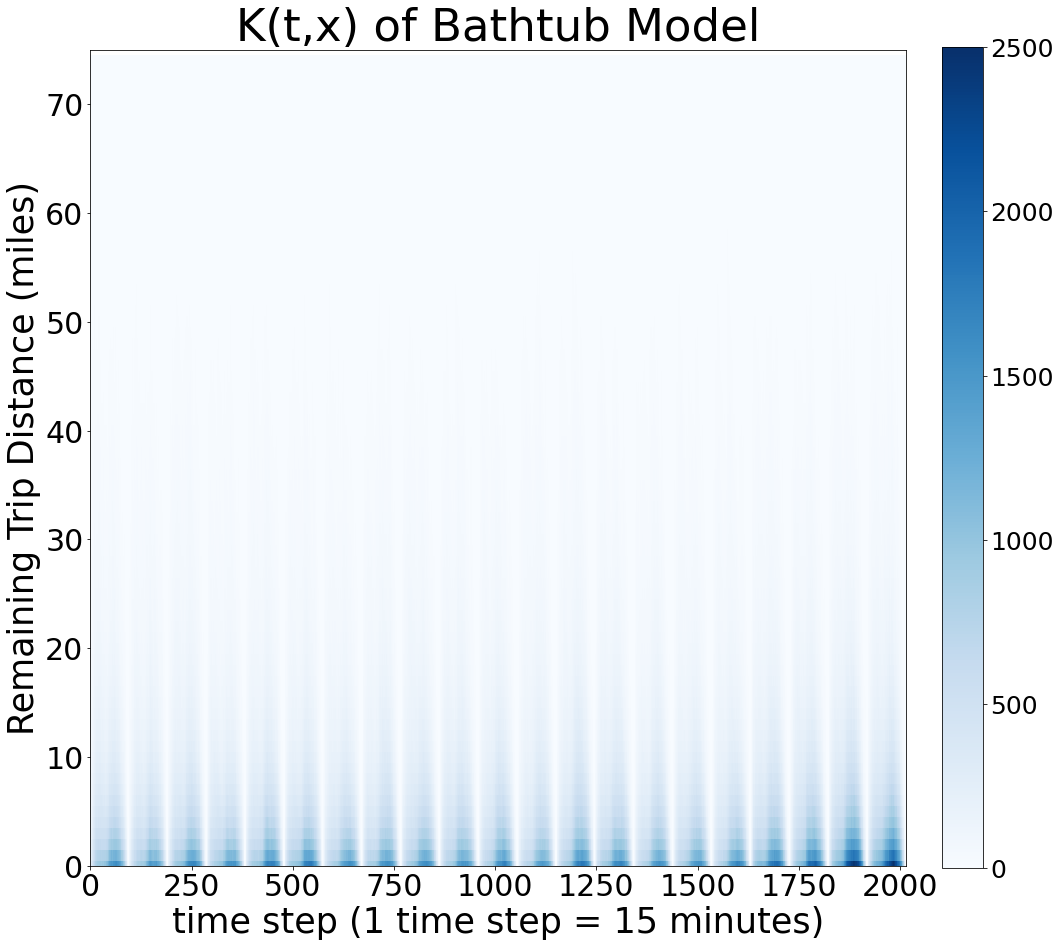

In [4]:
K_array = np.array(K_real[:,0:len(K_real[0])])
fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.T, cmap = 'Blues', interpolation='nearest')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,len(K_real[0])])
plt.clim(0, 2500) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title('K(t,x) of Bathtub Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (miles)', fontsize=35)

In [5]:
## Scale
N_timestep = 24*21*4 # 24 hours * 21 days * 15 minutes = total timestep
N_diststep = 75 # 1 distance step = 1 mile
Size_diststep = 1 # unit: miles
N_trainingdays = 0 # Set zero (0)
N_training = 24*4*N_trainingdays # Training data is all


## Normalization [0,1]
x = np.arange(0,int(N_diststep/Size_diststep))[:,None]   # x: step of remaining distance
t = np.arange(0,N_timestep)[:,None]    # Time step 
usol = K_real.transpose() [:,N_training:]     # real value of K(t,x) ==> Target Variable
usol_max = usol.max()

## Normalization [0,1]
x = (x - x.min()) / (x.max() - x.min())
t = (t - t.min()) / (t.max() - t.min())
f_real = (f_real - usol.min()) / (usol.max() - usol.min())  # usol과 같은 dimension이어야 함. 단위 같기 때문.
v_real = (v_real - v_real.min()) / (v_real.max() - v_real.min())
usol = (usol - usol.min()) / (usol.max()-usol.min())

X, T = np.meshgrid(x,t)                     # makes 2 arrays X and T such that u(X[i],T[j])=usol[i][j] are a tuple


multiplier_dist = int(N_diststep/Size_diststep)-1
multiplier_time = N_timestep-1
multiplier_u = usol_max
print('multiplier distance = ', multiplier_dist)
print('multiplier time = ', multiplier_time)
print('usol max = ', usol_max)

multiplier distance =  74
multiplier time =  2015
usol max =  2500


In [6]:
Size_diststep = 5 # unit: miles
Size_timestep = 2 # 2: 30min, 3: 60min
size_input = int(N_diststep/Size_diststep)*int(N_timestep/Size_timestep) # Total number of grid points
# size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
N_u = int(size_input*0.2) # Total number of data points for 'u' ==> Training data from grid points
N_f = N_u*2 #Total number of collocation (auxiliary) points 
alpha = 0.5 # weights of loss

print('size input = ', size_input)
print('N_u = ', N_u)
print('N_f = ', N_f)

size input =  15120
N_u =  3024
N_f =  6048


In [7]:
# # Previous version (before Aug 30)
# size_input = int(N_diststep/Size_diststep)*N_timestep # All domain
# # size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
# N_u = int(size_input*0.5) #Total number of data points for 'u'
# N_f = N_u*2 #Total number of collocation points 
# alpha = 0.5

# print('size input = ', size_input)
# print('N_u = ', N_u)
# print('N_f = ', N_f)

# *Grid Data*

We prepare the grid data to compare against the solution produced by the PINN.

In [8]:
''' X_u_test = [X[i],T[i]] [25600,2] for interpolation'''
X_u_grid = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

# Domain bounds
lb = X_u_grid[0]  # [-1. 0.]
ub = X_u_grid[-1] # [1.  0.99]

'''
   Fortran Style ('F') flatten,stacked column wise!
   u = [c1 
        c2
        .
        .
        cn]

   u =  [25600x1] 
'''
u_grid = usol.flatten('F')[:,None] 

# *Training Data* (All domain)


The boundary conditions serve as the test data for the PINN and the collocation points are generated using **Latin Hypercube Sampling**

In [9]:
def trainingdata(N_u,N_f):

#     '''Boundary Conditions'''

#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 0  
#     leftedge_x = np.hstack((X[0,:][:,None], T[0,:][:,None])) #L1
#     leftedge_u = usol[:,0][:,None]
    
#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 2015  
#     rightedge_x = np.hstack((X[0,:][:,None], T[-1,:][:,None])) #L1
#     rightedge_u = usol[:,-1][:,None]

#     #Boundary Condition x = 9 (135 miles) and 0 =< t =<2015
#     topedge_x = np.hstack((X[:,-1][:,None], T[:,0][:,None])) #L3
#     topedge_u = usol[-1,:][:,None]
        
#     #Boundary Condition x = 0 and 0 =< t =<2015
#     bottomedge_x = np.hstack((X[:,0][:,None], T[:,0][:,None])) #L2
#     bottomedge_u = usol[0,:][:,None]
    
#     #Boundary Condition x = 5 (25 miles) and 0 =< t =<2015
#     midedge_x = np.hstack((X[:,5][:,None], T[:,0][:,None])) #L3
#     midedge_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 10 (50 miles) and 0 =< t =<2015
#     midedge1_x = np.hstack((X[:,10][:,None], T[:,0][:,None])) #L3
#     midedge1_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 15 (75 miles) and 0 =< t =<2015
#     midedge2_x = np.hstack((X[:,15][:,None], T[:,0][:,None])) #L3
#     midedge2_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 20 (100 miles) and 0 =< t =<2015
#     midedge3_x = np.hstack((X[:,20][:,None], T[:,0][:,None])) #L3
#     midedge3_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 25 (125 miles) and 0 =< t =<2015
#     midedge4_x = np.hstack((X[:,25][:,None], T[:,0][:,None])) #L3
#     midedge4_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 2 and 0 =< t =<2015
#     bottomedge_x_2 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_2 = usol[2,:][:,None]
    
#     #Boundary Condition x = 1 and 0 =< t =<2015
#     bottomedge_x_1 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_1 = usol[1,:][:,None]


#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x, midedge1_x, midedge2_x, midedge3_x, midedge4_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u, midedge1_u, midedge2_u, midedge3_u, midedge4_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([bottomedge_x, bottomedge_x_1, bottomedge_x_2]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, bottomedge_u_1, bottomedge_u_2])   #corresponding u [4042,]
    
#     all_X_u_train = np.vstack([bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, topedge_u])   #corresponding u [4042,]

    all_X_u_train = np.hstack((X.T[range(0,N_diststep,Size_diststep)][:,range(0,N_timestep,Size_timestep)].flatten()[:,None],T.T[range(0,N_diststep,Size_diststep)][:,range(0,N_timestep,Size_timestep)].flatten()[:,None]))
    all_u_train = usol[range(0,N_diststep,Size_diststep)][:,range(0,N_timestep,Size_timestep)].flatten()[:,None]
    
    #choose random N_u points for training
    np.random.seed(1234)
    train_idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False) # ID of training data
    test_idx = np.delete(np.arange(size_input), train_idx) # ID of testing data
    
    # Training Data
    X_u_train = all_X_u_train[train_idx, :] #choose indices from  set 'idx' (x,t)
    u_train = all_u_train[train_idx,:]      #choose corresponding u
    
    # Testing Data
    X_u_test = all_X_u_train[test_idx, :]
    u_test = all_u_train[test_idx,:]

    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
#     X_f_train = np.rint(lb + (ub-lb)*lhs(2,N_f))
    X_f_train = (lb + (ub-lb)*lhs(2,N_f))
#     X_f_train = np.unique(X_f_train, axis=0).astype(int) # 중복된 것 없앰
    X_f_train = np.vstack((X_f_train, X_u_train)) # append training points to collocation points 
    
    f_t = f_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    pi_tx = pi_real[np.int0(X_f_train*multiplier_dist)[:,0],np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    v_t = v_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]

    return X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx

In [10]:
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)

In [11]:
X_u_train.shape

(3024, 2)

In [12]:
X_u_test.shape

(12096, 2)

In [13]:
X_u_train

array([[0.47297297, 0.86054591],
       [0.33783784, 0.00794045],
       [0.67567568, 0.41389578],
       ...,
       [0.40540541, 0.96277916],
       [0.74324324, 0.81191067],
       [0.81081081, 0.03970223]])

# **PINN**

Generate a **PINN** of L hidden layers, each with n neurons. 

Initialization: ***Xavier***

Activation: *tanh (x)*

In [14]:
class Sequentialmodel(tf.Module): 
    def __init__(self, layers, name=None):
       
        self.W = []  #Weights and biases
        self.parameters = 0 #total number of parameters
        
        for i in range(len(layers)-1):
            
            input_dim = layers[i]
            output_dim = layers[i+1]
            
            #Xavier standard deviation 
            std_dv = np.sqrt((2.0/(input_dim + output_dim)))

            #weights = normal distribution * Xavier standard deviation + 0
            w = tf.random.normal([input_dim, output_dim], dtype = 'float64') * std_dv
                       
            w = tf.Variable(w, trainable=True, name = 'w' + str(i+1))

            b = tf.Variable(tf.cast(tf.zeros([output_dim]), dtype = 'float64'), trainable = True, name = 'b' + str(i+1))
                    
            self.W.append(w)
            self.W.append(b)
            
            self.parameters +=  input_dim * output_dim + output_dim
    
    def evaluate(self,x):
        
        x = (x-lb)/(ub-lb)
        
        a = x
        
        for i in range(len(layers)-2):
            
            z = tf.add(tf.matmul(a, self.W[2*i]), self.W[2*i+1])
            a = tf.nn.tanh(z)
            
        a = tf.add(tf.matmul(a, self.W[-2]), self.W[-1]) # For regression, no activation to last layer
        return a
    
#     def speed(self,x):
        
#         a = tf.math.minimum(u_free, tf.abs(a_speed/x + b_speed))

#         print('speed = ', a)
#         print('k = ', x)

#         return a
    
    def get_weights(self):

        parameters_1d = []  # [.... W_i,b_i.....  ] 1d array
        
        for i in range (len(layers)-1):
            
            w_1d = tf.reshape(self.W[2*i],[-1])   #flatten weights 
            b_1d = tf.reshape(self.W[2*i+1],[-1]) #flatten biases
            
            parameters_1d = tf.concat([parameters_1d, w_1d], 0) #concat weights 
            parameters_1d = tf.concat([parameters_1d, b_1d], 0) #concat biases
        
        return parameters_1d
        
    def set_weights(self,parameters):
                
        for i in range (len(layers)-1):

            shape_w = tf.shape(self.W[2*i]).numpy() # shape of the weight tensor
            size_w = tf.size(self.W[2*i]).numpy() #size of the weight tensor 
            
            shape_b = tf.shape(self.W[2*i+1]).numpy() # shape of the bias tensor
            size_b = tf.size(self.W[2*i+1]).numpy() #size of the bias tensor 
                        
            pick_w = parameters[0:size_w] #pick the weights 
            self.W[2*i].assign(tf.reshape(pick_w,shape_w)) # assign  
            parameters = np.delete(parameters,np.arange(size_w),0) #delete 
            
            pick_b = parameters[0:size_b] #pick the biases 
            self.W[2*i+1].assign(tf.reshape(pick_b,shape_b)) # assign 
            parameters = np.delete(parameters,np.arange(size_b),0) #delete 

            
    # Loss of data discrepancy
    def loss_BC(self,x,y):

        loss_u = tf.reduce_mean(tf.square(y-self.evaluate(x)))
        return loss_u

    # Loss of physics
    def loss_PDE(self, x_to_train_f, f_t, pi_tx, v_t):
    
        g = tf.Variable(x_to_train_f, dtype = 'float64', trainable = False)
        ft = tf.Variable(f_t,dtype = 'float64', trainable = False)
        pitx = tf.Variable(pi_tx,dtype = 'float64', trainable = False)
        vt = tf.Variable(v_t,dtype = 'float64', trainable = False)
    
        x_f = g[:,0:1]
        t_f = g[:,1:2]

        with tf.GradientTape(persistent=True) as tape:

            tape.watch(x_f)
            tape.watch(t_f)

            g = tf.stack([x_f[:,0], t_f[:,0]], axis=1)   

            z = self.evaluate(g)
            u_x = tape.gradient(z,x_f)

        u_t = tape.gradient(z,t_f)
        
        del tape

        f = u_t - vt*(u_x) - tf.multiply(ft, pitx)
        loss_f = tf.reduce_mean(tf.square(f))

        return loss_f
    
    # total loss
    def loss(self,x,y,g,h,i,k,alpha):

        loss_u = self.loss_BC(x,y)
        loss_f = self.loss_PDE(g,h,i,k)

        loss = alpha*loss_u + (1-alpha)*loss_f

        return loss, loss_u, loss_f
    
    def optimizerfunc(self,parameters):
        
        self.set_weights(parameters)
       
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            
            loss_val, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train, f_t, pi_tx, v_t, alpha)
            
        grads = tape.gradient(loss_val,self.trainable_variables)
                
        del tape
        
        grads_1d = [ ] #flatten grads 
        
        for i in range (len(layers)-1):

            grads_w_1d = tf.reshape(grads[2*i],[-1]) #flatten weights 
            grads_b_1d = tf.reshape(grads[2*i+1],[-1]) #flatten biases

            grads_1d = tf.concat([grads_1d, grads_w_1d], 0) #concat grad_weights 
            grads_1d = tf.concat([grads_1d, grads_b_1d], 0) #concat grad_biases

        return loss_val.numpy(), grads_1d.numpy()
    
    def optimizer_callback(self,parameters):
               
        loss_value, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train, f_t, pi_tx, v_t, alpha)
        
        u_pred = self.evaluate(X_u_test)
        error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)
        loss_record.append(loss_value)
        l2_record.append(error_vec)
        tf.print(loss_value, loss_u, loss_f, error_vec)
        

# *Model Training and Testing*

A function '**model**' is defined to generate a NN as per the input set of hyperparameters, which is then trained and tested. The L2 Norm of the solution error is returned as a comparison metric

In [15]:
# Training data
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)
#alpha = int(N_f/N_u) #weight of loss function

layers = np.array([2,20,20,20,20,20,20,20,20,1]) #8 hidden layers
loss_record = []
l2_record = []

PINN = Sequentialmodel(layers)

init_params = PINN.get_weights().numpy()

start_time = time.time() 

# train the model with Scipy L-BFGS optimizer
results = scipy.optimize.minimize(fun = PINN.optimizerfunc, 
                                  x0 = init_params, 
                                  args=(), 
                                  method='L-BFGS-B', 
                                  jac= True,        # If jac is True, fun is assumed to return the gradient along with the objective function
                                  callback = PINN.optimizer_callback, 
                                  options = {'disp': None,
                                            'maxcor': 100, 
                                            'ftol': 1 * np.finfo(float).eps,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
#                                             'ftol': 1e-10,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
                                            'gtol': 1e-10, 
                                            'maxfun':  50000, 
                                            'maxiter': 15000,
                                            'iprint': -1,   #print update every 50 iterations
                                            'maxls': 50})
end_time = time.time()

0.0062071341949572591 0.011586289168969234 0.00082797922094528362 0.8124089087875016
0.006112483642443556 0.011525953028632897 0.00069901425625421519 0.8100284620401446
0.0059929148646432956 0.011396010480412021 0.00058981924887456971 0.8048968690107219
0.0058385719637013495 0.011106362615871543 0.00057078131153115691 0.7938662481082037
0.0055915866982804846 0.010562794593237749 0.00062037880332321967 0.7729243847520222
0.0054320169659460389 0.010266326030492514 0.00059770790139956334 0.7619210820361344
0.005403449744012489 0.010242378423327151 0.00056452106469782643 0.7610703235195371
0.0053812969997754515 0.010240768439528761 0.00052182556002214212 0.7611027987908748
0.0053366188064483035 0.010239110616494674 0.00043412699640193244 0.7611388899534117
0.0052994689381216263 0.010200529525805068 0.00039840835043818492 0.7596210968776371
0.0052784061170754529 0.010166852675231427 0.00038995955891947906 0.7582670695295516
0.0052689271398840328 0.010153501109678565 0.00038435317008949987 0

0.0034841671212201449 0.0060425491577618343 0.00092578508467845559 0.5779409990407484
0.0034838444786216261 0.0060462014404872779 0.00092148751675597451 0.5781434746983851
0.0034830442203307309 0.0060456389739071649 0.00092044946675429661 0.578178838016601
0.0034819532929006554 0.0060621131074077338 0.00090179347839357737 0.5789483778210807
0.003481343686284998 0.0060514869997213023 0.00091120037284869422 0.5784797409801143
0.0034805913605182493 0.0060541121108192084 0.00090707061021729016 0.5784663431086673
0.003479568394987009 0.0060414444541284319 0.00091769233584558648 0.5778066833796314
0.0034792993728671889 0.00604142678205559 0.00091717196367878764 0.5778281420415349
0.0034788748987386671 0.0060548823614691343 0.0009028674360082 0.5784730958419397
0.0034783198235422493 0.00604416625902279 0.00091247338806170811 0.577978496637297
0.0034777128566655666 0.0060377836067360214 0.000917642106595112 0.577652131991679
0.0034770978426889518 0.0060348165682892127 0.00091937911708869086 0.

0.0034179490844089694 0.0059002951532718222 0.0009356030155461165 0.5731696096000604
0.0034177727331699361 0.0059012975856828336 0.00093424788065703853 0.5732077912374717
0.0034176540115352034 0.0058975520798891061 0.00093775594318130093 0.5729811438623732
0.0034174812525930259 0.005894976897511223 0.0009399856076748287 0.5728442510211046
0.0034172355352241283 0.0058890243992891327 0.00094544667115912357 0.5725303478847961
0.003417144268322945 0.00589176581785264 0.00094252271879325051 0.572683703554921
0.0034170539412802865 0.0058934099817762649 0.00094069790078430814 0.5727654488392716
0.0034167664119984535 0.0058979509454103324 0.00093558187858657469 0.572984168899652
0.0034164232993768129 0.0059020146548181066 0.00093083194393551907 0.5731735816844109
0.0034158007275422978 0.005908194206656627 0.00092340724842796841 0.5734602677155587
0.0034152499715858985 0.005910961431496593 0.00091953851167520418 0.5735724072275136
0.0034146699629233053 0.0059087047282382933 0.000920635197608317

0.0033941975807512642 0.0058393137062584394 0.000949081455244089 0.5711332683034258
0.0033938180637157148 0.0058451405920635531 0.00094249553536787677 0.5715018588685687
0.0033936432715618485 0.0058467560277075635 0.00094053051541613379 0.5716621685025427
0.003393328684298944 0.0058456205522009006 0.0009410368163969879 0.5716734047761195
0.0033929252284408927 0.0058233495838673531 0.00096250087301443248 0.5706319894609133
0.0033927468571554541 0.0058314618424597829 0.000954031871851125 0.5709746835720426
0.0033926190432426277 0.0058330515238561231 0.00095218656262913257 0.5710316624782543
0.0033925732689823193 0.0058321917249498064 0.00095295481301483254 0.5709846880833374
0.003392510550177807 0.0058229461278126891 0.0009620749725429246 0.570446710117831
0.0033924682461276634 0.0058253812891835748 0.00095955520307175208 0.570607872653358
0.0033923772786329095 0.0058315849599413633 0.00095316959732445587 0.5709432696333638
0.003392317343289208 0.0058328002173652109 0.0009518344692132048

0.0033573759589822661 0.0057155244463132264 0.00099922747165130535 0.5663421489381448
0.00335642169420462 0.0056942607267505326 0.0010185826616587079 0.5651012417313281
0.0033559864580851159 0.00570497679983012 0.0010069961163401114 0.5656394675561572
0.0033552648799747811 0.0057098670330144969 0.0010006627269350656 0.5658353754952481
0.0033548266513311713 0.0057172145686835481 0.000992438733978794 0.5660891336343012
0.0033547763203705182 0.005705703262585328 0.0010038493781557086 0.5654840112167461
0.0033544260055399389 0.00571353712942417 0.00099531488165570869 0.5658071968062094
0.0033542645177461411 0.005709979592725593 0.00099854944276668947 0.5655815435862965
0.0033539287092288635 0.0056981630330348648 0.001009694385422862 0.5648838415925185
0.0033536692482581754 0.0056901374425739346 0.0010172010539424166 0.5643962552121685
0.0033534926561055779 0.0056925759925861687 0.001014409319624987 0.5644752828169337
0.0033530725780949277 0.0056925701823060861 0.0010135749738837696 0.56446

0.0033077232988843195 0.0055709247252767021 0.0010445218724919364 0.5602451709231526
0.0033070407929318892 0.0055724187740507133 0.0010416628118130647 0.5601731162695959
0.0033061934699543361 0.0055800596555979189 0.0010323272843107535 0.5604223286493208
0.0033048426097619602 0.0055557194767618832 0.0010539657427620368 0.5591871461152601
0.0033034971571306009 0.0055566405358231053 0.0010503537784380961 0.5593427787793717
0.0033022181375465319 0.0055660306532486084 0.0010384056218444555 0.5598663965244395
0.0033018993251959189 0.0055634088926154648 0.0010403897577763728 0.5597984494576885
0.003301380383437687 0.0055533912456085 0.0010493695212668737 0.5592279644383938
0.0033005900472074493 0.0055557371941252227 0.0010454429002896757 0.5592031838402028
0.00329912575709839 0.0055416521318787885 0.0010565993823179911 0.5582231965748186
0.0032981774174465333 0.0055346277573194236 0.0010617270775736432 0.5578286336082624
0.0032964933396014053 0.0055078075338512566 0.0010851791453515538 0.556

0.0032680739329930368 0.0055122693024650922 0.0010238785635209818 0.5558859389281449
0.0032679868743446792 0.005510745757157251 0.0010252279915321072 0.5558158939009626
0.003267881737522869 0.0055136059600879124 0.0010221575149578258 0.5559440591044021
0.0032677713876339992 0.0055115877081971893 0.0010239550670708092 0.5558147700999428
0.0032676758360058122 0.0055127918998974165 0.001022559772114208 0.5558173714395658
0.0032675515735964859 0.0055102222133720669 0.0010248809338209046 0.5556252503887971
0.0032673474672347356 0.0055090217841980774 0.0010256731502713938 0.5555158364529811
0.0032670787899516315 0.0055054235028642248 0.0010287340770390385 0.5553249784471445
0.0032669696577265427 0.0055036935529563617 0.0010302457624967239 0.555260088674784
0.003266816130920515 0.0054943581535670735 0.0010392741082739562 0.5548989507945217
0.0032667291283062683 0.0054991176465662281 0.0010343406100463085 0.5551354295833495
0.003266644600665163 0.0055011898951607971 0.001032099306169529 0.5551

0.0032593793184510374 0.0054940200734974673 0.0010247385634046076 0.5546164128038544
0.0032592199891563669 0.0054946529284188835 0.0010237870498938505 0.5546476486056298
0.0032590815779455938 0.0054985567982731966 0.0010196063576179907 0.5548110062905979
0.0032590530916900146 0.0054931301630742951 0.0010249760203057336 0.5545768147810063
0.0032589479576005764 0.0055043012025191912 0.0010135947126819619 0.5551043020581076
0.00325886133943395 0.0055031448129933712 0.001014577865874529 0.5550374020914298
0.0032587975324730413 0.0055019330405273632 0.0010156620244187197 0.5549777590888068
0.0032586557702771546 0.0055006442572640927 0.0010166672832902166 0.5549474696117392
0.0032585044572632023 0.0055010542932271284 0.001015954621299276 0.5549775902388093
0.0032583429209120367 0.0055066188950818511 0.0010100669467422228 0.5552601436287549
0.0032582142635176285 0.0055019192459801565 0.0010145092810551002 0.5550294633709669
0.0032581388140798476 0.0055039567794897817 0.0010123208486699134 0.5

0.0032443944103110267 0.00548640131974063 0.0010023875008814231 0.5539676053885298
0.0032443119473697423 0.0054840560967294024 0.0010045677980100825 0.5537888842566371
0.0032442464430299622 0.0054839966093239564 0.0010044962767359678 0.5537520040887989
0.0032441917202697948 0.005479571147469115 0.001008812293070475 0.5534776725893282
0.0032441196858067787 0.0054820083443677253 0.0010062310272458323 0.5536061820452288
0.0032440803828022069 0.0054828838283050539 0.0010052769372993597 0.5536508642034906
0.0032440137495006694 0.0054828974750545144 0.0010051300239468249 0.553677382403905
0.0032439014491916036 0.0054819520776194265 0.0010058508207637807 0.553629873603321
0.003243703859706001 0.0054851610266865806 0.0010022466927254216 0.5538059900513288
0.0032434630937805595 0.0054838145682802666 0.0010031116192808524 0.5537096947879756
0.0032432128603088932 0.0054879118026527236 0.00099851391796506282 0.5538894298597578
0.00324286436766475 0.0054922449644701473 0.00099348377085935321 0.5541

0.0032256214094855424 0.0054590567880343967 0.00099218603093668783 0.5529063308018842
0.0032254796381854666 0.0054615082878442271 0.00098945098852670625 0.553046898278316
0.003225308148651602 0.005462267765970758 0.00098834853133244636 0.5531475327330556
0.0032251266747991636 0.0054656414336770364 0.00098461191592129132 0.5533262892573068
0.0032249015973147316 0.0054641385132475368 0.00098566468138192617 0.5533284777146056
0.0032247382099867515 0.005465938017524226 0.00098353840244927719 0.553427298576382
0.0032246239239754294 0.0054603501785574484 0.00098889766939341014 0.5531089698993343
0.0032245449362099561 0.0054600966827577794 0.000988993189662133 0.5530702151642444
0.0032244548373722157 0.0054612834895980721 0.00098762618514635888 0.553118091445842
0.0032242121985150791 0.0054601879741388781 0.00098823642289128013 0.5530460898862862
0.0032237880181825874 0.0054598642047912135 0.000987711831573961 0.5530746337337391
0.0032234287474316517 0.0054587169419140014 0.000988140552949301

0.003203924701885511 0.0054240063059548711 0.000983843097816151 0.5513638523934956
0.0032036092565880673 0.0054205668662190209 0.000986651646957114 0.5512628167331841
0.00320314080442692 0.0054252675746722179 0.000981014034181623 0.5515057779496341
0.00320255583748269 0.0054228242669703179 0.00098228740799506187 0.5513460038875073
0.0032019590542709886 0.00542552163386767 0.00097839647467430754 0.5512327820276994
0.0032017447049632638 0.0054208949504164451 0.00098259445951008281 0.5509181377592336
0.0032011586084430619 0.0054268769626246343 0.00097544025426148941 0.5512076735262132
0.0032006513189522 0.0054276739340516763 0.00097362870385272332 0.5512316927663795
0.0032001084002671871 0.0054406867316277412 0.00095953006890663333 0.5519904277691281
0.0031998064310815159 0.0054325065408230488 0.00096710632133998264 0.551520010032074
0.003199636883903228 0.0054251620914494364 0.00097411167635701992 0.5512082451957392
0.0031995441385314974 0.0054234594681293177 0.0009756288089336774 0.5511

0.0031880710817214983 0.0053961486086507946 0.000979993554792202 0.5499268657969185
0.0031878966975259332 0.0053955706966534551 0.00098022269839841158 0.5499274067711747
0.0031876901650177624 0.0053964724981862061 0.00097890783184931838 0.5499620516930219
0.0031875403710774873 0.0053907388123344384 0.00098434192982053666 0.5496441242882294
0.0031874487797960414 0.0053946682161293783 0.00098022934346270467 0.5497943910509523
0.003187288098088251 0.0053935520767660781 0.000981024119410424 0.5497732610977698
0.0031872058919715212 0.0053913255758182019 0.00098308620812484 0.5496797943996939
0.00318703967986317 0.0053869310887876224 0.00098714827093871827 0.5494765825638086
0.0031869261365820617 0.0053848727354948766 0.00098897953766924666 0.5494136065236093
0.003186851803254025 0.005383485590927075 0.00099021801558097549 0.5493500595205261
0.0031867318907405047 0.0053804625673663153 0.00099300121411469416 0.5492249692366696
0.0031866216127159975 0.0053825387266060436 0.00099070449882595127

0.003173200476374568 0.0053629178045916954 0.0009834831481574408 0.5485929920747101
0.0031731299800933856 0.0053632820957772017 0.00098297786440956943 0.5486563561136086
0.0031730498133749553 0.0053629501978919207 0.00098314942885799 0.548650176048674
0.0031728445525758468 0.0053632999026653593 0.000982389202486334 0.5486582219523993
0.0031727276938184382 0.0053677391558877323 0.00097771623174914418 0.548822182519061
0.00317258134522468 0.0053563701170187879 0.000988792573430572 0.5481844119122056
0.0031724155063504672 0.0053619039221561417 0.000982927090544793 0.548436025681122
0.0031723453471868505 0.0053637363838066644 0.00098095431056703652 0.5485321402108244
0.0031722726221719488 0.0053650063653176532 0.00097953887902624444 0.5485941619354698
0.0031721511953645603 0.0053584815378537451 0.000985820852875375 0.5482581900529953
0.0031720138600301656 0.00535924667250626 0.00098478104755407125 0.5482661171995837
0.0031718266582697803 0.0053593772536320462 0.00098427606290751456 0.54828

0.0031579625884480735 0.005348742199017216 0.00096718297787893074 0.5471402119066219
0.0031578468990899797 0.0053479856713542859 0.00096770812682567362 0.5470952200015757
0.0031575984111841828 0.0053472242608325988 0.00096797256153576645 0.5470613899293458
0.0031573426706478992 0.0053455853261057439 0.00096910001519005481 0.5470046590514925
0.0031571843848833634 0.0053462841919395977 0.00096808457782712948 0.5470493967171478
0.0031569609102244231 0.00534473196477498 0.00096918985567386626 0.5469742005689859
0.003156692544125087 0.0053441321619876712 0.000969252926262503 0.5469964818529727
0.0031564249931724958 0.0053448912648940416 0.00096795872145094965 0.5470590259373322
0.0031562108597350796 0.0053456914553886526 0.00096673026408150629 0.5471102876250867
0.0031558877186895029 0.005341912637715252 0.00096986279966375345 0.5469923357467413
0.0031555891147074791 0.0053422558618359973 0.00096892236757896086 0.5470378946892918
0.0031553635618570253 0.005337701391579905 0.0009730257321341

0.0031277279159557447 0.0052914974084260873 0.00096395842348540213 0.5433933839367058
0.0031276673745254521 0.0052930249523800224 0.000962309796670882 0.5434604996179543
0.0031275487951871839 0.0052940967138115 0.00096100087656286759 0.5435021215097089
0.0031273650325951974 0.0052949187631828069 0.00095981130200758786 0.5435098012478077
0.0031271299136453167 0.0052976838205876751 0.00095657600670295785 0.5436040238204114
0.0031269374158711945 0.0052959942993295248 0.00095788053241286416 0.5435171518203568
0.0031268864417507056 0.0052899383806026892 0.00096383450289872191 0.5431806883462497
0.0031265825977981878 0.0052928088381525287 0.00096035635744384708 0.5433803732400889
0.0031264460201220184 0.0052931970822849769 0.00095969495795906014 0.5433965038713954
0.0031262878975347142 0.0052943929221362261 0.00095818287293320285 0.5434651743361745
0.0031261648676497496 0.0052943383220835551 0.000957991413215944 0.5434364855710399
0.0031260724676019677 0.0052935252529859467 0.000958619682217

0.0031124182973177863 0.0052791686221644839 0.00094566797247108919 0.5427552686236462
0.003112338750754715 0.0052744432073125371 0.00095023429419689319 0.5425196939684941
0.00311227321922059 0.0052730574278882893 0.00095148901055289116 0.5424406629466404
0.0031121927104180644 0.0052738781022654826 0.00095050731857064573 0.5424357586803069
0.00311214389013628 0.0052735807075746559 0.00095070707269790452 0.5423996763020943
0.0031121065735973093 0.0052746747765468607 0.00094953837064775824 0.5424606688801566
0.0031120734386169803 0.0052751079258802807 0.00094903895135367957 0.5424980728498157
0.0031120388519374938 0.00527409796218394 0.00094997974169104755 0.542474099682501
0.00311199801342641 0.005274194361403005 0.00094980166544981538 0.542478354734184
0.0031119370966019881 0.0052738651239576358 0.00095000906924633992 0.542461281200027
0.0031118665016529393 0.0052740811868949673 0.00094965181641091156 0.5424626690164288
0.0031117664910644376 0.0052753349659307933 0.00094819801619808154 

0.0030973129139407079 0.0052504896529806137 0.000944136174900802 0.5419851617027055
0.0030968719633177252 0.0052510121704355938 0.00094273175619985635 0.5420165637216647
0.0030962958663464119 0.00525249464392118 0.00094009708877164366 0.5420543327696173
0.0030958766746000447 0.0052458170034326949 0.0009459363457673944 0.5417125592847578
0.0030956748093668193 0.0052460739098531342 0.0009452757088805043 0.5417023851200999
0.0030954244863343572 0.0052448264001709885 0.0009460225724977258 0.5416093696614369
0.0030951590197062792 0.0052417100749575334 0.00094860796445502557 0.5414608003251314
0.0030948497110928337 0.0052377374185629292 0.00095196200362273784 0.5412358542013422
0.0030944618042212488 0.0052419586064605906 0.00094696500198190663 0.5414146244213763
0.0030942330957211906 0.0052373934441353525 0.00095107274730702829 0.541240948812131
0.0030939419649933858 0.0052320635278264955 0.0009558204021602758 0.5410261161851171
0.0030936712773911765 0.0052315890556420093 0.00095575349914034

0.0030732196460367192 0.0051712215672861843 0.00097521772478725431 0.5390091165895995
0.0030728487696006614 0.0051768445060555481 0.00096885303314577463 0.5392394017212953
0.0030724935519796112 0.0051805018468560927 0.00096448525710312954 0.5393887872116407
0.0030721831084130511 0.0051820120467506656 0.00096235417007543692 0.5394718663777095
0.0030718075307563405 0.0051816011464706178 0.00096201391504206334 0.5394006674871983
0.0030715155456125407 0.0051825801145111514 0.00096045097671392985 0.5395687303461754
0.0030712262754632783 0.0051805279636178182 0.0009619245873087386 0.5393942503169664
0.0030709831877533669 0.0051764332560517677 0.00096553311945496564 0.5392182779882502
0.0030708358764621928 0.0051753342179962289 0.00096633753492815662 0.5391512181599243
0.0030707462471896789 0.0051756327833013087 0.00096585971107804953 0.5390745988339483
0.0030705582876178177 0.0051767806991283661 0.00096433587610726917 0.5391258340289514
0.0030704065666379626 0.0051790354225045316 0.000961777

0.0030505774876350283 0.0051675393465182183 0.00093361562875183808 0.5385906841542746
0.0030504248827898451 0.0051691984454714721 0.00093165132010821839 0.5386524647000296
0.0030503061644451966 0.0051671138810541889 0.00093349844783620426 0.5385338994919316
0.0030502080676242309 0.0051684893338806047 0.00093192680136785719 0.5385971614879581
0.003050110821098303 0.0051679517998889212 0.00093226984230768519 0.5385991541787091
0.0030499977606765461 0.005169572889693521 0.00093042263165957109 0.5387008661331186
0.003049831607196352 0.0051707654745144207 0.00092889773987828367 0.5387857623513076
0.0030497716131264322 0.0051686636450398423 0.000930879581213022 0.5388449665785192
0.0030495303016418959 0.00517555314383908 0.00092350745944471226 0.5390350838594197
0.0030491369336483826 0.005172081280907851 0.00092619258638891426 0.5387793582561036
0.00304874423421919 0.0051705121048132418 0.00092697636362513774 0.538692223426862
0.0030482946742332335 0.0051598258765668563 0.0009367634718996108

0.0030286633909254908 0.0050971803518872223 0.0009601464299637592 0.5351717762843207
0.0030283738347727388 0.0050914695241730369 0.00096527814537244083 0.5349106135096373
0.0030281465202822316 0.0050945950259093046 0.00096169801465515836 0.5350870658158411
0.0030278779510175377 0.0050977180993370457 0.00095803780269802959 0.5352418836403166
0.0030278368892160371 0.0051019114769151113 0.00095376230151696291 0.5355097249438474
0.0030275796060483169 0.00510343036297717 0.00095172884911946386 0.5356076720301187
0.0030273222985826311 0.005098301920923279 0.00095634267624198287 0.5352874824951074
0.0030270955994608907 0.00509669631005794 0.00095749488886384172 0.5351797478024009
0.0030267485774387879 0.0050904438945463893 0.000963053260331186 0.5348019385596117
0.0030263981481558834 0.0050911728766793538 0.00096162341963241269 0.5347944211914752
0.003026029527058465 0.00508993144050072 0.00096212761361620961 0.5347009883509014
0.0030256017312107011 0.0050925032301187426 0.0009587002323026596

0.0030004519355262046 0.0050479200513258429 0.00095298381972656616 0.5330786035687082
0.0030001410650295946 0.0050463031492229216 0.00095397898083626775 0.5330206167120587
0.0029998318562819682 0.0050400413168193714 0.00095962239574456508 0.5327501926999788
0.0029996801826177922 0.005038757192833236 0.00096060317240234856 0.5327087055701788
0.0029995333845684734 0.0050381342188259995 0.000960932550310947 0.5326752177655453
0.0029993975621070128 0.00503976492772912 0.000959030196484906 0.5327217724492413
0.0029992627243853429 0.0050400542707109012 0.00095847117805978449 0.5326930803367713
0.0029991979689710591 0.0050451940358363437 0.00095320190210577461 0.5328806681667646
0.0029990176167942742 0.005042761790006625 0.00095527344358192334 0.5327325240807372
0.0029989201902422347 0.0050390382363292461 0.00095880214415522316 0.532585789108861
0.0029988104431718145 0.0050378631579220878 0.00095975772842154118 0.5325271244207176
0.0029986603765101926 0.0050394861081346758 0.00095783464488570

0.0029725049234013852 0.00496444919844901 0.00098056064835376077 0.5294179919062223
0.0029718726743426698 0.0049598008202404557 0.00098394452844488426 0.5291946665435259
0.002971279921830011 0.0049580714875166777 0.00098448835614334458 0.52904084366203
0.0029710025924931981 0.004950421645530086 0.00099158353945631044 0.5285774175551355
0.0029707554140001747 0.0049588395492609887 0.00098267127873936065 0.5289684741360406
0.0029704540574076017 0.0049597777288413825 0.00098113038597382081 0.5289981016831355
0.0029702351642522328 0.0049630915373058346 0.000977378791198631 0.5291991946248572
0.0029699817427821526 0.004962395487159918 0.00097756799840438753 0.5291740024659889
0.0029696924007666082 0.0049705222969408554 0.000968862504592361 0.5295442253793989
0.0029694965095601071 0.0049707485396873474 0.00096824447943286672 0.5295127568538844
0.0029692681784337493 0.0049734593320719086 0.00096507702479559 0.5296594515910028
0.002968975654394771 0.0049731864092047188 0.00096476489958482287 0.

0.0029371103113767266 0.0049483351643243891 0.00092588545842906456 0.5282378138410031
0.0029367988535902662 0.0049512642019704121 0.00092233350521011984 0.5283374254836107
0.0029365436683935174 0.0049498956270929316 0.00092319170969410358 0.528268120838911
0.0029362696325697106 0.0049517051180713624 0.00092083414706805862 0.5283136742356928
0.0029360776837082962 0.0049517601660294874 0.00092039520138710465 0.5283344494129641
0.0029359453890832545 0.0049532539508716569 0.000918636827294852 0.5283895471920995
0.002935834319924311 0.0049533219948103844 0.00091834664503823756 0.5283931023425686
0.0029357113795955353 0.0049515880247198076 0.0009198347344712629 0.528283644098733
0.0029355728810399224 0.0049537781930884105 0.00091736756899143436 0.5283996342966188
0.0029353511344796116 0.0049516793432641346 0.00091902292569508821 0.5282501743437769
0.0029349305864846535 0.0049506796486999275 0.00091918152426937935 0.5281445769990287
0.0029346812014313262 0.0049424828896923612 0.00092687951317

0.00290951288912698 0.0048993544581781914 0.000919671320075768 0.525118529872049
0.0029093188365927137 0.00490206828111709 0.00091656939206833732 0.5252865869772944
0.0029090597762525634 0.00490268649460769 0.000915433057897437 0.525346018561999
0.0029088302934952128 0.0049036189575692212 0.00091404162942120416 0.5254173563613951
0.0029085952124680943 0.0049021116608635729 0.00091507876407261534 0.5253088176222426
0.0029084064761070822 0.0049024846580388972 0.000914328294175267 0.5252829223307176
0.0029082582935210533 0.0049012333503131124 0.000915283236728994 0.5251606801032024
0.0029081189661968217 0.0049032697358408492 0.00091296819655279379 0.525191829265644
0.0029079722419393136 0.0049022550543898133 0.000913689429488814 0.5251277017040106
0.0029077774140524467 0.00490515975975087 0.00091039506835402322 0.5253364565111251
0.0029076425504866313 0.00490493246569649 0.00091035263527677261 0.5253288459217796
0.0029075130625087005 0.0049046043482965833 0.00091042177672081778 0.52534456

0.0028895502155642538 0.0048879957389738795 0.00089110469215462841 0.5244651827986471
0.0028894487707698388 0.0048863062782545435 0.00089259126328513445 0.5243680912301444
0.0028893532492397594 0.00488648311809626 0.00089222338038325857 0.5243354867054622
0.0028892389459234937 0.0048878936488328407 0.00089058424301414639 0.5243287540468841
0.0028891486565689479 0.004888524800585152 0.00088977251255274335 0.5243259052527297
0.0028890062110782759 0.0048904813929223877 0.000887531029234164 0.52440824292637
0.0028888166134781418 0.0048920657803540653 0.000885567446602218 0.524489039822132
0.0028887394125965641 0.0048927950126310136 0.000884683812562115 0.5245299481290991
0.002888550940411331 0.0048921699636169033 0.00088493191720575833 0.5244881362917126
0.0028883855789416223 0.0048909384832991273 0.00088583267458411722 0.5244338906481028
0.0028882683580073792 0.0048907611370789215 0.00088577557893583666 0.5244353039672669
0.002888156297381594 0.0048898862031250025 0.00088642639163818515 0

0.0028734965969582859 0.0048557069319036718 0.00089128626201289969 0.5229465672715591
0.0028732691967138136 0.00485405872242451 0.00089247967100311728 0.5228723746770085
0.0028729369270732892 0.0048490159024443093 0.00089685795170226879 0.5226598653806883
0.0028726892186289625 0.0048447651274719132 0.00090061330978601214 0.5224723000650306
0.0028724904244990766 0.0048413128830199978 0.00090366796597815579 0.5223086460133378
0.0028724324824898838 0.0048421317304697554 0.000902733234510012 0.5223774697632544
0.0028722299578075763 0.0048413093330894 0.00090315058252575259 0.5223550412205495
0.0028720590421052752 0.00484001093455651 0.00090410714965404016 0.5222848885829035
0.0028718919299744378 0.00484029712949326 0.00090348673045561516 0.5222721026096687
0.0028717057011083333 0.0048439978043033028 0.00089941359791336417 0.5224763162920116
0.0028715271552633972 0.0048452253413727425 0.0008978289691540524 0.5224972282648563
0.0028713088062042656 0.0048462402990246314 0.00089637731338389984

0.0028566940461640065 0.0048168868349831185 0.00089650125734489438 0.5212127380929422
0.002856486968360627 0.0048146329372483806 0.0008983409994728739 0.5211656587982557
0.002856260008122649 0.0048130632989436747 0.00089945671730162356 0.5211629225983553
0.0028560267100393032 0.0048115191050837683 0.0009005343149948383 0.521077236343159
0.0028557472942354893 0.0048085980489880453 0.0009028965394829333 0.5208811484321615
0.0028555092704926938 0.0048054078824564658 0.00090561065852892177 0.5207501927174878
0.0028552390409065905 0.0048042059906195167 0.0009062720911936638 0.520677362183184
0.0028547949579660111 0.0047991023087533237 0.00091048760717869868 0.5203999684903753
0.0028544209506300008 0.0047964809124788005 0.00091236098878120077 0.5202349938963019
0.0028540943608252631 0.0047939193875192 0.00091426933413132655 0.5200752718401357
0.0028538771464033186 0.0047960490621236944 0.0009117052306829433 0.5202178110586136
0.0028537035719927309 0.0047990435886044371 0.00090836355538102462

0.0028356096418118465 0.0048127941147691772 0.00085842516885451588 0.5212486973466057
0.0028355294417190587 0.0048124100979476583 0.00085864878549045875 0.5212428554113127
0.002835363698537683 0.0048126669396188039 0.00085806045745656168 0.5212861024347927
0.0028352016313278649 0.0048139822361980972 0.00085642102645763275 0.5214144378186041
0.00283498324759111 0.0048174363527746121 0.00085253014240760827 0.5215464345250351
0.0028347264421901418 0.0048160201370564546 0.00085343274732382912 0.5214795001589813
0.0028343859612784553 0.004815669361505087 0.00085310256105182382 0.5214132038278068
0.0028341324416078315 0.0048138190121096592 0.00085444587110600353 0.5212698954573262
0.0028339640350908968 0.0048145320235962671 0.0008533960465855261 0.5212506563730984
0.00283382415741087 0.0048146941923304784 0.00085295412249126155 0.5213031517091421
0.002833697709143137 0.0048140922624570559 0.00085330315582921772 0.5212687536122915
0.0028335655374030063 0.00481333716871895 0.000853793906087062

0.0028136943976691327 0.004787627726763357 0.00083976106857490862 0.5201544480086228
0.0028134548594437596 0.00478282637724324 0.0008440833416442793 0.5199213090596373
0.00281302847980659 0.0047851985570244535 0.00084085840258872635 0.5200251024315363
0.0028124726723050596 0.0047870841259629654 0.00083786121864715373 0.5201137129815109
0.0028119595670976424 0.004783921566250968 0.00083999756794431721 0.5199789819920699
0.0028112376208734961 0.004786566117229378 0.000835909124517614 0.5201052669747326
0.0028107299100918106 0.0047887967366110548 0.00083266308357256649 0.5202339410053156
0.0028102285232029412 0.0047881772347391225 0.00083227981166675974 0.5202635374377023
0.0028099804409672221 0.004785697238085914 0.0008342636438485305 0.5201967241691215
0.0028097200420894143 0.0047891404418790974 0.00083029964229973093 0.520413763222215
0.0028094766357384181 0.0047885997692776634 0.00083035350219917248 0.5203737436989306
0.0028091058704047506 0.0047882408219521184 0.0008299709188573824 0

0.0027798286692496958 0.0047392473547363352 0.00082040998376305618 0.5175963282870364
0.0027795006716238042 0.0047416521945683326 0.00081734914867927526 0.5177244904253884
0.0027792862171053625 0.0047415053978208518 0.00081706703638987342 0.5177041503979148
0.0027786759588690735 0.0047462675588915548 0.00081108435884659263 0.5178197966985469
0.0027783262649539175 0.00474175732979659 0.00081489520011124512 0.517679744825931
0.0027776571617950004 0.0047352138262178505 0.0008201004973721498 0.5173420708994745
0.0027767603063444321 0.0047230446737501486 0.0008304759389387152 0.5166984459222259
0.002776507956460973 0.0047211562994487147 0.0008318596134732311 0.5165852581201438
0.0027761482157191595 0.0047227891410569862 0.00082950729038133307 0.5166635332535052
0.0027758265319287965 0.0047259312539986728 0.00082572180985891969 0.5168108765646173
0.0027757196139948136 0.004729286422858356 0.00082215280513127094 0.5169760279268474
0.002775609778634878 0.0047317294801368891 0.00081949007713286

0.0027387669325825512 0.0046756488399727868 0.00080188502519231548 0.5145470320391125
0.0027372932927739427 0.00467652454350165 0.00079806204204623508 0.5144648312736126
0.0027365083832587142 0.004671427459270577 0.00080158930724685091 0.5141096387457137
0.0027362402791899711 0.0046727705595030209 0.000799709998876921 0.514155516661303
0.0027353133225473526 0.0046738880990785953 0.00079673854601610956 0.5142337905706637
0.0027347854906709405 0.0046702080503058536 0.00079936293103602754 0.5140011344468334
0.0027342875040111806 0.0046724838745968835 0.000796091133425478 0.5141541352395586
0.002734114666449048 0.0046615744892958954 0.00080665484360220108 0.5136164834349308
0.0027334078884993238 0.0046719823939537315 0.0007948333830449161 0.5141917853152365
0.0027331506080364595 0.0046754056116220764 0.00079089560445084214 0.5143957231502924
0.0027328448521753272 0.0046722093786072168 0.0007934803257434377 0.5142103961400486
0.0027323843964664135 0.0046665799593368024 0.0007981888335960248

0.0026876050460475547 0.0046228524735521925 0.000752357618542917 0.5104827976899381
0.00268690375998951 0.004621238902391714 0.00075256861758730628 0.5104197730949663
0.0026862456612438651 0.0046283815242515241 0.00074410979823620637 0.5108511160348456
0.0026852403837236425 0.0046252495492856852 0.00074523121816159985 0.5106661913948999
0.0026845992961648368 0.0046220183164062323 0.00074718027592344117 0.5105009920145456
0.0026838987335283254 0.0046236403747634651 0.00074415709229318618 0.5106063501054322
0.0026832185047977507 0.004621407446448335 0.00074502956314716619 0.5104796687065121
0.0026828559017039949 0.0046286660147389939 0.00073704578866899608 0.5108612082761268
0.0026826640848101164 0.0046286800668409872 0.00073664810277924552 0.5108826977957452
0.0026819136680232385 0.0046266179213623878 0.00073720941468408889 0.5107913145446876
0.0026807921277787459 0.0046251491624666975 0.00073643509309079421 0.510582468099699
0.0026798836861364472 0.0046279650285555723 0.000731802343717

0.0026413819288761409 0.004643558119338493 0.0006392057384137891 0.5111139187290368
0.0026412381535271122 0.004646813463111763 0.00063566284394246143 0.5113053038908986
0.0026408659003249726 0.0046450085440115528 0.00063672325663839278 0.5110517385348556
0.002639407121732234 0.0046432637575207049 0.00063555048594376269 0.5110233873013476
0.0026377007872558558 0.0046431261874209087 0.00063227538709080241 0.5110410690862562
0.0026370434879519774 0.0046420490207245832 0.00063203795517937137 0.510982283461963
0.0026368745887448918 0.0046417441636463488 0.00063200501384343512 0.5109514813719893
0.0026363972172304007 0.0046432564967608643 0.00062953793769993712 0.5110175932420127
0.0026362238205021719 0.0046416885228883755 0.00063075911811596823 0.5109278801406606
0.0026358868011250223 0.0046398801489165292 0.00063189345333351527 0.5107974941138109
0.0026354905508156048 0.0046386344461629373 0.00063234665546827221 0.5107026716780649
0.0026354139760899281 0.0046378765335065731 0.0006329514186

0.0025931466880740025 0.0045642109673413919 0.00062208240880661338 0.5055587940054609
0.0025928802800868427 0.0045642562440633841 0.00062150431611030139 0.5056019235833107
0.0025926349640486195 0.0045630384580626722 0.0006222314700345665 0.5055380957127639
0.0025923556064279124 0.00456352466118124 0.0006211865516745844 0.5055618516913675
0.0025919870724105745 0.0045641445412385089 0.00061982960358263994 0.5056829434759156
0.0025916215664442523 0.0045647532186757741 0.00061848991421273021 0.50554209190571
0.0025912256773950016 0.0045653210147731408 0.000617130340016862 0.5056142367950673
0.0025904555076830624 0.0045647857504110944 0.00061612526495503017 0.5056502355954587
0.0025899922403482861 0.0045645625604450136 0.00061542192025155888 0.505647729407972
0.0025894156369760503 0.0045642801580951659 0.00061455111585693523 0.5056222416043693
0.0025888369675412318 0.0045626469651275812 0.000615026969954882 0.5054982334157585
0.0025886178659636988 0.0045595399633473034 0.0006176957685800939

0.0025690840290897828 0.0045868689162503976 0.00055129914192916752 0.5064499891547216
0.0025689358832633566 0.0045865009132406266 0.00055137085328608689 0.5063597403042298
0.002568742221541295 0.0045868964833069691 0.00055058795977562058 0.5063301657403959
0.0025685971223292836 0.0045865397764101052 0.00055065446824846174 0.506333468252277
0.0025685571471856595 0.0045857995933819449 0.00055131470098937377 0.5062681125364037
0.0025684919121749051 0.0045805712992783585 0.000556412525071452 0.5059506598493834
0.0025682900469086796 0.00458249841148089 0.00055408168233646944 0.5060835588363712
0.0025682026718473285 0.0045823179705053617 0.0005540873731892952 0.506061587100324
0.0025680541240796621 0.0045827013704777386 0.00055340687768158528 0.5060846733618392
0.002567845987027501 0.0045817620337634084 0.00055392994029159392 0.506046281843093
0.0025676903814181636 0.00458156321971746 0.00055381754311886776 0.5060241696352904
0.0025674830703855955 0.0045807128153789057 0.00055425332539228516

0.0025478651778395524 0.0045672152894757683 0.00052851506620333623 0.5053529121398231
0.0025476044670581849 0.0045661363206438571 0.00052907261347251292 0.5053029494952487
0.0025473684845406059 0.00456533034758113 0.00052940662150008236 0.5053037604437907
0.0025471467048762703 0.0045633801736756161 0.00053091323607692466 0.5052151220001705
0.0025469224288909281 0.0045637956071186165 0.00053004925066323962 0.5052525559401383
0.0025466422758854352 0.0045647063677846456 0.00052857818398622494 0.5053166740946403
0.0025464496002855349 0.0045654136660601358 0.00052748553451093373 0.5053365522404467
0.0025462513053890997 0.004565353749928989 0.00052714886084921067 0.5053183434529954
0.0025461087336140277 0.0045638031970066679 0.00052841427022138742 0.505248264231331
0.0025459749237252303 0.0045643983003268336 0.00052755154712362691 0.5052539242745491
0.0025458002112302681 0.0045632005537156227 0.00052839986874491339 0.5052089574026782
0.0025456998921102075 0.0045635075014479687 0.000527892282

0.0025335189936412364 0.0045449771187937677 0.0005220608684887054 0.5045226031508663
0.0025334484870149338 0.0045461959645697585 0.00052070100946010928 0.5045741730541822
0.0025333452433544791 0.00454830465049058 0.0005183858362183784 0.5046836461789475
0.0025332447977666566 0.0045497743587424016 0.00051671523679091159 0.5047402355802953
0.0025331499503630506 0.004551205187593681 0.00051509471313242021 0.504804506051302
0.0025331012874702939 0.0045514908350287259 0.00051471173991186176 0.5048196520826043
0.0025330800735801681 0.00455135977068004 0.000514800376480296 0.5048200308681959
0.0025330146998130067 0.0045517023466542838 0.00051432705297172973 0.5048471554616414
0.002532935027568268 0.0045513391375752886 0.00051453091756124706 0.5048306341235689
0.0025328970228340468 0.0045515618534223042 0.00051423219224578938 0.504797225505191
0.0025328211876522629 0.0045494349870830323 0.00051620738822149355 0.5047214841440265
0.0025327913116574589 0.0045502136499832166 0.00051536897333170168

0.0025252138984959848 0.0045299482717053958 0.0005204795252865738 0.5037986583131437
0.002525178014688149 0.0045306320180351954 0.00051972401134110281 0.503861204738507
0.0025251457349403793 0.0045318861583207295 0.00051840531156002886 0.503941099466184
0.002525131073038625 0.0045323809699609674 0.00051788117611628267 0.5039808517630151
0.0025251218784391079 0.0045325108039662105 0.00051773295291200562 0.50398663153412
0.0025250890681160548 0.0045327569009864128 0.00051742123524569673 0.5040025801573892
0.002525039370162714 0.00453088274954366 0.00051919599078176812 0.5039095737209127
0.0025249867947197981 0.0045317540054722674 0.0005182195839673287 0.5039530741409638
0.0025249513182840871 0.0045333293774198462 0.00051657325914832811 0.5040241073115374
0.0025248958630544084 0.0045322652848481916 0.00051752644126062508 0.5039759634238441
0.0025247900660701687 0.0045303020713428387 0.00051927806079749862 0.5038801704364625
0.0025247198202624785 0.0045292566318299241 0.000520183008695033 

0.0025208485953924437 0.0045216589359165504 0.00052003825486833717 0.5035221993898279
0.0025208110974031181 0.0045210080711482062 0.00052061412365802954 0.5034840272298262
0.0025207627432396584 0.0045204112026164776 0.00052111428386283876 0.50344762622224
0.002520680892171005 0.00451897589081937 0.00052238589352264 0.5033641195697248
0.0025206164534070544 0.0045176956976528682 0.00052353720916124065 0.5033115484193968
0.0025205994530538949 0.0045167348577786629 0.00052446404832912714 0.5032486220437227
0.0025204919907228281 0.0045143104081101304 0.00052667357333552615 0.5031522435265593
0.0025203943967606573 0.0045128646034158946 0.00052792419010542016 0.5030576483588202
0.0025203039655711935 0.0045128414192846149 0.00052776651185777236 0.5030543892989321
0.0025201979559686168 0.004513121368004855 0.00052727454393237906 0.5030682703520464
0.0025200933082029152 0.004513742739035426 0.00052644387737040422 0.5030825586312379
0.0025199599984578056 0.0045130400729342024 0.000526879923981408

0.002515725845878467 0.0045026732960440716 0.00052877839571286258 0.5024773747068655
0.002515710047653713 0.0045023576400054117 0.000529062455302014 0.5024615440109236
0.0025156921084683505 0.0045021169108031694 0.000529267306133532 0.5024475381712032
0.0025156689498349889 0.0045019542309350921 0.00052938366873488574 0.5024302358560255
0.0025156485685201959 0.0045019954682936035 0.00052930166874678845 0.5024299829207152
0.0025156359404819766 0.00450113970848189 0.00053013217248206357 0.5023844744709433
0.0025156224437367174 0.0045007451152023689 0.000530499772271066 0.5023625030543752
0.0025156032927630373 0.0045002470215190511 0.00053095956400702382 0.5023443342378644
0.0025155857752220323 0.0044999379397071305 0.0005312336107369341 0.5023281843544275
0.0025155616482168742 0.0044998377573102 0.000531285539123548 0.502326011559915
0.0025155377470355588 0.0044996534010672863 0.000531422093003831 0.5023178775076775
0.00251551268699708 0.0044996631083345246 0.00053136226565963574 0.502325

0.0025130448613683975 0.0044890324461379083 0.00053705727659888655 0.5019300888712016
0.0025130400329207037 0.0044890046497893434 0.00053707541605206382 0.5019270924072983
0.0025130350411713253 0.0044892547559036954 0.00053681532643895524 0.5019443565738491
0.0025130314598208769 0.0044890369109885555 0.0005370260086531984 0.5019287067022622
0.0025130265804050389 0.0044889259202766409 0.00053712724053343668 0.501922235928154
0.0025130240761921563 0.0044892743077839647 0.00053677384460034761 0.501935050926058
0.0025130066113014486 0.0044890092594802172 0.00053700396312267968 0.5019228875627789
0.0025129984296017229 0.0044889504480337709 0.0005370464111696746 0.5019221757979947
0.0025129828717377354 0.0044889526567244587 0.00053701308675101222 0.5019245986661512
0.0025129639786003865 0.0044886231054310135 0.00053730485176975906 0.5019103554944749
0.0025129576744616338 0.0044893300105487526 0.00053658533837451549 0.5019445758440362
0.0025129366657799398 0.00448885925288441 0.00053701407867

0.00250953628483389 0.0044800470679018005 0.00053902550176597973 0.5014026730357324
0.0025095312831425339 0.0044795397423465231 0.00053952282393854442 0.5013775636339677
0.0025095255945907016 0.0044791226360867669 0.00053992855309463624 0.5013556619956123
0.0025095189728252002 0.0044789051286537188 0.00054013281699668181 0.5013443916858327
0.0025095174252895412 0.0044791822707026365 0.00053985257987644618 0.5013637108236064
0.0025095092699375684 0.0044789547294555422 0.000540063810419595 0.5013535865757563
0.0025094971462538453 0.004478808906177181 0.00054018538633050935 0.5013517448332598
0.0025094842439869055 0.0044787030107707989 0.00054026547720301252 0.5013520153056873
0.0025094711211614547 0.0044787161828378809 0.00054022605948502865 0.5013565449446334
0.0025094546840394292 0.0044787127788452862 0.000540196589233572 0.5013574943659196
0.0025094270656782335 0.0044784180115800673 0.0005404361197764 0.5013459529872397
0.0025093918108591113 0.00447814200759243 0.00054064161412579234 

0.0025068728134955481 0.0044757573053297028 0.00053798832166139315 0.5012694752554789
0.0025068180848290609 0.0044756957088216715 0.00053794046083645 0.5012692433042514
0.0025067585198764036 0.0044757683608678527 0.00053774867888495466 0.5012805961017774
0.0025067410141495676 0.0044759702909390048 0.0005375117373601307 0.5012897665044103
0.0025066937609852348 0.004475154817088157 0.000538232704882313 0.5012588673501114
0.0025066220188726049 0.0044738478436623678 0.00053939619408284228 0.501212585378068
0.0025065531703254858 0.0044726334707850266 0.0005404728698659454 0.5011709333156348
0.0025064777418609325 0.0044658872247357335 0.00054706825898613142 0.5008568614009599
0.0025063685617053573 0.0044684733348879548 0.00054426378852275947 0.5010249447973418
0.0025063461009960136 0.0044689002019674059 0.00054379200002462166 0.5010424634045337
0.0025062646195911794 0.0044692582853864951 0.00054327095379586357 0.5010080635418791
0.0025062153506742791 0.0044685641725430861 0.00054386652880547

0.0025039350976548856 0.0044656858665321026 0.00054218432877766831 0.5005681751934488
0.0025038785280463273 0.0044657661911424035 0.00054199086495025151 0.5005946693538058
0.0025038367945252379 0.0044657387264707329 0.00054193486257974265 0.5006141321236628
0.0025037934509282811 0.0044660771541811936 0.00054150974767536836 0.5006520685875545
0.0025037501492168827 0.0044660103501771358 0.00054148994825662928 0.5006479291740132
0.0025036825054769955 0.0044657317041581629 0.00054163330679582781 0.5006231508791743
0.0025036764377448784 0.0044653459170859175 0.00054200695840383951 0.5006016402464244
0.00250365584125612 0.0044647576758649618 0.00054255400664727821 0.5005755984103116
0.0025036296870188015 0.0044638522322450495 0.00054340714179255381 0.5005350596716633
0.0025036044856840268 0.0044626979794163066 0.00054451099195174742 0.5004865177115705
0.0025035696905294151 0.00446139305160533 0.00054574632945349969 0.5004385560639325
0.0025035381171546012 0.0044606275869485835 0.000546448647

0.0025007139665492503 0.004460344795094752 0.00054108313800374866 0.5004472859956445
0.0025007029465866229 0.0044602866161326457 0.00054111927704059972 0.5004411530189369
0.00250069874517848 0.0044598937049257032 0.00054150378543125707 0.5004165028936745
0.0025006817285446433 0.0044600565818585462 0.0005413068752307405 0.5004161201493169
0.0025006724581127068 0.0044604391204402421 0.00054090579578517132 0.5004385399341498
0.0025006578476468367 0.00446053784152022 0.000540777853773453 0.500424553334475
0.0025006392008204907 0.0044605272490994665 0.000540751152541515 0.500420742955149
0.002500620098501063 0.0044606147840090295 0.00054062541299309673 0.5004220725014508
0.0025006014247228011 0.0044606225778801682 0.00054058027156543348 0.5004105562561213
0.0025005732033488524 0.0044612029498460109 0.0005399434568516936 0.5004293726197574
0.0025005523191309882 0.0044619418929890409 0.00053916274527293564 0.5004601576888351
0.0025005368045771872 0.0044625422022856846 0.00053853140686868964 0

0.0024975328781227713 0.0044613569224432733 0.00053370883380226945 0.5003396282644489
0.002497500851098147 0.0044610888008169312 0.00053391290137936274 0.5003266919883832
0.002497454865780234 0.0044609573412567717 0.00053395239030369645 0.5003101873773206
0.002497405920318811 0.0044603584576386668 0.0005344533829989552 0.5002735931478818
0.0024973750825721536 0.004459659213810396 0.00053509095133391085 0.5002531410308472
0.0024973442124246528 0.0044586541022796321 0.00053603432256967313 0.5002067323696622
0.0024973042421873788 0.0044586991894065191 0.00053590929496823831 0.5002102604223261
0.0024972777311454974 0.0044582776565345941 0.00053627780575640088 0.500199073264653
0.0024972659827799566 0.0044582310036013128 0.00053630096195860042 0.5001969770218471
0.0024972450631491564 0.0044579691760610165 0.00053652095023729637 0.5001835870602318
0.0024972288071437188 0.0044575388995981759 0.00053691871468926193 0.5001703692579809
0.0024972136476066865 0.0044573548032434546 0.00053707249196

0.0024926282748217294 0.0044444569606065243 0.00054079958903693426 0.4993328943895044
0.0024925965352107383 0.0044448961979478979 0.00054029687247357842 0.499353304391392
0.0024925233749194769 0.0044452430227142166 0.0005398037271247371 0.49936571860758494
0.002492487020138605 0.0044455564865819733 0.00053941755369523716 0.499400074453559
0.0024924358626879353 0.0044462521705953889 0.00053861955478048159 0.4994380925441051
0.0024923978849711245 0.0044464073651128908 0.00053838840482935807 0.4994453715835114
0.0024923714722821758 0.0044463368842494015 0.00053840606031494971 0.4994567714957811
0.0024923318524950745 0.0044461492998561156 0.00053851440513403334 0.49945162718650155
0.0024922888597435607 0.0044460855449555709 0.00053849217453155079 0.49944798935433615
0.0024922374917164232 0.0044457098702757984 0.00053876511315704772 0.49942831882593447
0.0024921905769246812 0.0044455413536487048 0.00053883980020065785 0.49940684782170985
0.0024921395040838914 0.00444488373639069 0.000539395

0.0024891982529617281 0.0044488075689690541 0.00052958893695440252 0.49966054746855315
0.0024891863780670941 0.0044480526327523584 0.00053032012338183 0.49962624533916233
0.0024891738074418997 0.0044481350103387808 0.00053021260454501871 0.4996215887082276
0.0024891456475768336 0.0044469649396109744 0.000531326355542693 0.4995744295102118
0.0024891083152913133 0.0044452644721802125 0.00053295215840241461 0.4995075804857066
0.0024891012434100344 0.0044451357225133905 0.00053306676430667861 0.49949717443330777
0.0024890956165301167 0.0044455313666686338 0.00053265986639159952 0.49952334845245766
0.0024890674446586178 0.0044454128690581416 0.00053272202025909433 0.4995218346013046
0.0024889992779396379 0.0044460022780346622 0.00053199627784461382 0.49954880005355967
0.0024889464345888663 0.0044465082473715539 0.00053138462180617912 0.49954926563042357
0.0024888722386618256 0.0044468876971808183 0.000530856780142833 0.4995514109420214
0.0024888594784854634 0.00444675922253056 0.00053095973

0.0024851154938291481 0.0044395853578543826 0.000530645629803914 0.49901224620623896
0.0024851012812689686 0.0044372747030702762 0.0005329278594676612 0.4988830836906211
0.0024850637115431539 0.0044369235236310558 0.00053320389945525225 0.4988621449684178
0.0024850201818588671 0.00443751145798655 0.00053252890573118427 0.4988783737661903
0.0024849947096333329 0.0044377846223151952 0.00053220479695147073 0.49888034755875177
0.0024849654119784462 0.00443754550162883 0.0005323853223280627 0.49885022026183573
0.0024849162253189282 0.0044363533766276974 0.00053347907401015934 0.4987500237933928
0.0024848934815983547 0.0044357631453528978 0.00053402381784381189 0.4987112459677654
0.002484844049575823 0.0044355989355968186 0.0005340891635548272 0.4987000285044592
0.002484731372104006 0.0044344091472344142 0.00053505359697359823 0.4986222556181421
0.0024846851080810336 0.0044335458605193456 0.000535824355642722 0.49857667212650686
0.002484638242007408 0.004433374678227818 0.0005359018057869981

0.0024817280486323472 0.0044154900194070248 0.0005479660778576693 0.49815449730658795
0.0024816889903285975 0.00441485686970356 0.00054852111095363468 0.49812133039961115
0.0024816603959276267 0.0044152669231185167 0.000548053868736737 0.49813061417721943
0.0024816232580756759 0.0044155514562835866 0.00054769505986776521 0.4981275647349138
0.0024815956584583348 0.0044152379644632365 0.00054795335245343341 0.4980554896937222
0.0024815226617965883 0.004416322925844986 0.00054672239774819042 0.4980880023033743
0.0024814689004759279 0.0044165297931198326 0.0005464080078320234 0.49810697480774324
0.0024814092076995034 0.00441731357276067 0.00054550484263833719 0.49813455857682926
0.0024813830799936621 0.0044170639744317893 0.00054570218555553482 0.498141711871981
0.002481361286308536 0.0044177878904049037 0.00054493468221216822 0.4981741305575198
0.0024813272269071196 0.004418595190709685 0.00054405926310455415 0.4982127921771343
0.0024813068365647744 0.0044188287132215388 0.000543784959908

0.0024783561601556038 0.0044084927745701944 0.000548219545741013 0.4978180937896869
0.0024783443467712146 0.0044083407298455939 0.00054834796369683482 0.4978146210976869
0.0024783201273493333 0.0044089897647936619 0.00054765048990500448 0.49783902915959394
0.0024782994387933018 0.0044099922792628764 0.00054660659832372741 0.4978878181201719
0.002478285454206264 0.0044108690037939595 0.000545701904618568 0.49793116815676197
0.0024782764862279639 0.0044117354916959287 0.00054481748075999926 0.49796542106855096
0.0024782614810356864 0.0044126639472023086 0.00054385901486906437 0.49801282610453423
0.0024782529766721583 0.0044130519287669126 0.00054345402457740355 0.49803014051659367
0.00247823495717697 0.0044127459707089282 0.00054372394364501139 0.4980129330103882
0.002478215925198893 0.0044124664009013307 0.00054396544949645567 0.4979994325782918
0.0024781995475003371 0.0044125682944984668 0.00054383080050220741 0.49800993591875803
0.0024781777994481368 0.0044131297834962826 0.0005432258

0.0024765255933439411 0.00440719811878327 0.00054585306790461271 0.4977003178370227
0.0024765058824620717 0.0044069791576620441 0.00054603260726209879 0.4976879338460775
0.0024764955418317865 0.0044067684140255432 0.0005462226696380301 0.4976676867104161
0.0024764811695199632 0.0044064696809706268 0.00054649265806929978 0.4976423999500688
0.0024764628153781968 0.0044067486821458453 0.00054617694861054851 0.4976249704486903
0.0024764550612461967 0.0044063125931976827 0.00054659752929471094 0.49759622249750135
0.0024764510395280962 0.00440628990185613 0.00054661217720006336 0.4975945301884892
0.0024764463786462933 0.0044060600750083639 0.00054683268228422242 0.49757960184018163
0.0024764206081903935 0.004405738044185036 0.00054710317219575078 0.4975615052017239
0.0024763726824041472 0.0044048605607042417 0.00054788480410405309 0.49751288891800965
0.0024763480188971787 0.0044046338072635466 0.00054806223053081111 0.49750856959461376
0.0024763188852199533 0.0044049786719925306 0.0005476590

0.0024740677902847738 0.0044016896551927571 0.00054644592537679071 0.49740940713132037
0.0024740627228025552 0.0044017888105759087 0.00054633663502920155 0.49741562471323947
0.0024740405986482458 0.0044020228464211938 0.00054605835087529787 0.49744744520628564
0.0024740067010514595 0.0044025334966425241 0.00054547990546039511 0.4974496689854096
0.0024739937998137359 0.0044022699414481906 0.00054571765817928151 0.49744488515133295
0.0024739632426271467 0.004402670782915675 0.00054525570233861849 0.49744993115189506
0.0024739174952913444 0.0044029755962437956 0.00054485939433889267 0.4974438697694142
0.0024738946383105966 0.0044029458765249075 0.00054484340009628535 0.4974445831921092
0.0024738764469720174 0.0044027033632589108 0.00054504953068512381 0.4974359198738896
0.0024738577006074187 0.0044022602140678666 0.00054545518714697091 0.4974112747224737
0.0024738462653995249 0.0044013847132679832 0.00054630781753106671 0.49736583042097093
0.0024738304038619549 0.0043992041769061168 0.000

0.0024720000262839492 0.0044001907126397129 0.00054380933992818556 0.4972471321321889
0.0024719701929503722 0.0043996109091535111 0.00054432947674723313 0.4972071922703206
0.0024719675782300518 0.0043995748887556375 0.00054436026770446572 0.4972097640007276
0.0024719517204426235 0.0043991533640933972 0.00054475007679185021 0.49719711936638117
0.002471895905642966 0.0043992763819455608 0.0005445154293403716 0.497193240606701
0.0024718675904581155 0.0043996355478214694 0.00054409963309476122 0.49719285653837897
0.0024718164416272226 0.00440035220216961 0.00054328068108483549 0.49724825999711664
0.0024717864703569211 0.0044008426628045468 0.00054273027790929535 0.49729150476917167
0.002471769626285343 0.0044013231424072756 0.00054221611016341028 0.4973195821095287
0.0024717439290058056 0.0044011745298583056 0.000542313328153306 0.49731208728894216
0.0024717143515360189 0.0044007662965967111 0.00054266240647532645 0.4972824267160296
0.0024716978353792429 0.004400657946472767 0.000542737724

0.0024693647530729048 0.0043891371202448293 0.00054959238590098034 0.49674003046626913
0.0024693520240712695 0.0043884109952380236 0.00055029305290451517 0.4967024776728345
0.0024693367389511324 0.0043873660021258795 0.00055130747577638553 0.49665219658523274
0.0024693292109691832 0.004386860397988683 0.00055179802394968332 0.49663220074203657
0.0024693141079378464 0.0043863169663716237 0.0005523112495040692 0.496611898778727
0.0024692957392817585 0.00438577761951203 0.000552813859051487 0.49659401374909146
0.0024692859517935176 0.0043856540492831263 0.00055291785430390918 0.49659471745157907
0.0024692699512952531 0.0043856844247041208 0.00055285547788638595 0.49659840532923494
0.002469247720347326 0.0043857166759834979 0.00055277876471115364 0.4966006993619933
0.0024692043029798517 0.0043864732075892584 0.00055193539837044517 0.49662560061415645
0.0024691740799821465 0.0043861521175956892 0.00055219604236860355 0.4966083458338709
0.002469138282157138 0.0043851425739345621 0.0005531339

0.0024663500343309391 0.0043711561995666021 0.00056154386909527607 0.496332605762163
0.0024663035360508283 0.0043703809891954531 0.00056222608290620337 0.4962984454037112
0.0024662819341671853 0.0043698184858697179 0.00056274538246465242 0.4962421149884065
0.0024662497842107139 0.004370049524392826 0.0005624500440286022 0.4962664467670713
0.0024662270317431551 0.00437016320832416 0.00056229085516215031 0.4962682108188011
0.0024662003103305009 0.0043705957758088569 0.00056180484485214522 0.49628641516199445
0.0024661793808413587 0.0043708262562056725 0.00056153250547704445 0.4962895087940698
0.002466153909054968 0.0043714096717217378 0.00056089814638819789 0.4963011115113144
0.0024661342937141507 0.0043720055965691621 0.00056026299085913938 0.4963173812771137
0.002466123672229432 0.0043727251404268664 0.00055952220403199758 0.4963502772938487
0.0024661089013152033 0.0043731711149771289 0.00055904668765327807 0.49636899414829355
0.0024660917940117449 0.0043734867116765564 0.0005586968763

0.0024623794027947513 0.0043816115611543961 0.00054314724443510617 0.4970104571001487
0.0024623779980371655 0.0043813752714739265 0.00054338072460040441 0.4969982354605334
0.0024623559242531825 0.0043812206862004046 0.00054349116230596013 0.4969787664307185
0.002462328488729178 0.0043811685317135486 0.00054348844574480767 0.4969584627971625
0.0024623044956460023 0.0043813322286946057 0.00054327676259739916 0.49695369044685844
0.0024622797965275951 0.0043816005414634958 0.00054295905159169422 0.49695492404090963
0.0024622616098427322 0.0043820282209344336 0.00054249499875103037 0.496976330743855
0.0024622548287801319 0.0043818408870105784 0.00054266877054968575 0.49696666123600264
0.0024622485559668075 0.0043817269879295878 0.00054277012400402714 0.49695240183022854
0.0024622231191317877 0.0043816447972872732 0.00054280144097630222 0.49697330144376956
0.0024622150887814095 0.0043815750770137447 0.00054285510054907424 0.4969747979327944
0.0024621948075167054 0.0043812576153347462 0.00054

0.0024595279471354148 0.00437140460315699 0.00054765129111383976 0.49654031881078875
0.0024595051889413737 0.0043702544848293482 0.0005487558930533993 0.49646689591680015
0.0024594785106007862 0.0043710979674208023 0.00054785905378077046 0.49650270894837295
0.0024594508059828549 0.0043707266745297247 0.000548174937435985 0.49648110232013504
0.0024594103639574258 0.004370462589260703 0.00054835813865414891 0.49644833658848425
0.0024593881121404457 0.0043708951089005245 0.000547881115380367 0.4964612347977168
0.0024593685222644209 0.0043715908207422249 0.000547146223786617 0.4964795630931408
0.0024593653445959024 0.0043718032603175232 0.00054692742887428158 0.49649414904345895
0.0024593510494069033 0.0043720827596573008 0.00054661933915650565 0.49650200964849533
0.0024593144057434178 0.0043727322738003165 0.000545896537686519 0.49651877205507955
0.0024592905629464675 0.0043730134772192505 0.00054556764867368416 0.4965283333509357
0.0024592436628190694 0.0043733151786725473 0.000545172146

0.0024568962330127433 0.0043654008702380823 0.00054839159578740407 0.4962412588672864
0.0024568676906374792 0.0043657462330546539 0.00054798914822030466 0.4962458960569062
0.00245685550172629 0.004365648855710883 0.00054806214774169647 0.4962507596347418
0.002456831148764813 0.0043654192854648407 0.00054824301206478506 0.4962091342893494
0.0024568019961629562 0.0043655970102892362 0.0005480069820366758 0.4962220136114128
0.0024567752874631228 0.0043663079168331283 0.00054724265809311719 0.49626626467484203
0.0024567533169657096 0.0043666629534487482 0.00054684368048267063 0.49628737082295366
0.0024567281706644973 0.0043671611584298114 0.00054629518289918356 0.4963159519956324
0.0024566968996430575 0.0043678643654810135 0.00054552943380510133 0.49635247969189844
0.0024566696445248908 0.0043683965259001586 0.00054494276314962322 0.4963894813613504
0.0024566496452386364 0.0043687767270334295 0.000544522563443843 0.4964017227846295
0.002456633336709211 0.0043688361901599373 0.0005444304832

0.002453605078263177 0.004351348442085793 0.00055586171444056091 0.4955784422860181
0.0024535563969302478 0.0043510659799439206 0.00055604681391657523 0.4955538830462782
0.0024535050800836697 0.0043512923445793786 0.000555717815587961 0.49556442002419904
0.0024534591668267315 0.0043515872502651338 0.00055533108338832917 0.49559246871803936
0.0024534513289302673 0.004352162817683131 0.00055473984017740329 0.49563185164093915
0.0024534066657558467 0.004352188887808103 0.00055462444370359023 0.49563911505522523
0.0024533892420160663 0.0043515724087654631 0.00055520607526666934 0.4956142530134202
0.0024533676559774361 0.0043509528355924918 0.00055578247636238086 0.49559261215355555
0.0024533472272801529 0.0043504218561825616 0.00055627259837774364 0.49556941607323746
0.0024533252451631204 0.0043501740512846224 0.00055647643904161836 0.49555834741929616
0.0024532994496436113 0.0043500445716512176 0.0005565543276360046 0.495539893427078
0.002453269194290719 0.0043505980016895615 0.0005559403

0.0024497206400572406 0.0043633749253966427 0.00053606635471783852 0.4964756381747713
0.0024496576694399592 0.0043616838960096925 0.00053763144287022628 0.49642150366738474
0.002449625638830606 0.0043603810794916277 0.00053887019816958447 0.4963660620394012
0.0024495859560630545 0.0043592058473766191 0.00053996606474949 0.4963330883921418
0.002449567544552912 0.004358990257934404 0.00054014483117141967 0.4963229168110778
0.0024495326506422015 0.0043592540546359467 0.00053981124664845628 0.49635537538967384
0.0024495093134542407 0.0043596125762316819 0.0005394060506768 0.4963887741269902
0.0024494807026090039 0.00436011140731351 0.00053884999790449752 0.4964324345604197
0.0024494608077825757 0.0043602641865207042 0.00053865742904444689 0.49644527458987114
0.0024494589720515988 0.0043600630313866545 0.00053885491271654315 0.4964372092749191
0.0024494334060147886 0.0043598545599337433 0.00053901225209583353 0.49641712325061904
0.0024494049810042293 0.0043591980563666673 0.0005396119056417

0.0024478138985711559 0.0043518433092231551 0.000543784487919157 0.49617527286436097
0.002447770448386209 0.0043519969080977874 0.00054354398867463062 0.4961841166572896
0.0024477483675917865 0.0043519026451250076 0.00054359409005856542 0.49617762197362625
0.0024477159747860154 0.004351471380595379 0.00054396056897665151 0.49614969817096716
0.0024476949257908583 0.0043508168307353351 0.0005445730208463815 0.4961005092860963
0.002447679947293013 0.0043502674663391276 0.00054509242824689818 0.4960652288677788
0.0024476634009785937 0.0043503082271887364 0.000545018574768451 0.4960543634624595
0.0024476501521356318 0.00435028463872394 0.00054501566554732335 0.4960544757949337
0.002447641581501769 0.0043501687747113252 0.00054511438829221281 0.4960547128459414
0.0024476400613970667 0.004350309427823159 0.00054497069497097463 0.49605461442871124
0.0024476202845778458 0.0043503761364262067 0.00054486443272948532 0.49605640502762754
0.0024475948389346336 0.00435043369864144 0.00054475597922782

0.002445889908195783 0.0043511681140408079 0.00054061170235075783 0.49583785666140445
0.002445855257642389 0.0043505955328370215 0.00054111498244775638 0.4957931293465888
0.0024458390147975564 0.0043504556889758092 0.00054122234061930344 0.49578012663403537
0.00244581289630172 0.0043491183740824117 0.00054250741852102753 0.4957104464808583
0.0024457814682668387 0.004348025280676333 0.00054353765585734475 0.49564712461839205
0.0024457288149852927 0.0043476020453247629 0.0005438555846458223 0.4956028903494965
0.0024456694924985803 0.00434799452976302 0.0005433444552341405 0.49558964649446086
0.0024456346059082228 0.00434856349734185 0.00054270571447459569 0.4956058394103357
0.0024456096927265897 0.0043494446975451814 0.00054177468790799778 0.4956298124714852
0.0024455889629064892 0.0043495152676599159 0.0005416626581530628 0.49564534794526244
0.0024455667778531948 0.0043491962942353631 0.00054193726147102629 0.495630368623575
0.0024455609548614237 0.00434990608509332 0.000541215824629526

0.0024431258709542449 0.0043427826851657183 0.0005434690567427716 0.49553680266302763
0.0024430683467433437 0.0043424696789792312 0.0005436670145074565 0.49553893740356125
0.0024430125054453913 0.0043420320275530076 0.00054399298333777468 0.4955142950634192
0.0024429277797603064 0.0043424123267583751 0.00054344323276223733 0.4954961001040827
0.002442855587034878 0.0043431281290385853 0.00054258304503117076 0.4954706947449234
0.0024428010146887204 0.0043430713592287184 0.00054253067014872281 0.4954258453371521
0.002442773288979233 0.00434321165709 0.00054233492086846623 0.4954184327944331
0.0024427338137256753 0.0043428268461926855 0.00054264078125866491 0.49539875780437476
0.002442704775952645 0.0043426636778765813 0.000542745874028709 0.4953811222406394
0.0024426676583081926 0.0043421258736850727 0.00054320944293131284 0.49535340318703713
0.00244264554893921 0.0043418252022307466 0.00054346589564767335 0.49532994865115365
0.002442533728138116 0.0043411957194508487 0.000543871736825382

0.0024389162609840757 0.0043276061909524469 0.00055022633101570466 0.49460682827272445
0.0024389040455379653 0.0043272643746227243 0.00055054371645320613 0.4945940735124543
0.0024388555338061505 0.004326651605841946 0.00055105946177035482 0.4945683434741657
0.0024387811905219664 0.0043250441901377225 0.00055251819090621 0.49448835781925105
0.0024387528122675976 0.0043222784245922066 0.00055522719994298842 0.49440123811557934
0.0024387131759853009 0.0043218341407582263 0.00055559221121237565 0.49435700321510645
0.0024387082401974673 0.0043226828017922181 0.00055473367860271673 0.49439511479192627
0.0024386743129070298 0.0043222064041435184 0.00055514222167054141 0.4943768117294157
0.0024386549864583648 0.0043212421913528505 0.000556067781563879 0.49433664119339793
0.0024386481689592267 0.004321115127379661 0.00055618121053879234 0.4943395317246859
0.002438625711250818 0.0043201553433742388 0.00055709607912739765 0.4943056453174092
0.0024386046183826277 0.0043198381604721905 0.0005573710

0.0024354488046511467 0.0043158032009224957 0.00055509440837979754 0.49385041782828876
0.002435428738212285 0.0043156761327307284 0.00055518134369384158 0.4938487661839291
0.0024354052521093805 0.0043157584786182269 0.00055505202560053449 0.4938500207721461
0.0024353907692458644 0.0043160440609890894 0.00055473747750263913 0.49386412781799877
0.0024353787666004591 0.0043169188739170484 0.00055383865928386987 0.49391296594313344
0.0024353730391443017 0.0043168600337107873 0.0005538860445778159 0.4939010748490461
0.0024353342041694807 0.0043166981564543693 0.00055397025188459216 0.4938869601148989
0.0024352847095663842 0.0043170357015233146 0.00055353371760945378 0.49389047838726274
0.0024352326895539021 0.0043166950628083511 0.000553770316299453 0.4938665333234407
0.0024351687381510014 0.0043155738382607816 0.0005547636380412212 0.49378113109154254
0.002435127327241173 0.0043148467332061353 0.00055540792127621087 0.49371903620242796
0.0024350922962920051 0.0043138751984441691 0.00055630

0.0024335792694127429 0.0043233022286045478 0.00054385631022093824 0.49425515973086476
0.0024335661372510971 0.00432303965325939 0.00054409262124280409 0.4942335170073481
0.0024335607169886616 0.0043228509574651866 0.00054427047651213684 0.4942171859937497
0.0024335500701533497 0.0043229766820120892 0.00054412345829461025 0.4942136267690056
0.0024335298582703309 0.0043234487941480135 0.000543610922392648 0.49421744804249523
0.0024335173925594433 0.0043235275168257339 0.0005435072682931526 0.49421844782171803
0.0024335151390567729 0.0043233360797858712 0.00054369419832767422 0.49421198008955336
0.0024334997429277766 0.0043231785709659052 0.000543820914889648 0.49420374933527267
0.0024334729573960807 0.0043229900624636242 0.00054395585232853766 0.49419498591822714
0.00243345600386435 0.00432281873394972 0.00054409327377897914 0.49418477287865664
0.0024334365993662031 0.0043231046134426148 0.00054376858528979138 0.4941964937169201
0.0024334224065577503 0.0043225501971690247 0.000544294615

0.0024310683395439132 0.0043124523233987371 0.00054968435568908955 0.4938980665616691
0.0024310625860131684 0.0043133947022531921 0.000548730469773145 0.493951777501185
0.0024310286980892565 0.0043133378595817309 0.00054871953659678245 0.49395949199282146
0.002430999745432991 0.0043132844223930083 0.00054871506847297346 0.4939805956748885
0.0024309710906667715 0.0043134544045434244 0.00054848777679011894 0.4939993869872944
0.0024309361661496022 0.0043136632626511254 0.00054820906964807878 0.4940268408350333
0.0024309093477151546 0.00431398589752372 0.00054783279790659 0.4940522365432176
0.0024308742255040156 0.0043137915188471527 0.00054795693216087827 0.4940361660367287
0.0024308510405093848 0.0043136904226318221 0.00054801165838694777 0.4940221977299929
0.0024308200391891677 0.0043128274441417615 0.00054881263423657372 0.4939541242951369
0.0024307910631239066 0.0043123335013602986 0.00054924862488751425 0.49392136903210476
0.0024307340301135886 0.0043111505596574078 0.000550317500569

0.0024284607662419066 0.0043044653236927683 0.00055245620879104532 0.4932494372889742
0.0024284361864220731 0.0043049923204454563 0.00055188005239868937 0.493272514427759
0.0024284264452360208 0.0043058519274624752 0.00055100096300956614 0.49329029084953374
0.002428412830792333 0.004305861090786278 0.00055096457079838743 0.4932957505785011
0.0024283933131973674 0.0043059321291180489 0.00055085449727668634 0.49329930378010883
0.0024283924825179342 0.0043058906608786883 0.00055089430415718014 0.49329523849033113
0.0024283910628058814 0.0043061613676906706 0.00055062075792109181 0.49330522478226946
0.0024283878135207418 0.0043063302075300718 0.00055044541951141182 0.49331355081916206
0.002428379813109002 0.00430582706353706 0.00055093256268094412 0.4932755572816031
0.0024283710030486827 0.004306273823088535 0.00055046818300883045 0.49330198254975
0.0024283585266070091 0.0043062710980673723 0.0005504459551466458 0.49330268787121906
0.0024283392328840721 0.0043061341508510015 0.000550544314

0.002425913953782196 0.0042907994771289567 0.00056102843043543543 0.49257642400266544
0.002425859259465687 0.0042914997267631382 0.00056021879216823576 0.49258876499520127
0.0024258580955966108 0.0042915632713466387 0.00056015291984658287 0.4925923248402142
0.0024258558326941911 0.0042916242278298496 0.00056008743755853294 0.4925908641605348
0.0024258529690691626 0.0042915050729266154 0.00056020086521170942 0.49258094131110675
0.002425818671688838 0.0042918259913411151 0.00055981135203656094 0.49258411856123696
0.0024257722016792728 0.0042921948493439962 0.0005593495540145493 0.49258097307078735
0.0024257501945072497 0.0042923210199908709 0.00055917936902362842 0.49258118660758143
0.0024257435584456749 0.0042925181538733363 0.00055896896301801371 0.4925521903362835
0.0024257032955414411 0.0042933147775871955 0.000558091813495687 0.49259817044041776
0.0024256671949833795 0.0042927404966988537 0.00055859389326790585 0.49258786746352834
0.002425626346461404 0.0042933441502837986 0.0005579

0.0024232492970192028 0.0042975078398237781 0.00054899075421462756 0.49268979020012743
0.0024231908233730668 0.0042983035910171873 0.00054807805572894654 0.4927504228610073
0.00242311066295189 0.00429874854911903 0.00054747277678474972 0.4928137693946265
0.00242304175523767 0.0042980158312502662 0.00054806767922507425 0.49279200773639065
0.0024230333722620452 0.0042982178793253122 0.00054784886519877783 0.49277104374687103
0.0024230091297353876 0.0042984240595149853 0.00054759419995578987 0.49279856572339903
0.0024229631104208 0.0042976939607363941 0.00054823226010520566 0.49276405969502507
0.0024229215403438059 0.004296920971108913 0.00054892210957869928 0.49271458098924786
0.0024228873441088832 0.00429650540002417 0.00054926928819359639 0.4926956579083405
0.0024228336697520061 0.0042960186148733688 0.00054964872463064316 0.4926830580860738
0.0024227952070456208 0.0042958183331002556 0.00054977208099098575 0.492690272461508
0.0024227877344981711 0.00429615030985175 0.00054942515914459

0.0024206170759094136 0.0042945361743773041 0.000546697977441523 0.4923977951973567
0.0024205802813907383 0.0042948112518617649 0.000546349310919712 0.4924134187204537
0.002420538965596361 0.0042946139564341238 0.00054646397475859824 0.4923719798980467
0.0024205325587120944 0.0042946109509213572 0.00054645416650283163 0.4924084062804487
0.0024205291883778179 0.0042943462971634736 0.00054671207959216194 0.4923962605033456
0.0024204933028911906 0.0042938254631839133 0.00054716114259846754 0.4923514990099165
0.0024204910746262087 0.0042939873588184784 0.00054699479043393941 0.4923626309184314
0.002420455553387363 0.0042931402530196816 0.000547770853755044 0.4923077896665952
0.0024204506842559642 0.0042935184250852609 0.0005473829434266671 0.4923357367380716
0.0024203932628743536 0.0042915490976430078 0.00054923742810569927 0.4922250987212577
0.0024203465868430714 0.0042898771423673611 0.00055081603131878186 0.4921447444011645
0.0024203101165325668 0.0042875953646605751 0.00055302486840455

0.0024180375337747289 0.0042854707903994642 0.00055060427714999371 0.4915151942148269
0.0024179971082363772 0.0042843534553452991 0.00055164076112745484 0.49145021622140134
0.0024179751708128961 0.0042834963958538076 0.00055245394577198509 0.49140707134964395
0.0024179470004576267 0.0042830057038990279 0.00055288829701622582 0.4913724691043233
0.0024179310900936226 0.004282891466241689 0.00055297071394555606 0.49136542503600483
0.0024179175169609475 0.004283450531711871 0.00055238450221002417 0.4913870834436737
0.0024179046264363878 0.00428345518103656 0.00055235407183621549 0.49138976546638996
0.002417885726595982 0.0042833472154627907 0.00055242423772917351 0.49138953965672
0.0024178739117263247 0.0042832596233701422 0.000552488200082507 0.4913908923892445
0.0024178581621320662 0.0042830258827727917 0.00055269044149134033 0.4913821040809884
0.0024178537056503326 0.0042830350975890785 0.000552672313711587 0.49138975391025974
0.0024178523930017703 0.0042829452398080526 0.00055275954619

0.0024151733591399175 0.0042926423354359648 0.00053770438284387017 0.49155767697229985
0.0024151389976243567 0.0042923252474354138 0.00053795274781329985 0.4915612579934471
0.0024151061119301672 0.0042918014292004465 0.00053841079465988771 0.4915615697532235
0.0024150796924789853 0.0042917436332754345 0.00053841575168253641 0.49157522309746626
0.0024150655062338223 0.004291376328627701 0.00053875468383994389 0.49156269212553644
0.002415049346003392 0.0042922342816551287 0.00053786441035165542 0.49161586825662157
0.0024150313701298081 0.00429245145354101 0.00053761128671860547 0.49162478401173065
0.002415024759135622 0.00429230364476693 0.00053774587350431441 0.4916202218144809
0.0024149976364445979 0.0042925841596255458 0.00053741111326364955 0.49163289430839796
0.0024149941426834303 0.0042924333523235861 0.00053755493304327479 0.49162249591747187
0.0024149886474690331 0.0042924771665019627 0.00053750012843610344 0.4916360737541873
0.0024149706623190804 0.0042922798886616586 0.00053766

0.0024130107748345881 0.0042830198114004779 0.00054300173826869833 0.4912334451741684
0.0024129813467637009 0.0042830379727353774 0.00054292472079202391 0.4912332607793564
0.0024129514984265136 0.0042828933807998624 0.000543009616053165 0.4912339618120899
0.0024129267705592433 0.0042823829217342865 0.00054347061938420039 0.49120798685384354
0.0024129086376248918 0.0042819462908151133 0.00054387098443467051 0.49119981832406595
0.0024128865016504711 0.0042816439099454713 0.00054412909335547056 0.49117537070796197
0.0024128669818735547 0.0042812569475502767 0.00054447701619683285 0.49114605238097986
0.0024128485646078991 0.004281297640444005 0.00054439948877179332 0.49113621095268833
0.0024128316559563754 0.004280967719666252 0.00054469559224649847 0.49111688810336834
0.0024128159042823461 0.0042803233821912066 0.00054530842637348577 0.49108782001767026
0.0024128028097724951 0.0042803455070487039 0.00054526011249628669 0.4910976926294849
0.0024127946952855178 0.0042804732144739854 0.00054

0.0024112966077057688 0.00428007834649112 0.0005425148689204173 0.4909941949213168
0.0024112863947337014 0.0042804178114845817 0.00054215497798282091 0.49101547029764037
0.0024112732988342809 0.0042807560367863146 0.00054179056088224755 0.49103666286964964
0.0024112652603996369 0.004280827499178839 0.00054170302162043519 0.49103686597433993
0.0024112647444739614 0.0042808290164357259 0.000541700472512197 0.4910361428484011
0.0024112631230368761 0.0042809752195415033 0.0005415510265322492 0.49104705108150065
0.0024112513861783741 0.0042808757272568016 0.0005416270450999466 0.4910372240652954
0.0024112442608517511 0.0042805292417433119 0.00054195927996019029 0.4910143869382491
0.0024112285338770247 0.0042795035988462647 0.0005429534689077851 0.49094964590286116
0.00241121918160942 0.0042789958498205549 0.000543442513398285 0.49092329747212543
0.0024112090516585547 0.0042787495935161218 0.00054366850980098775 0.4909097336667792
0.0024111963228351727 0.004278634359176533 0.0005437582864938

0.0024092810853414987 0.0042701103009953594 0.00054845186968763792 0.4902785671219352
0.0024092756958726861 0.0042702559517305881 0.00054829544001478391 0.4902872746738942
0.0024092713600384914 0.0042704817023273261 0.000548061017749657 0.4902961436109803
0.00240926249124408 0.0042709036425952109 0.00054762133989294862 0.4903207363451076
0.0024092597466853017 0.0042708402846346515 0.00054767920873595183 0.490322206965556
0.0024092474984196773 0.0042712466660112924 0.00054724833082806217 0.49033283480717693
0.0024092366163743911 0.004271285056918238 0.00054718817583054413 0.4903283595156229
0.0024092176485119763 0.0042712422704239876 0.00054719302659996514 0.49030998919149366
0.0024092022655061839 0.0042711372893187004 0.00054726724169366729 0.49028952556906985
0.0024091837147228322 0.0042708630211645143 0.0005475044082811503 0.4902639473494834
0.002409169019766854 0.0042705960946532295 0.00054774194488047814 0.49025605727412797
0.0024091589883006238 0.004270366757371807 0.0005479512192

0.0024073987847938894 0.0042671938049253823 0.00054760376466239679 0.4899325066241787
0.0024073698945769849 0.0042671451937886127 0.00054759459536535661 0.48991582769877
0.0024073640630753053 0.0042673635667868784 0.00054736455936373258 0.48992527407518394
0.0024073501535581835 0.0042670178727617636 0.00054768243435460379 0.48989575496175813
0.0024073279126688761 0.0042663408326231575 0.00054831499271459515 0.4898477531100707
0.0024073122359568747 0.00426637878514571 0.00054824568676803973 0.4898375676368749
0.0024072993472937063 0.0042667146436715705 0.0005478840509158424 0.4898522203173199
0.0024072844860612932 0.00426757162052305 0.00054699735159953618 0.489894556095934
0.0024072725378833739 0.0042675792912110514 0.0005469657845556964 0.4898896626276191
0.0024072620960178541 0.0042682509699410029 0.00054627322209470559 0.4899398827859445
0.0024072470724945255 0.0042678271617115045 0.00054666698327754664 0.48991371897293345
0.0024072183924116236 0.0042669152328752361 0.00054752155194

0.0024051195425608949 0.0042544175248625353 0.00055582156025925464 0.4891297147587655
0.0024050772833034148 0.00425291829727767 0.00055723626932915947 0.48906775889219967
0.0024050560731838822 0.0042526517776880065 0.00055746036867975791 0.489052536133086
0.0024050087093982321 0.0042519115599748492 0.00055810585882161477 0.489011871117561
0.0024048846149221431 0.0042496303770796513 0.00056013885276463534 0.4888886386117321
0.0024048572906754493 0.0042493133627872883 0.0005604012185636099 0.48885897236564924
0.0024047989864317866 0.0042502037770131944 0.00055939419585037894 0.48890403277872396
0.0024047572890070717 0.0042509648044966042 0.0005585497735175395 0.48894807867760365
0.0024047288898767522 0.0042511547026881915 0.00055830307706531334 0.48895573871844233
0.0024046884980120937 0.0042507715115628359 0.00055860548446135156 0.488926747739279
0.0024046819044596848 0.0042514475772654691 0.00055791623165390026 0.4889563449239928
0.002404647805763173 0.0042506855756103152 0.00055861003

0.0024031019175625255 0.0042428942070881987 0.000563309628036852 0.4884669079438356
0.0024030945569585658 0.0042427740282995991 0.00056341508561753286 0.4884681832455027
0.0024030936587793902 0.0042428945939930194 0.00056329272356576087 0.4884712793493109
0.0024030871200050956 0.0042426843648797384 0.00056348987513045261 0.4884662670348587
0.0024030795782718616 0.004242485915544424 0.0005636732409992995 0.4884577311678833
0.0024030652226656808 0.0042421899481753476 0.00056394049715601381 0.48843827818427904
0.0024030510536999991 0.0042419836665573583 0.00056411844084264023 0.4884210294592793
0.0024030357519211564 0.004242001622724474 0.00056406988111783911 0.48841498779465836
0.0024030141591153747 0.0042417300863072738 0.00056429823192347551 0.4883942113200681
0.0024029886029385888 0.0042417396073379625 0.00056423759853921481 0.48839754617273634
0.0024029682488492217 0.0042414051074665636 0.00056453139023188007 0.4883885851410281
0.0024029575454186458 0.0042409884210605295 0.0005649266

0.0024012830201311777 0.0042372865463696846 0.00056527949389267081 0.48820709532207757
0.0024012465759382464 0.0042362813490373248 0.00056621180283916782 0.4881521518106336
0.0024012107609715475 0.004235609919753954 0.00056681160218914086 0.48811672245210935
0.0024011967740103684 0.004236567114109361 0.00056582643391137576 0.4882003918764256
0.0024011702432525897 0.0042361148048151538 0.00056622568169002556 0.48817077548009374
0.0024011308170600537 0.0042355529210774808 0.000566708713042627 0.48813671811513704
0.0024010995233660461 0.0042351319150258152 0.00056706713170627749 0.4881043805054849
0.002401068767873014 0.0042347739604503068 0.00056736357529572109 0.48807863736222107
0.0024010392800200152 0.0042349723098084975 0.000567106250231533 0.48808830849096246
0.0024010186593072928 0.0042350241849609931 0.00056701313365359275 0.48809980143683024
0.00240099549980468 0.0042351189494277087 0.000566872050181651 0.4881310208126828
0.0024009694560323015 0.0042351436064605487 0.000566795305

0.0023996212552508792 0.0042349050701482524 0.000564337440353506 0.48821627347234264
0.0023996057467466888 0.0042350590091911177 0.00056415248430226 0.4882355129077088
0.0023995988201449044 0.0042351059625147756 0.000564091677775033 0.48823684455953764
0.0023995852955294461 0.0042353194911883474 0.00056385109987054486 0.48824890133582155
0.0023995838500855569 0.00423553692601032 0.00056363077416079338 0.48826175644568026
0.0023995773704547606 0.0042357204233535025 0.00056343431755601883 0.4882650240073814
0.0023995751664039242 0.0042356719250131137 0.00056347840779473479 0.4882632962985962
0.002399560620666714 0.0042357883328444732 0.00056333290848895447 0.48827003791176943
0.0023995403034978552 0.0042362779208625131 0.0005628026861331974 0.48829327260045174
0.0023995274217588785 0.004236333680276802 0.000562721163240955 0.4882906792661052
0.0023995140941207175 0.004236547325046856 0.0005624808631945785 0.4882965152574569
0.0023995029275406358 0.00423639803407029 0.00056260782101098155

0.0023990224631583318 0.0042361568130722836 0.0005618881132443801 0.4883550055439395
0.002399011140336956 0.0042362950109211843 0.00056172726975272725 0.48836603455911953
0.0023989929457230437 0.0042364958485514312 0.00056149004289465635 0.48838173759352044
0.0023989767399603995 0.0042365446360519907 0.00056140884386880817 0.48838991134627024
0.0023989630149682966 0.0042357816689968875 0.00056214436093970585 0.48835258930745135
0.0023989562515537143 0.0042359033555732454 0.00056200914753418325 0.488360164836455
0.0023989458996256578 0.00423572629028723 0.00056216550896408615 0.48835235840994384
0.0023989181189224161 0.004235379592831684 0.00056245664501314828 0.4883338841037838
0.0023989178877400642 0.004235319296535177 0.00056251647894495118 0.4883286252373805
0.0023989067143131981 0.0042352654282974116 0.00056254800032898484 0.4883252171419741
0.0023988857755423611 0.0042352546519482323 0.00056251689913648976 0.4883193857131525
0.0023988738381287783 0.0042352189776021535 0.0005625286

0.0023979526310202092 0.0042337917187304213 0.000562113543309997 0.48807027576701084
0.002397944013145855 0.0042338589120253624 0.000562029114266348 0.48807567756389825
0.002397926742683805 0.0042341313647169931 0.00056172212065061652 0.48810358648574365
0.0023979092633640807 0.0042341854940557708 0.00056163303267239069 0.4881096840823895
0.0023978825939369691 0.0042340422441608568 0.00056172294371308171 0.4881126389276123
0.0023978584072583907 0.0042338516779376048 0.00056186513657917683 0.48809670312277653
0.0023978068220797742 0.0042336761965101437 0.00056193744764940451 0.48807431265070766
0.0023977471333614178 0.004232979715780261 0.0005625145509425744 0.4879911472493356
0.0023977058295726215 0.0042327654228150133 0.00056264623633022945 0.48798955225503643
0.0023976679697827819 0.0042325729098456992 0.00056276302971986479 0.4879909396076296
0.00239765322336786 0.0042326196777749984 0.00056268676896072145 0.48800582937313497
0.002397636255149038 0.0042323937937571296 0.000562878716

0.0023961067470587337 0.0042271126805679075 0.00056510081354956 0.48758550127293027
0.0023961016388674775 0.00422765975458421 0.00056454352315074465 0.4876159188856895
0.0023960919977196395 0.00422825976281702 0.00056392423262225874 0.48764656986362026
0.0023960681050271427 0.0042281647428669949 0.00056397146718729007 0.48762749382116044
0.0023960169201133787 0.0042271478370814559 0.00056488600314530152 0.4875466673517324
0.0023959878931798595 0.004226632418919813 0.00056534336743990559 0.48749754285986646
0.0023959675259470721 0.0042259975966769635 0.00056593745521718022 0.4874498355193669
0.0023959537331088758 0.0042257435748947287 0.00056616389132302272 0.4874305690209129
0.0023959386956666521 0.0042258968916360339 0.00056598049969727065 0.4874462282510232
0.0023959237550554356 0.0042263629985675281 0.00056548451154334294 0.48748655282248526
0.0023959173970143762 0.00422684512061445 0.00056498967341430263 0.48751797711876493
0.0023959093934942492 0.0042269308689726883 0.000564887918

0.0023949043217636416 0.004218686147672332 0.00057112249585495071 0.48695231975238146
0.0023948924241208218 0.0042186086570321591 0.00057117619120948461 0.4869393064131885
0.0023948821513375953 0.0042185791109856765 0.00057118519168951408 0.48693567419495143
0.0023948815757203075 0.004218768080489774 0.000570995070950841 0.4869429498527062
0.0023948739788810427 0.0042187617117810548 0.00057098624598103046 0.4869451972920984
0.0023948675990666038 0.0042187327658593813 0.00057100243227382658 0.4869451098567257
0.002394862519406714 0.004218583116078355 0.00057114192273507308 0.4869348679803321
0.0023948578000715323 0.0042183136883285639 0.00057140191181450045 0.48691431338658436
0.0023948537060188672 0.0042180237038750438 0.000571683708162691 0.4868916398487472
0.0023948527249700994 0.0042180428469669809 0.00057166260297321781 0.4868913105291738
0.0023948472006371478 0.0042179683412032661 0.00057172606007102936 0.48687877476900593
0.0023948386950122811 0.004218243281923678 0.0005714341081

0.00239381009175169 0.0042184041628250566 0.00056921602067832363 0.48698271161171686
0.0023938027882526493 0.0042183663678813836 0.00056923920862391516 0.4869772786321123
0.00239378457569862 0.0042182518139050468 0.00056931733749219355 0.48695590181913284
0.0023937731336030046 0.0042176547284026467 0.00056989153880336217 0.48693106860467145
0.0023937640080287184 0.0042169653458169936 0.00057056267024044316 0.4869064440040602
0.0023937574700708449 0.0042166465622498891 0.00057086837789180063 0.48689150750321825
0.0023937566154932431 0.0042155878666548449 0.000571925364331641 0.4868353910093418
0.002393741788221868 0.0042159547943474308 0.00057152878209630511 0.4868615481889773
0.0023937348814341178 0.0042170013932679934 0.0005704683696002421 0.48691020279798375
0.0023937144231113683 0.0042171112969783733 0.00057031754924436362 0.4869218210859599
0.0023936955443291932 0.0042165524103592615 0.00057083867829912493 0.4868892413858389
0.0023936643750166833 0.0042157087907525757 0.00057161995

0.002392544743439464 0.0042089704549407589 0.00057611903193816906 0.48660765171523357
0.0023925247995366448 0.0042086737816361026 0.0005763758174371868 0.486598870562459
0.0023925150169963947 0.00420817400108813 0.00057685603290466 0.486583565827949
0.002392513201387848 0.0042081227558130388 0.00057690364696265687 0.48658018487735066
0.0023925060028165343 0.0042088708916237323 0.00057614111400933665 0.4866134402939949
0.0023925002803025864 0.0042092401005082939 0.00057576046009687925 0.48663860000155307
0.0023924954281109006 0.0042093376225597317 0.00057565323366206948 0.4866540265871829
0.0023924908985492087 0.0042092744430562686 0.00057570735404214874 0.4866597199087134
0.0023924839014145961 0.0042092785050865042 0.000575689297742688 0.4866653324107626
0.0023924819449289863 0.0042090728619845023 0.00057589102787347017 0.486655626563917
0.0023924770192114047 0.0042090107159597368 0.00057594332246307283 0.48664640391101677
0.0023924705699596717 0.0042091171004009255 0.00057582403951841

0.0023913798900347043 0.0042099013059350189 0.00057285847413438994 0.4866021096339533
0.00239134257943448 0.0042091243515396132 0.0005735608073293468 0.4866055339405079
0.0023913352460440181 0.0042094163548514491 0.00057325413723658737 0.48662683861082917
0.0023913136021953578 0.0042089275088976492 0.00057369969549306624 0.4866143402228225
0.0023912845548405997 0.0042082224884175063 0.00057434662126369337 0.4865830984329591
0.002391266684522381 0.0042080480597356095 0.0005744853093091522 0.4865699409108762
0.0023912374592663984 0.0042080183403692163 0.00057445657816358015 0.48655717826075023
0.0023912233001542093 0.0042081659011343449 0.00057428069917407328 0.48656088391821517
0.00239119601597156 0.00420846938179386 0.00057392265014926 0.4865750493207639
0.0023911837482270895 0.0042069281111386039 0.00057543938531557542 0.48651094641691256
0.0023911608834993486 0.0042070951793611285 0.00057522658763756835 0.4865232022464412
0.0023911258112328032 0.0042072122867908559 0.0005750393356747

0.0023892725415152042 0.0041957372873665149 0.00058280779566389335 0.485847320501169
0.0023892629632970286 0.0041955212086968565 0.00058300471789720038 0.4858302989055967
0.0023892388656933956 0.0041958198733859208 0.00058265785800087043 0.4858416601112926
0.0023892164556497922 0.0041958285336438361 0.00058260437765574817 0.48583190552336963
0.0023892016283650107 0.0041956485873130694 0.00058275466941695177 0.48584264293436336
0.0023891891995480074 0.0041955251514398523 0.000582853247656162 0.48583225042712846
0.0023891699082185789 0.0041953711813089911 0.00058296863512816708 0.4858135477987805
0.0023891634680064267 0.0041949129995615588 0.0005834139364512944 0.4858062754851763
0.002389143788962472 0.0041946028177715323 0.0005836847601534119 0.4857738990833761
0.002389117567244779 0.0041938694197179525 0.00058436571477160539 0.4857061642324775
0.0023891131479391891 0.0041941703658062192 0.00058405593007215936 0.4857136798891412
0.0023890968659907208 0.004193424696487859 0.0005847690354

0.0023880606806582815 0.0041927293581974154 0.00058339200311914726 0.4856732242050488
0.0023880575090210569 0.0041926891487422974 0.0005834258692998161 0.4856711197277904
0.0023880511158951567 0.0041926818953635326 0.00058342033642678082 0.48566809501399827
0.0023880460316804642 0.0041928098765613387 0.00058328218679959 0.4856748819744795
0.0023880446749288777 0.0041928270366785028 0.00058326231317925236 0.48567366806300993
0.0023880405577853445 0.0041930959057363522 0.0005829852098343367 0.4856938703630593
0.002388038859896672 0.0041931396196359071 0.00058293810015743689 0.4856979031226981
0.0023880363690954713 0.0041934104621799365 0.000582662276011006 0.4857140154568792
0.0023880348799713339 0.00419344624274413 0.00058262351719853757 0.48571638059253985
0.0023880327646823773 0.00419347598058062 0.00058258954878413489 0.48571933036080733
0.0023880304890719676 0.0041934415341051308 0.00058261944403880414 0.4857188942436443
0.0023880269972408052 0.0041932945938001846 0.0005827594006814

0.0023874029591948649 0.0041903045040670786 0.00058450141432265113 0.4856537967391541
0.002387382266998331 0.0041906581675802091 0.000584106366416453 0.485671933726636
0.0023873576948652163 0.0041909890828795548 0.00058372630685087762 0.48569158236615206
0.0023873396856727621 0.0041908838473162305 0.00058379552402929328 0.48569396909676404
0.0023873222217842939 0.0041906132482198814 0.00058403119534870633 0.4856952864578694
0.0023873070923848922 0.0041902356032527044 0.0005843785815170797 0.4856811441972882
0.0023872873641156158 0.0041898371152804649 0.00058473761295076653 0.4856669588378558
0.0023872729608778293 0.0041894228609463671 0.00058512306080929131 0.48564840522893277
0.0023872563518770964 0.0041897009562713193 0.00058481174748287363 0.48565295526267077
0.0023872454527286819 0.0041897891516424176 0.000584701753814946 0.4856544290898935
0.0023872337740145069 0.0041899699986777915 0.00058449754935122262 0.48565974787419924
0.002387231038147598 0.0041899859225019128 0.00058447615

0.0023864621896300558 0.0041814727027620086 0.00059145167649810287 0.4851429424532501
0.0023864598150753064 0.004181389179009367 0.00059153045114124583 0.4851424368346854
0.0023864573933415258 0.0041811247188230294 0.00059179006786002188 0.4851218607457695
0.002386451319181439 0.004181520309878041 0.00059138232848483709 0.4851423307635812
0.002386440546357465 0.0041821481746696356 0.00059073291804529469 0.485177733871416
0.0023864371951995604 0.0041826275017575847 0.00059024688864153622 0.4851985052696762
0.00238642697285243 0.0041828496129071111 0.0005900043327977492 0.4852131076157034
0.0023864138005052146 0.0041830923444049588 0.00058973525660547014 0.48522794683713194
0.0023864058522885196 0.0041831359278484206 0.00058967577672861882 0.4852268125316561
0.0023863984650713552 0.0041830736999401881 0.00058972323020252274 0.48521626937274015
0.0023863959675983122 0.0041828600417273256 0.00058993189346929868 0.4852118255759246
0.0023863892758261085 0.0041827255252113735 0.00059005302644

0.0023852743925192638 0.0041810042529808042 0.0005895445320577233 0.4852270899613298
0.0023852674749179222 0.0041809053327132367 0.00058962961712260762 0.485218661736981
0.0023852606797050281 0.0041798666006034194 0.0005906547588066368 0.48516705211068634
0.0023852558013323535 0.0041796150328743155 0.00059089656979039145 0.48515100886167195
0.0023852268833364819 0.00417932276343484 0.00059113100323812445 0.4851167269212885
0.0023852041363549639 0.0041793577655864665 0.00059105050712346169 0.48512103462623396
0.0023851884025032615 0.0041791668261699543 0.00059120997883656918 0.4851129159485235
0.002385165906540023 0.004179199582983727 0.00059113223009631924 0.48511635958042504
0.00238515328277127 0.004179116765693219 0.00059118979984932078 0.4851104785749151
0.0023851433070497564 0.00417883680550433 0.00059144980859518329 0.4850940526327631
0.0023851386914040423 0.0041784227773377777 0.00059185460547030654 0.48507836540219784
0.0023851319588024805 0.0041781551281450746 0.000592108789459

0.0023844399628609623 0.0041767124308572847 0.0005921674948646395 0.4850229230940762
0.0023844189915941416 0.00417622278689125 0.0005926151962970331 0.48498585840655306
0.002384401722945303 0.00417603306409423 0.00059277038179637615 0.48496298908383567
0.0023843896272384927 0.0041762319887318064 0.00059254726574517892 0.48495687161202583
0.0023843864867406058 0.00417585711182326 0.00059291586165795219 0.4849361002774276
0.0023843802575923695 0.0041759214681037242 0.00059283904708101482 0.4849328278304858
0.0023843755293963933 0.0041760081972764705 0.000592742861516316 0.4849414501201786
0.0023843692128275146 0.00417588069341192 0.00059285773224310959 0.48494082040825404
0.0023843637538209306 0.004175892479816209 0.00059283502782565248 0.48494123588441007
0.0023843532877519994 0.0041758513457084284 0.00059285522979557015 0.4849343867436412
0.0023843469524978591 0.0041758599026099066 0.00059283400238581158 0.4849328245640634
0.0023843457638350143 0.004175960788678104 0.000592730738991924

0.0023832792705531028 0.0041720418849113252 0.00059451665619488 0.48491852305439526
0.002383269095132908 0.0041719675336213975 0.00059457065664441841 0.48491624881246576
0.0023832581662585018 0.004171685488656097 0.00059483084386090668 0.4849034300187951
0.0023832466442250668 0.00417134869643413 0.00059514459201600342 0.4848973621881633
0.002383237758941384 0.0041713475396274987 0.00059512797825526952 0.48490182129098897
0.0023832277302711304 0.0041715461274945782 0.00059490933304768288 0.4849254054908522
0.0023832213199663768 0.0041716411317211741 0.00059480150821157943 0.4849301292702135
0.0023832146479715426 0.0041716610577359984 0.00059476823820708694 0.4849269352756404
0.0023832083105828727 0.004171547356359143 0.00059486926480660279 0.4849160617254157
0.0023832002907977295 0.0041714333325644365 0.00059496724903102232 0.48490233883845796
0.0023831941742996987 0.0041709122380444589 0.0005954761105549382 0.4848681220424213
0.0023831885355379777 0.0041708632534370087 0.00059551381763

0.0023823643903692539 0.004169924443845124 0.00059480433689338352 0.4849229858328914
0.0023823463729312545 0.0041696350531328667 0.00059505769272964249 0.48491019835672367
0.0023823345739410226 0.0041693738113997335 0.000595295336482312 0.4848996720516227
0.0023823341313515441 0.0041692922278367605 0.00059537603486632738 0.48489595031620514
0.0023823266674887302 0.0041693696504864677 0.00059528368449099248 0.4848942747236214
0.0023823164377488712 0.004169383746168 0.00059524912932974218 0.4849021442039224
0.0023823058189478409 0.0041698327938692811 0.000594778844026401 0.4849369863114124
0.0023822958185038341 0.0041702409695952309 0.00059435066741243706 0.48496309412695576
0.0023822862611737818 0.00417054858472927 0.00059402393761829393 0.48498151198715356
0.0023822755156200325 0.0041705629020005993 0.00059398812923946607 0.4849879897369684
0.0023822625524615617 0.0041706598972968438 0.00059386520762627984 0.4849960100052568
0.002382243024875426 0.0041706245690126768 0.0005938614807381

0.0023815635527665324 0.0041720871210919616 0.0005910399844411032 0.48512551637767404
0.00238155460564259 0.0041725347676719706 0.00059057444361320928 0.4851558321824309
0.0023815464441126455 0.0041727446348052031 0.000590348253420088 0.4851735488210171
0.002381538780066019 0.0041727266930580049 0.00059035086707403335 0.4851650867011385
0.0023815270584815708 0.0041726142108621219 0.00059043990610101985 0.48514675085881276
0.002381523379852442 0.0041731068427910386 0.00058993991691384578 0.4851663947794115
0.0023815132635490372 0.0041729858653661465 0.00059004066173192816 0.4851484334630191
0.0023815070620456214 0.0041730204842216588 0.0005899936398695841 0.48515324232307777
0.0023814970249779028 0.0041729650453300651 0.00059002900462574016 0.4851576398089822
0.0023814916029214219 0.0041728344951846384 0.00059014871065820522 0.48515208345243116
0.0023814833273290209 0.0041726574948236913 0.00059030915983435063 0.48513536334278573
0.0023814796041210771 0.00417251618638848 0.0005904430218

0.0023799100896165029 0.0041706347133864136 0.0005891854658465923 0.48485123418792153
0.0023798869949297292 0.0041707646102821343 0.00058900937957732393 0.4848521278637016
0.0023798537537979025 0.0041702150138139653 0.0005894924937818398 0.484805923329218
0.0023798230759354885 0.0041692127026763046 0.00059043344919467247 0.48475297655864136
0.0023798025857666746 0.0041691712859130217 0.00059043388562032785 0.4847540836579902
0.0023797789496120747 0.00416937073326017 0.00059018716596397915 0.48475958882431164
0.0023797625373463719 0.0041692613595278238 0.00059026371516491974 0.48475845495598563
0.0023797457952894211 0.004169314866867258 0.00059017672371158381 0.4847626838485307
0.0023797455048390325 0.0041692975049838913 0.00059019350469417407 0.4847630122433265
0.0023797327001936451 0.0041694556356382077 0.00059000976474908216 0.48476404307223686
0.002379717034396568 0.0041696843128470511 0.00058974975594608446 0.4847577723418431
0.0023797045610455519 0.0041698372510360626 0.0005895718

0.0023789455387023539 0.0041714649717047077 0.00058642610569999989 0.484750286812821
0.0023789356131145743 0.0041717899547869921 0.00058608127144215674 0.48477470418740876
0.0023789304145116876 0.0041718626254251476 0.00058599820359822715 0.48478107866516595
0.0023789230262201786 0.004171922976757678 0.00058592307568267922 0.48478628980879473
0.0023789177527208005 0.0041717814630167962 0.0005860540424248049 0.4847775958964096
0.0023789152918208016 0.0041713576948747919 0.000586472888766811 0.48475280558074074
0.0023789048099899209 0.0041711411873160756 0.00058666843266376618 0.48473908253864123
0.0023788985276515266 0.0041711092684789813 0.00058668778682407228 0.48473886426939766
0.0023788867298178942 0.0041711263154855524 0.00058664714415023638 0.4847362406197753
0.0023788837786286165 0.0041712000432224646 0.00058656751403476828 0.4847501165057468
0.0023788827098674154 0.0041712299467486684 0.00058653547298616229 0.484755652894477
0.0023788804361326425 0.0041712706753071231 0.00058649

0.0023778608529413485 0.0041749967672221281 0.00058072493866056921 0.4849553947631309
0.0023778551702695154 0.004175176300958594 0.00058053403958043665 0.48495901781854367
0.0023778504548364653 0.0041753201541879338 0.00058038075548499642 0.4849649559236089
0.0023778430397539052 0.004175405224552467 0.00058028085495534325 0.48496581796872995
0.0023778413333059513 0.0041752111291173061 0.00058047153749459619 0.4849558788813997
0.0023778288170524429 0.0041751888402506709 0.00058046879385421457 0.4849567729968758
0.0023778234729704686 0.0041750269822574005 0.00058061996368353639 0.4849515042125711
0.0023778172791598991 0.0041748119316334558 0.00058082262668634262 0.4849439646326027
0.0023778142724081813 0.0041743738996631577 0.00058125464515320485 0.484916113866417
0.0023778084786892414 0.004174353050755906 0.00058126390662257654 0.48491634133002176
0.0023778021669074345 0.004174243638690703 0.00058136069512416586 0.4849073483340093
0.0023777962816016081 0.0041740004479805162 0.0005815921

0.0023764068318951545 0.0041561049001973445 0.00059670876359296484 0.4838394727753336
0.0023763818773140906 0.0041565896067479952 0.00059617414788018562 0.4838699696409872
0.0023763537050346512 0.0041569595388511659 0.00059574787121813625 0.4839058281607127
0.0023763427430248444 0.0041561856614202421 0.00059649982462944655 0.483900869128211
0.00237628395573019 0.0041562281941198926 0.00059633971734048778 0.48390740148494404
0.0023762550650044084 0.0041568395484548361 0.00059567058155398039 0.48390305699223146
0.0023762054884940548 0.0041560917402838236 0.000596319236704286 0.4838665036439077
0.0023761557468351914 0.004154864202818272 0.00059744729085211114 0.4838297532129837
0.0023761521659363682 0.0041548130361328227 0.0005974912957399138 0.4838308876797522
0.0023761194047176321 0.0041546248095126531 0.00059761399992261138 0.48381415149613916
0.002376096253794458 0.0041545853544155071 0.00059760715317340907 0.4838056547103979
0.0023760678702323974 0.0041546940977491755 0.0005974416427

0.0023747036576144877 0.0041556117543058383 0.00059379556092313708 0.4836221169586916
0.0023746834313623003 0.004154993036615792 0.00059437382610880878 0.48358139001655825
0.0023746766305705993 0.0041550752128752038 0.00059427804826599445 0.4835761784094276
0.0023746533523417114 0.0041549953037627475 0.00059431140092067528 0.48358194797781456
0.0023746196762872455 0.0041547785620827758 0.0005944607904917157 0.4835605951833551
0.0023745971619543592 0.0041545259604749826 0.00059466836343373614 0.4835413324706179
0.0023745850634456903 0.0041545577685571638 0.0005946123583342168 0.48353696565859233
0.0023745624842601842 0.0041544255247725785 0.00059469944374779021 0.4835324357040768
0.0023745503004945255 0.0041546494677893817 0.00059445113319966936 0.48354172452557465
0.002374538730525145 0.0041549407872821008 0.0005941366737681888 0.48354965015937285
0.002374527779485817 0.0041551542467029188 0.0005939013122687152 0.4835553368834423
0.0023745265067316237 0.0041553471793571613 0.0005937058

0.0023733827322930784 0.0041548428838994863 0.00059192258068667088 0.4837239000762006
0.0023733669842674792 0.0041545995276891373 0.00059213444084582124 0.48370121478383077
0.00237335093636558 0.004154488435563531 0.00059221343716762856 0.4836913253275189
0.0023733414747683984 0.0041545106346782493 0.00059217231485854708 0.48369323020659355
0.002373333639619626 0.0041543498261977342 0.00059231745304151769 0.4836827065292729
0.0023733097339958421 0.0041551727687589093 0.00059144669923277523 0.48372992806854354
0.0023732926700440081 0.0041554417195544535 0.00059114362053356293 0.4837462645157779
0.0023732545087341837 0.0041564498417144208 0.00059005917575394664 0.4838066824323058
0.0023732394083965207 0.004156375582033512 0.000590103234759529 0.4838052887495406
0.0023732185915910416 0.0041563476960574794 0.00059008948712460424 0.4837999540817075
0.0023731929121325506 0.00415622112808444 0.00059016469618066109 0.4837798014364958
0.0023731817933801951 0.0041563818846728972 0.00058998170208

0.0023722219333136936 0.0041551464089001665 0.00058929745772722084 0.48373920802828496
0.0023722169900743809 0.0041552296863864814 0.00058920429376228063 0.48374111793860514
0.0023722108539089458 0.004155388151431876 0.0005890335563860158 0.4837458718954571
0.002372203764162994 0.0041554277095090649 0.00058897981881692258 0.48374236926854586
0.0023721960584332843 0.0041554440074673986 0.00058894810939916979 0.4837421531196896
0.0023721894391763184 0.0041553685506708227 0.00058901032768181425 0.48373686709679325
0.0023721800655016828 0.0041552596245808373 0.00058910050642252854 0.4837296983236813
0.0023721695522238516 0.0041551205000081469 0.00058921860443955675 0.48372014033409516
0.0023721520545105157 0.0041550578218192422 0.00058924628720178934 0.4837136468454282
0.0023721331617687258 0.0041552350344561022 0.00058903128908134941 0.4837208275701245
0.0023721259255286703 0.0041552148583296877 0.00058903699272765282 0.48371989152941874
0.0023721102004715575 0.0041554933233133246 0.00058

0.0023708162115880331 0.0041559343858578145 0.00058569803731825206 0.48380349447602095
0.0023708084543694803 0.0041556978040760469 0.00058591910466291349 0.48379744891958876
0.0023707971394625535 0.0041557507987199805 0.00058584348020512692 0.4837979970594904
0.0023707685270816831 0.0041560977259269133 0.0005854393282364532 0.4838128236670064
0.0023707461799861479 0.0041558865865196177 0.00058560577345267788 0.48379476914248054
0.0023707165563407705 0.0041557396549631439 0.00058569345771839723 0.4837778809818402
0.0023707007389221209 0.0041554530578720482 0.00058594841997219318 0.4837533725289525
0.0023706931430980856 0.0041557716427417686 0.00058561464345440253 0.48377282074069045
0.0023706759631271692 0.0041558527167211137 0.000585499209533225 0.48377809970417834
0.0023706633055233686 0.0041558713666570071 0.00058545524438973048 0.48378059735518103
0.0023706306414821542 0.0041562046216201461 0.00058505666134416176 0.4838043143203128
0.0023706126682788366 0.0041563449959030547 0.00058

0.0023691901912374974 0.004150034755883796 0.0005883456265911983 0.4834824717752606
0.0023691882698216 0.0041499695276050992 0.00058840701203810022 0.4834739410130828
0.0023691808448107685 0.0041501585577743355 0.00058820313184720181 0.48348827592222354
0.00236917445577584 0.0041501670366414986 0.00058818187491018153 0.4835003078175699
0.0023691505767897848 0.0041505274442473466 0.00058777370933222326 0.48352354965693006
0.0023691314430053559 0.0041505706396371923 0.00058769224637351969 0.4835177766869178
0.0023691029217713122 0.0041505409254786324 0.00058766491806399191 0.4834955803572019
0.0023690812881013304 0.0041505716392658916 0.00058759093693676919 0.4834774716863496
0.0023690577511694092 0.0041507838731680326 0.00058733162917078607 0.48347062112497935
0.0023690352121974621 0.0041509202206173072 0.000587150203777617 0.48347214776196346
0.00236900899825926 0.0041510764912838574 0.00058694150523466292 0.48349555950514583
0.0023689846555235623 0.0041514573338480819 0.00058651197719

0.0023671930487090607 0.0041537913302672471 0.00058059476715087422 0.4836304570867609
0.0023671670335985951 0.0041536526246332486 0.00058068144256394165 0.48362835774291413
0.0023671602127409981 0.0041540443707111813 0.00058027605477081474 0.48364596431212825
0.0023671176429082351 0.0041536038522414732 0.00058063143357499716 0.48364316228493076
0.00236709279192539 0.0041533804239831489 0.00058080515986763171 0.4836420193373552
0.0023670559274923935 0.0041524509536248685 0.00058166090135991814 0.4836136429618354
0.0023670056164142744 0.0041520756195317955 0.00058193561329675291 0.4835924010124476
0.00236693957126262 0.0041519837463503753 0.00058189539617486464 0.48356461392474404
0.0023668410715521836 0.0041522128804321922 0.00058146926267217507 0.48352467662663456
0.0023668035941918184 0.0041521423639853073 0.00058146482439832962 0.48350726569816554
0.0023667420297433196 0.0041522736726809775 0.00058121038680566148 0.48349235879185337
0.0023666953207517726 0.004151932458290911 0.000581

0.00236511493258892 0.00414530773631495 0.00058492212886289017 0.48306437591520984
0.0023651056520694073 0.0041453512214220615 0.00058486008271675281 0.48306999593786254
0.0023650974378922112 0.0041453317935220748 0.00058486308226234789 0.4830735905317843
0.0023650927573887811 0.0041453866796824033 0.00058479883509515848 0.48307088684433447
0.0023650874599100711 0.004145444277909997 0.00058473064191014482 0.48307435732675597
0.0023650822186481015 0.0041454228573925486 0.00058474157990365445 0.48307060334886465
0.0023650765932672554 0.0041453334415134614 0.0005848197450210495 0.4830585165994173
0.0023650760924342419 0.0041452117896417116 0.00058494039522677258 0.48304797319958187
0.0023650679267848656 0.00414515515623333 0.00058498069733640132 0.4830340129419609
0.0023650520625527172 0.0041450668879289667 0.00058503723717646743 0.4830111706503332
0.0023650315135055828 0.0041446380575718665 0.00058542496943929942 0.4829736372991534
0.0023650272118867647 0.0041440784290341891 0.0005859759

0.0023635070137240075 0.0041459293582866144 0.000581084669161401 0.48308915294288185
0.0023634940377418581 0.0041451041183499775 0.00058188395713373875 0.48306664445692576
0.00236347521738816 0.0041445688410323535 0.00058238159374396662 0.48303053673533575
0.0023634514579914685 0.0041439774457205855 0.00058292547026235161 0.4829912019313781
0.0023634355831664345 0.0041427840133478749 0.00058408715298499442 0.4829145600646849
0.0023634124778052026 0.0041420307431060408 0.00058479421250436428 0.4828674705306802
0.0023633996865101083 0.004141729993068579 0.00058506937995163723 0.48284737090964885
0.0023633879611302195 0.004141230727070646 0.00058554519518979264 0.48280951874971145
0.0023633710432340378 0.0041412602967372614 0.00058548178973081449 0.4828133759642355
0.002363340113334631 0.0041412866453752212 0.00058539358129404038 0.48282553606303563
0.0023633210850270126 0.004141274925182856 0.00058536724487116918 0.4828329089931021
0.0023633004549718068 0.0041411258861507507 0.0005854750

0.0023616589496531291 0.0041273298413964038 0.0005959880579098542 0.4824527197322772
0.0023616125437067141 0.0041258583987444216 0.00059736668866900648 0.48236969851741174
0.0023615838629116896 0.0041260279722822191 0.00059713975354115981 0.48238100658119126
0.0023615642728160883 0.0041264027765078029 0.00059672576912437355 0.4824068208235528
0.0023615455474380437 0.0041260356571183165 0.0005970554377577712 0.4823835896131913
0.0023615353650529585 0.0041255806964941985 0.00059749003361171877 0.4823552121952183
0.0023615248750668161 0.0041253810860469586 0.00059766866408667355 0.4823338801313638
0.0023615180371034262 0.0041251845893002142 0.00059785148490663822 0.48231800296185057
0.0023615119433323764 0.0041249770321018031 0.00059804685456294924 0.48230468785498876
0.0023615015621559444 0.0041246638762673805 0.00059833924804450814 0.4822869553639419
0.002361485971643559 0.0041239768448151212 0.00059899509847199657 0.48224863974823867
0.0023614770558377193 0.0041236222930887126 0.000599

0.0023598669632445149 0.0041146438165829231 0.00060509010990610664 0.4817721214160611
0.0023598585378825296 0.0041144603374357073 0.00060525673832935185 0.4817677523448132
0.0023598532498420844 0.0041146922288221094 0.00060501427086205931 0.4817831975452523
0.0023598423574884781 0.0041140124236783912 0.000605672291298565 0.481762814669849
0.0023598154337596384 0.0041141308105521763 0.00060550005696710055 0.4817751923752815
0.0023597882087690032 0.0041135860787478327 0.00060599033879017359 0.48174737499648024
0.0023597763193818995 0.0041137036642221805 0.0006058489745416185 0.4817591593411822
0.002359771315907068 0.0041136999270215864 0.00060584270479254994 0.48176777818814337
0.0023597663797047847 0.0041134745463299507 0.00060605821307961854 0.48175181755508784
0.0023597660305398225 0.0041134970380989275 0.00060603502298071737 0.4817541992080832
0.0023597383920540482 0.0041125407422276973 0.0006069360418803993 0.48170755330891973
0.0023597282892654638 0.0041123631367541739 0.0006070934

0.002357761123390052 0.0041096747534627486 0.00060584749331735513 0.4813371601083454
0.0023577587556076504 0.004109556169142505 0.000605961342072796 0.48131916936108404
0.0023577230627566483 0.004109954748683497 0.00060549137682979935 0.48133882868046707
0.0023577132143797852 0.0041098094967335084 0.00060561693202606192 0.4813201773070773
0.0023576558910567832 0.0041107827646884223 0.000604529017425144 0.4813725399867717
0.0023576284636909264 0.00411124366051414 0.0006040132668677134 0.48139747676882055
0.002357569444138194 0.0041127279510594682 0.00060241093721691969 0.4814758524924014
0.0023575639379788786 0.0041128506376800879 0.00060227723827766888 0.48147200011633373
0.0023575469183569515 0.0041130985248386655 0.00060199531187523758 0.48148853545903814
0.0023575389595980245 0.0041132657503881948 0.00060181216880785416 0.48150744247658683
0.0023575295652840081 0.0041136398512516652 0.00060141927931635125 0.4815359522996513
0.002357521922788364 0.0041138437976447756 0.00060120004793

0.0023564206847297678 0.0041079908672470855 0.0006048505022124501 0.48128307117298885
0.0023563923345685917 0.0041076173358470689 0.00060516733329011457 0.4812838157814638
0.0023563486676421836 0.0041072471807584417 0.00060545015452592537 0.4812717293408799
0.0023562907097908364 0.0041062131929362209 0.00060636822664545168 0.48123221821090506
0.0023562522532443496 0.0041060816687223858 0.00060642283776631359 0.4812354397963592
0.0023562128751290056 0.0041065224462615135 0.00060590330399649733 0.4812556558408466
0.0023561823741937763 0.0041063842320963172 0.00060598051629123567 0.4812492984060076
0.0023561465824660384 0.00410584562764531 0.00060644753728676649 0.4812154352556564
0.002356129878234442 0.0041060234590590619 0.00060623629740982183 0.48121956262472926
0.0023560966686829703 0.0041061298469818068 0.00060606349038413369 0.4812167061294293
0.0023560537958472552 0.0041062282210174144 0.00060587937067709571 0.48121035180723687
0.0023560446704737792 0.0041066034216343528 0.00060548

0.0023531074580838665 0.0041012647953207575 0.00060495012084697548 0.4808659217477021
0.0023530359546723458 0.0041005526875567107 0.00060551922178798078 0.4808409196813406
0.0023529885989566949 0.0041003054405555715 0.000605671757357818 0.48083590361690165
0.0023529194712690535 0.0040992628659950675 0.00060657607654303987 0.4807884928832208
0.0023528515881551621 0.0040988289694517174 0.00060687420685860715 0.4807595425742282
0.0023527619485243048 0.0040981900610062008 0.00060733383604240864 0.4807122554339587
0.00235272577983456 0.0040981986240636618 0.00060725293560545885 0.48068330691620154
0.0023526608761444369 0.0040978311674928483 0.00060749058479602543 0.48064216059851617
0.0023526064295677721 0.0040978210358135056 0.00060739182332203824 0.48063840486917275
0.0023525587963415012 0.004098123192070151 0.00060699440061285173 0.48064542033104046
0.0023524791585883063 0.004098140403426263 0.00060681791375034931 0.4806094467123296
0.0023524767312540417 0.00409821540482343 0.00060673805

0.002350345128896193 0.0040818700284031032 0.0006188202293892827 0.4797396191468119
0.0023503238131509941 0.0040820328583054226 0.000618614767996566 0.4797551157703419
0.0023503017863823858 0.0040822705401384815 0.00061833303262629022 0.479784747074654
0.0023502882799582513 0.0040823922428997487 0.00061818431701675413 0.4798077909734148
0.0023502747074942393 0.0040827086083435743 0.00061784080664490444 0.4798474533314112
0.0023502579624036 0.0040827920786908585 0.0006177238461163412 0.47985925471771573
0.0023502305438842385 0.0040830775843039247 0.00061738350346455249 0.4798735271667655
0.0023502172346091207 0.0040828293972182744 0.00061760507199996666 0.47984741739549835
0.0023502077663132043 0.0040831282054140149 0.00061728732721239347 0.4798637363046619
0.0023501961791180925 0.004083214329973205 0.00061717802826297965 0.4798618363998404
0.0023501886074611495 0.0040829967533839379 0.00061738046153836162 0.47984877689342903
0.0023501835704350846 0.0040827365574553562 0.000617630583414

0.0023474556747632123 0.004068647672965991 0.00062626367656043371 0.4787957417380399
0.0023474322972710806 0.00406838449776679 0.00062648009677537147 0.4787865180451865
0.0023474156680472541 0.00406838906831756 0.00062644226777694738 0.4787812938919345
0.0023473916145821971 0.0040682914254735227 0.00062649180369087152 0.47876839960896034
0.0023473827089588585 0.0040679003905636944 0.00062686502735402247 0.47874910216720246
0.0023473797369054088 0.0040680148736406217 0.00062674460017019624 0.4787532309685745
0.002347353533130367 0.0040666883298631756 0.00062801873639755875 0.47868335267898177
0.0023473281273662218 0.0040665439131374942 0.0006281123415949496 0.47867611512435715
0.0023472663289309092 0.0040658200674329832 0.00062871259042883551 0.4786451909327429
0.0023472604571616058 0.0040653593616713449 0.00062916155265186626 0.4786214082306757
0.0023472235411556475 0.0040646107260160942 0.00062983635629520085 0.47859082337710557
0.00234718099397496 0.0040634362043162073 0.000630925783

0.0023439389839562783 0.0040544352555949986 0.00063344271231755814 0.4776234033368294
0.0023438737318712578 0.0040543106195222705 0.000633436844220245 0.47760538735730923
0.0023438087057377228 0.0040534937170866852 0.00063412369438876047 0.47756268026561266
0.0023437909031712532 0.00405146345391708 0.00063611835242542627 0.477433129251236
0.0023437418825188018 0.0040522644011305661 0.00063521936390703733 0.4775008730537772
0.0023437211930666846 0.0040531844647324015 0.00063425792140096762 0.47752963287946937
0.002343694634127317 0.0040539328971667355 0.00063345637108789816 0.4775871754628785
0.0023436805270042774 0.004053855797830728 0.00063350525617782659 0.4775941595727744
0.0023436605755232406 0.0040539963333355369 0.0006333248177109442 0.4776064944981611
0.0023436312731067591 0.0040545641107011662 0.00063269843551235167 0.4776534236535475
0.0023436161406513965 0.0040547914194699686 0.00063244086183282468 0.4776770291226149
0.0023435973908981686 0.0040547407723151262 0.0006324540094

0.00234121576536723 0.0040410236094200677 0.00064140792131439184 0.47732852734800685
0.0023412015571519168 0.0040405377422949177 0.00064186537200891633 0.4773029080731759
0.0023411994767811467 0.00404031928878728 0.000642079664775013 0.47728839262561806
0.002341185491763926 0.0040397646121965057 0.00064260637133134652 0.47725545364351285
0.0023411676309308227 0.0040390204092849392 0.000643314852576706 0.4772122521941816
0.0023411501308834956 0.0040384366517527684 0.00064386361001422267 0.47717580243917035
0.0023411325309636421 0.0040379148447669015 0.00064435021716038312 0.47714469495750594
0.0023411064108632531 0.0040377571003752206 0.0006444557213512855 0.47713701392551666
0.0023410715139425228 0.0040375457261296686 0.00064459730175537666 0.47712154753495334
0.0023410477590994484 0.0040372794680126221 0.000644816050186275 0.47711486263331593
0.0023410324017449011 0.0040370238650941229 0.000645040938395679 0.4771006375202717
0.0023410105532795716 0.0040369252755002027 0.00064509583105

0.0023386174100034967 0.0040448561905934138 0.00063237862941357948 0.4778068659247373
0.0023385432572461014 0.0040450800138988668 0.00063200650059333572 0.4778032008027164
0.002338501166996132 0.0040452140178891547 0.00063178831610310939 0.4777999398503396
0.0023384348437776713 0.00404556245217314 0.00063130723538220278 0.47779438638642985
0.0023383851725686487 0.0040460061278923144 0.00063076421724498287 0.477815172102749
0.0023383602936893123 0.0040463931799101949 0.00063032740746843 0.47784850820542485
0.0023383331223536985 0.0040466136843330938 0.000630052560374303 0.4778867647233226
0.0023383120215417345 0.0040467668896949274 0.0006298571533885415 0.47788713029994084
0.0023382742515682254 0.0040469456048722935 0.00062960289826415711 0.4778799987456809
0.0023382480476826758 0.0040469222242694933 0.00062957387109585791 0.4778617144720474
0.002338232437782679 0.0040473018132987544 0.00062916306226660384 0.4778690005972311
0.0023381970260621721 0.00404721407103477 0.000629179981089574

0.0023355139173495045 0.0040393551582990619 0.00063167267639994723 0.4775840509999299
0.0023355031679297747 0.0040400816160230139 0.00063092471983653537 0.47760449318930165
0.0023355003269418437 0.0040402283024183333 0.00063077235146535393 0.4776141784536427
0.0023354992435322417 0.0040405025267802111 0.00063049596028427236 0.4776340475200505
0.0023354962617931976 0.0040400903244127862 0.000630902199173609 0.4776201681382486
0.0023354891298932143 0.004040241619563862 0.00063073664022256682 0.47762498954617605
0.0023354798992872121 0.0040404524154063473 0.00063050738316807722 0.47762634569589313
0.0023354750275154921 0.0040404624237342524 0.00063048763129673168 0.4776249175998946
0.0023354668452575168 0.0040403454800974643 0.0006305882104175695 0.47761403371328814
0.0023354573589010716 0.0040400923504637885 0.000630822367338355 0.4775978955033214
0.0023354565441294031 0.0040399725193759487 0.00063094056888285746 0.4775819567936138
0.0023354528291141185 0.0040397013390853376 0.0006312043

0.0023328669829153462 0.0040416685467136015 0.0006240654191170909 0.47780640368933935
0.0023328343089467443 0.0040420709546408508 0.00062359766325263775 0.4778320802476717
0.0023327846107933569 0.0040427599033657554 0.00062280931822095837 0.4778651000266344
0.0023327473107434709 0.00404219026082407 0.000623304360662872 0.4778461248814461
0.0023327085051484111 0.0040412385020932038 0.00062417850820361816 0.4777915635673334
0.0023326680921904016 0.0040408319657198348 0.00062450421866096814 0.47777714505402236
0.002332640527505119 0.0040407074170672186 0.00062457363794301906 0.47777678281549857
0.0023326330782171964 0.0040410516105449604 0.0006242145458894325 0.4777948130133391
0.0023326045034527017 0.00404108447839376 0.0006241245285116434 0.47780589338772606
0.0023325676175178964 0.0040415463321393976 0.00062358890289639524 0.4778455615365589
0.002332552011425171 0.0040431876214744129 0.00062191640137592948 0.4779148006739442
0.0023325088878563076 0.0040433369063499879 0.000621680869362

0.002326998626609642 0.0040282833870336531 0.00062571386618563143 0.4770894405953309
0.0023268982162341803 0.0040296083816715646 0.00062418805079679626 0.47713015015466215
0.0023267907795489159 0.004029854045100232 0.00062372751399759972 0.4771389172962198
0.0023266961847237255 0.0040301584171786769 0.00062323395226877441 0.4771741008429595
0.0023266906765250775 0.004029871347157701 0.00062351000589245349 0.477169649053578
0.0023265600927619562 0.0040315206070749218 0.00062159957844899088 0.47728536946186095
0.0023264878641377474 0.0040318455922355115 0.00062113013603998343 0.47732168881657705
0.0023264056636121719 0.0040314716969473436 0.00062133963027700013 0.47732007283200556
0.0023262689484942166 0.0040307843518066471 0.00062175354518178574 0.47729002885975164
0.0023261623440698665 0.0040303059650741262 0.00062201872306560707 0.477280306554461
0.0023261383228906575 0.0040303803343032692 0.00062189631147804608 0.47728328969789624
0.0023260915615606545 0.0040305683083025822 0.0006216

0.0023211395606023543 0.0040081872007133989 0.00063409192049131006 0.4763518486288999
0.0023211142050444215 0.0040083157347020736 0.00063391267538676988 0.4763472273681713
0.0023210730952911642 0.0040081825503532837 0.000633963640229045 0.4763419100475412
0.0023210392632626478 0.00400848230511931 0.00063359622140598583 0.47636561982381376
0.0023210328784283346 0.0040084650674304025 0.000633600689426267 0.4763611366353249
0.0023209992655541987 0.0040083188023233305 0.00063367972878506707 0.47635795284264
0.0023209557313163863 0.0040079668988213 0.00063394456381147244 0.4763429555821749
0.0023209553274926267 0.0040079879377515216 0.0006339227172337318 0.47634147459527826
0.0023208629193880773 0.0040075485527871161 0.00063417728598903832 0.4763241181405657
0.0023207495416207786 0.0040067692230305587 0.00063472986021099879 0.4762887973585342
0.0023207001263078355 0.0040061583943072068 0.00063524185830846427 0.47625513213151616
0.0023205799300092997 0.0040046314283076504 0.00063652843171094

0.0023134611392221869 0.0039889238322970335 0.0006379984461473404 0.4748087954850353
0.0023134501512169412 0.0039887514311792932 0.00063814887125458947 0.47479875386087866
0.00231336103248003 0.00398970307942763 0.0006370189855324298 0.47488505949773147
0.0023132616551605179 0.0039898904936020779 0.000636632816718958 0.47488343889994744
0.0023131595980404444 0.0039890847008080188 0.00063723449527286989 0.4748047709592715
0.0023130398283960664 0.0039887697545842185 0.00063730990220791392 0.47477261283519806
0.0023128424586627413 0.0039884566275104564 0.00063722828981502668 0.47469540979862235
0.0023127544271928191 0.0039873881839250416 0.0006381206704605966 0.47463851618021075
0.0023125613613068541 0.0039862482374199114 0.00063887448519379714 0.474578958480442
0.0023123329068595413 0.0039840497342891181 0.00064061607942996455 0.474448658028868
0.0023120181746596707 0.003982670878875284 0.0006413654704440577 0.47441989265744255
0.0023117541237233454 0.0039804547952007338 0.00064305345224

0.0023051100645595669 0.0039756087530586686 0.000634611376060465 0.4731964272890205
0.0023049892475873095 0.0039753031166435294 0.00063467537853108941 0.4731921223069739
0.0023049321205062755 0.0039751569265205674 0.00063470731449198376 0.47316348584132717
0.0023047714383516564 0.0039756800296484544 0.00063386284705485812 0.4732169485426318
0.0023045734129934852 0.0039763120726098037 0.00063283475337716673 0.47326391214682617
0.0023044870125814138 0.0039768007470651276 0.00063217327809769969 0.47328236436539284
0.0023042985811089333 0.0039761268737317579 0.0006324702884861088 0.4732238240805104
0.0023041551187888316 0.00397534030461971 0.00063296993295795334 0.47314685051508654
0.0023039961967087274 0.0039744153641411359 0.00063357702927631875 0.47304327774593546
0.0023038798079308624 0.003972898721039498 0.00063486089482222674 0.47293644113130595
0.0023037521799558012 0.0039710816919127905 0.00063642266799881218 0.47281558233900295
0.0023036000727029915 0.0039709826563891683 0.0006362

0.002295456123302635 0.00397311753670415 0.00061779470990112027 0.4729364018041744
0.0022953471583246361 0.0039725660374574133 0.00061812827919185845 0.4729265488489579
0.0022952023911780705 0.0039711213831332224 0.000619283399222919 0.4728747834800838
0.0022950935634840977 0.003969580632966087 0.00062060649400210853 0.47281122016402793
0.0022950169519136707 0.0039684226858631337 0.00062161121796420733 0.4727105107131713
0.0022949268239059782 0.0039683714563979343 0.00062148219141402224 0.4727020994290241
0.0022948243648365152 0.00396591890772957 0.00062372982194345986 0.4725395512212217
0.0022946644963832705 0.0039674595367143106 0.00062186945605223042 0.4726296091623948
0.002294553651817233 0.0039673805138467008 0.00062172678978776531 0.47262604409986486
0.0022945003679988693 0.0039675841218899128 0.00062141661410782618 0.47268770427395046
0.0022944853723146997 0.00396730681741583 0.00062166392721356933 0.4726733177848869
0.0022941662505358553 0.0039661572587559209 0.0006221752423157

0.0022780827004446136 0.0039171444283142634 0.00063902097257496427 0.4691120390818881
0.0022779339729074007 0.003917228680115261 0.00063863926569953993 0.46914935391193396
0.0022778306838733249 0.0039175973352273694 0.00063806403251928082 0.46917808984098
0.0022776717845358254 0.00391769543492026 0.00063764813415139051 0.46922025471007106
0.0022775109401142342 0.0039172291999638861 0.00063779268026458217 0.46923418736638145
0.0022773839118971589 0.0039165342621564425 0.0006382335616378753 0.4692188579959746
0.0022772843259531305 0.0039158539139596705 0.00063871473794659063 0.469197031020939
0.0022771429368121303 0.0039170928077335888 0.00063719306589067137 0.4692835704296376
0.0022769886061437439 0.003917228817618492 0.00063674839466899575 0.46930667903138173
0.0022767681667910629 0.00391623148998835 0.00063730484359377567 0.4692445961459299
0.0022765228622396456 0.0039175454059789359 0.0006355003185003551 0.46932765821818334
0.0022765087367465748 0.0039175096291910443 0.00063550784430

0.0022579027421847832 0.0039107831790631065 0.00060502230530646043 0.470070352435433
0.0022577888202331589 0.0039114657267710013 0.0006041119136953163 0.47009388210734154
0.0022577016023688379 0.0039116615452595314 0.00060374165947814406 0.47008483553909214
0.0022575975220066411 0.0039114036491831794 0.00060379139483010243 0.4700442934307371
0.0022574880408853595 0.0039102395464425694 0.00060473653532814946 0.4699438502444837
0.002257416926749114 0.0039100347946999731 0.000604799058798255 0.4699266297743072
0.0022572781552981586 0.0039082673604242607 0.00060628895017205667 0.4698481429351558
0.0022571056849049324 0.0039065747374189856 0.00060763663239087951 0.4698070011078314
0.0022570294301146022 0.0039047391879326017 0.0006093196722966026 0.4697106616137566
0.0022568779482022134 0.0039045190179906411 0.00060923687841378592 0.46974166606713474
0.0022567582526413716 0.0039044143241860133 0.00060910218109672977 0.4697469774233821
0.0022565750101030883 0.0039042004476898835 0.00060894957

0.0022433595500669936 0.0038860759684403636 0.00060064313169362355 0.46836031909055537
0.0022431595601025687 0.0038830262954176959 0.00060329282478744121 0.46815989416824816
0.0022429890211069564 0.0038803387388920696 0.00060563930332184338 0.467966206538979
0.0022428036894155874 0.0038796606325176364 0.00060594674631353853 0.4679003785033787
0.0022426446504662844 0.003879871941434087 0.00060541735949848157 0.4679092530977072
0.0022424841403766594 0.0038815556061941765 0.0006034126745591427 0.46796218082278546
0.0022424252765796682 0.0038816717221499381 0.00060317883100939845 0.467958388031592
0.0022422868666900539 0.0038875399947532947 0.00059703373862681321 0.4682111051584473
0.0022420656169887636 0.0038852555998288084 0.00059887563414871869 0.46807419507772846
0.0022419309716792215 0.0038815147149745925 0.00060234722838385039 0.4678641698234529
0.0022417968723354173 0.0038819517440412347 0.00060164200062959988 0.4678866317605454
0.0022416385158993712 0.0038816094848998493 0.00060166

0.0022247294927079443 0.0038244572597338432 0.00062500172568204552 0.46454983401039907
0.00222464648857049 0.0038234134216578509 0.00062587955548312876 0.4644946552542366
0.0022246046510030855 0.0038214641603091315 0.00062774514169703917 0.46441840231812054
0.0022245251250748617 0.003820606561246468 0.00062844368890325509 0.4643509499877601
0.0022244578319692374 0.0038216050946109784 0.00062731056932749634 0.4643549605095765
0.0022243464328835505 0.0038234367474650243 0.00062525611830207661 0.46446162398306134
0.00222422544926926 0.0038233281163631283 0.00062512278217539182 0.46445399799922
0.0022239692864555851 0.0038236655061858753 0.0006242730667252944 0.46445850571279657
0.0022239657480527318 0.0038236464299388328 0.00062428506616663047 0.4644668202249291
0.002223840321788375 0.0038255106344855746 0.000622170009091175 0.4645119398136378
0.0022237270061701842 0.0038261766353432703 0.00062127737699709808 0.4645469251371159
0.0022236025070212391 0.0038274331716282449 0.000619771842414

0.0022134738071834322 0.0038052272780518654 0.00062172033631499883 0.4637015444955644
0.0022133907705532193 0.0038045554994851931 0.00062222604162124576 0.46365929279876217
0.0022133320197823365 0.0038040438937767015 0.00062262014578797192 0.4635961231991542
0.0022133050068545166 0.0038043650777319204 0.00062224493597711308 0.4636042418911615
0.0022132680081350044 0.0038038043947668495 0.000622731621503159 0.46356461764239304
0.0022132198485586415 0.0038039678022054892 0.00062247189491179407 0.46354664726520456
0.0022131693174346021 0.0038043116075182591 0.000622027027350945 0.463534164002861
0.0022131173796783731 0.0038045092654584514 0.00062172549389829461 0.46351663565466295
0.0022130931490157331 0.0038040759349868194 0.00062211036304464691 0.46347647275200443
0.0022129851460990506 0.0038039856434403455 0.000621984648757756 0.463443719004404
0.0022128719378373416 0.0038039161091326244 0.0006218277665420587 0.46344107585026456
0.0022127952641662146 0.0038040692452567652 0.00062152128

0.0021924151762941291 0.0037567201983614734 0.00062811015422678475 0.4603046087107214
0.0021923183366792721 0.0037569556035387847 0.00062768106981975983 0.4602963889317768
0.0021922979397296359 0.0037576446039420783 0.00062695127551719342 0.46030994764495636
0.0021921207206974619 0.0037580483912287663 0.0006261930501661574 0.46026433610479234
0.0021919834440370951 0.0037576802555996398 0.00062628663247455015 0.4602337334789886
0.0021917665058969484 0.0037563399665396313 0.00062719304525426568 0.4600975947520146
0.0021915342941187244 0.0037552849525839707 0.00062778363565347769 0.4599204193032556
0.0021913126295295317 0.0037538716945966786 0.00062875356446238462 0.4596587640875192
0.0021911863220021796 0.003752438862206435 0.00062993378179792441 0.4594675803701046
0.0021910163590926012 0.0037528167043551072 0.0006292160138300951 0.45947987078024083
0.002190899925550441 0.00375215712088228 0.00062964273021860165 0.459445702346537
0.00219075248532526 0.0037519088744156557 0.00062959609623

0.0021745064332357794 0.0037278095209535003 0.00062120334551805858 0.45739746436387224
0.0021742243779698574 0.0037267588313890138 0.00062168992455070068 0.4573025942516409
0.0021737930548474311 0.0037251049283003653 0.00062248118139449722 0.4571308575461473
0.0021735495858770481 0.0037239262688540712 0.00062317290290002522 0.45703022077731736
0.0021734416548098985 0.0037239084033127497 0.00062297490630704719 0.4570180638543639
0.002173256743827933 0.0037230082174861531 0.00062350527016971277 0.4569669333908625
0.002173049090525174 0.003721780989152343 0.00062431719189800529 0.4569195381837351
0.0021727962292484 0.0037207248030932394 0.0006248676554035604 0.45688520738010935
0.002172632233455654 0.0037197138893549386 0.0006255505775563697 0.45684171894041453
0.0021726193314921993 0.0037200620403576821 0.00062517662262671686 0.4568728096486309
0.002172505227847398 0.0037197035141944236 0.00062530694150037219 0.4568530051324787
0.0021724196956001839 0.0037195470625800836 0.00062529232862

0.0021592512186323506 0.0037065621483988393 0.00061194028886586173 0.45669469115387346
0.0021591488527750416 0.0037062265136474279 0.00061207119190265561 0.4566597305689601
0.0021591198565138669 0.0037062629119219135 0.00061197680110582054 0.4566206053157646
0.0021589252261634828 0.003702785410447195 0.0006150650418797703 0.45644016978683966
0.0021588326942591908 0.0037027511648676653 0.00061491422365071637 0.45644693437194456
0.0021586236763310135 0.0037026910687858131 0.00061455628387621414 0.45645200491953797
0.0021583476712746718 0.0037012346332880642 0.00061546070926127934 0.45637944305594536
0.0021580458815574108 0.0036988527766417217 0.00061723898647310013 0.4562368332103582
0.0021578378831678124 0.0036971601660294165 0.00061851560030620821 0.4560968557960185
0.0021576700841687982 0.0036956736049410964 0.00061966656339649975 0.4559760898243931
0.00215742887592562 0.0036969491244655647 0.00061790862738567512 0.45602764807738405
0.0021571703929088837 0.0036985371216000269 0.000615

0.0021370988710128682 0.0036936092497677118 0.00058058849225802421 0.4557479894271464
0.0021368348529636665 0.0036925127512983085 0.0005811569546290248 0.4557314970840613
0.0021367298176635345 0.0036924934697160896 0.00058096616561097972 0.4557372140719694
0.0021365512522697541 0.0036914855272291757 0.00058161697731033213 0.455669409675926
0.0021363096385944376 0.0036906228403724966 0.00058199643681637863 0.4556065246575456
0.0021360799173144387 0.0036907007006671726 0.000581459133961705 0.45559459678447933
0.002135798465456602 0.0036898066460535877 0.00058179028485961669 0.45549510775465263
0.0021355936137516067 0.0036900578015642595 0.0005811294259389537 0.4554977994483815
0.0021354313560436322 0.0036900857513222762 0.00058077696076498837 0.4555011971612825
0.0021353403827746868 0.00369012203527339 0.00058055873027598422 0.45550883630991656
0.0021353308678285512 0.0036899758086989263 0.00058068592695817607 0.45550486429993936
0.0021351889678472707 0.0036899330293990898 0.000580444906

0.0021217751788864072 0.0036716123870044193 0.00057193797076839537 0.4542578539266591
0.0021216975300406503 0.0036712344937549642 0.00057216056632633636 0.45423626698870134
0.0021215921945336191 0.0036714580466062408 0.00057172634246099754 0.4542518044717422
0.0021215193714951347 0.0036713891614073182 0.00057164958158295131 0.4542731755851503
0.0021214266448802677 0.0036722915549168848 0.00057056173484365091 0.45433126213927266
0.0021213244839139254 0.0036724710598219404 0.00057017790800591053 0.4543454356944726
0.0021211539816547243 0.0036732875301268915 0.00056902043318255682 0.45436414081184706
0.002121037457429524 0.003673999357774768 0.00056807555708428053 0.45437208355138875
0.0021209393652985358 0.0036749188647194212 0.00056695986587765009 0.454363599907148
0.002120870640183225 0.003675286786772345 0.000566454493594105 0.4543304623626813
0.0021208139338418168 0.0036746812454792272 0.00056694662220440652 0.45425972100279566
0.0021207191274717806 0.0036749465566907843 0.0005664916

0.0021119449331531192 0.0036797685314094403 0.00054412133489679763 0.45395853274543163
0.0021118755876465647 0.00367973563821863 0.00054401553707449947 0.45396489328395845
0.0021117909604889268 0.0036796856642971371 0.00054389625668071671 0.45395002200857903
0.0021117863432337167 0.0036793707294031077 0.00054420195706432538 0.45394436064948707
0.0021116900685130596 0.0036793310412856239 0.0005440490957404954 0.45392927402256456
0.0021116215905467662 0.00367929410418188 0.000543949076911652 0.453919714717552
0.0021115343198161735 0.0036793226757322875 0.00054374596390005981 0.4539136232763816
0.0021114474557482037 0.0036794608308264531 0.00054343408066995485 0.4539191660409621
0.0021113057815605246 0.0036799598028260478 0.00054265176029500144 0.4539499532896513
0.0021111213971218711 0.0036807460986895903 0.00054149669555415218 0.45398930514909386
0.0021109425086920219 0.0036820920803278742 0.00053979293705616973 0.4540366688542196
0.0021108406127646083 0.0036824504862879043 0.0005392307

0.0020970876018796985 0.0036843896541975084 0.00050978554956188863 0.4548031832955149
0.0020969266870321905 0.0036849936491271393 0.0005088597249372416 0.45479734527150595
0.002096857135225688 0.0036857254673758806 0.00050798880307549512 0.4548191780640735
0.0020965923617632777 0.003686225374873983 0.00050695934865257206 0.45484677659195805
0.0020964713997869261 0.0036866417308373781 0.00050630106873647389 0.4548696514150768
0.0020962681644425976 0.0036872579919090243 0.00050527833697617056 0.4548871884311467
0.00209614161666182 0.0036889583542322386 0.00050332487909140154 0.4549734265480668
0.0020959644963064435 0.0036897750743996286 0.00050215391821325855 0.4549754414445981
0.0020957329555857849 0.0036904489255387262 0.00050101698563284375 0.4549993395139113
0.0020954620440578335 0.0036918728850731048 0.00049905120304256261 0.45510641909071314
0.0020952998431532734 0.0036916227219925221 0.00049897696431402472 0.45508376623471625
0.0020949997648383283 0.0036903362271419366 0.000499663

0.0020853524914781832 0.0036687343330793383 0.00050197064987702765 0.453487445671948
0.0020853321286575062 0.0036683628055092471 0.00050230145180576492 0.4534610274223861
0.00208524149096272 0.0036687529358380849 0.00050173004608735532 0.4534745020251749
0.0020851918293581326 0.0036689965782605266 0.00050138708045573892 0.4534713796541357
0.0020851004647892564 0.0036696339019013108 0.00050056702767720216 0.4534535972536677
0.0020850489865542562 0.0036701150931321659 0.00049998287997634629 0.45348087446690843
0.0020850452343674692 0.0036701109876534949 0.00049997948108144324 0.45348610522293265
0.0020850056736100423 0.0036704828156295631 0.00049952853159052166 0.45349878586569087
0.0020849812022786713 0.0036698026865477551 0.00050015971800958768 0.45348306275206934
0.0020848973627191278 0.0036703775877743382 0.0004994171376639172 0.45350664777196
0.0020848127533590823 0.0036703226575597156 0.000499302849158449 0.4535116442751524
0.0020847872262817458 0.003670510530851199 0.0004990639217

0.00207715527395861 0.0036620120912502856 0.00049229845666693469 0.45244455594524025
0.0020770901793075612 0.0036623415176391377 0.00049183884097598436 0.45245564039241004
0.0020770055893436553 0.0036623117324802337 0.00049169944620707678 0.4524402092624062
0.0020769906686087811 0.0036621725511864944 0.00049180878603106775 0.45242801319107373
0.002076784623109086 0.0036624429854405132 0.000491126260777659 0.4523918204914829
0.0020766636261939156 0.0036622750628711163 0.00049105218951671532 0.4523648988965078
0.0020765748370773435 0.0036626582502826805 0.00049049142387200652 0.4523252430971807
0.0020765260045405407 0.0036617214106438177 0.0004913305984372635 0.452259753708474
0.00207640249490138 0.0036623848879393881 0.00049042010186337221 0.4523183158445598
0.0020763203562220852 0.00366286181177202 0.00048977890067215043 0.45233138938463335
0.0020760439148477384 0.003664545635017911 0.00048754219467756567 0.45238580731335915
0.0020758658812304828 0.003666232286548699 0.0004854994759122

0.0020691446904967607 0.003658377755471363 0.00047991162552215807 0.45199059690886423
0.0020690799665090622 0.0036589513616924374 0.00047920857132568697 0.45204161087080746
0.0020690167925843761 0.0036598988282476128 0.00047813475692113955 0.45210391555394
0.0020689560245919728 0.0036603996472254507 0.00047751240195849522 0.4521415460463096
0.0020688877552874629 0.0036605889032094142 0.00047718660736551134 0.45213934099801795
0.002068790909934521 0.0036604798492945083 0.00047710197057453411 0.4521201967612739
0.0020687257530484678 0.0036607079089572832 0.00047674359713965219 0.4521378255372306
0.00206870158099815 0.003659943399059039 0.00047745976293726047 0.45210120913993745
0.0020686608884158673 0.0036599183427296748 0.00047740343410205953 0.45212154399016674
0.0020686502938793805 0.0036599228012930028 0.00047737778646575837 0.4521558571116696
0.0020686094985299013 0.0036598343283112231 0.0004773846687485797 0.45215964389170565
0.0020685912340737325 0.0036598917783546032 0.0004772906

0.0020630604960970981 0.0036563945821922457 0.00046972641000195069 0.4522894298349776
0.0020630179829592534 0.0036562866916406639 0.00046974927427784283 0.4522870112566096
0.0020629803247210815 0.0036567365746057096 0.00046922407483645292 0.4523151891635791
0.0020629549909308605 0.003656874063283131 0.00046903591857858979 0.45232376085864096
0.0020629305198566644 0.0036568932136598312 0.00046896782605349772 0.45232093845120475
0.0020629211388867932 0.0036569823515717171 0.00046885992620186896 0.4523220426401447
0.0020628966491848719 0.0036570498224075929 0.0004687434759621507 0.4523166033120264
0.0020628797598103476 0.0036569694638712187 0.00046879005574947661 0.45228073168229516
0.002062871917491989 0.0036570541460158369 0.00046868968896814138 0.4522873454001728
0.0020628234864061715 0.0036571088574914373 0.00046853811532090539 0.4523026940275506
0.002062733039721779 0.0036568821963153916 0.00046858388312816669 0.4523186927965107
0.0020627099875341498 0.0036571817314427976 0.000468238

0.002057382500612253 0.00365413927635316 0.0004606257248713461 0.4518690746081516
0.0020573118731027763 0.0036539718545671963 0.00046065189163835637 0.45182030572968135
0.0020572863818141668 0.0036544533037605326 0.00046011945986780116 0.45184208822273436
0.0020571958019828143 0.0036542689972576883 0.00046012260670794022 0.4518320240403809
0.0020571380059954771 0.0036541654315489632 0.00046011058044199119 0.4518203830992502
0.0020570996721121378 0.0036544856351543591 0.00045971370906991676 0.4517858307132665
0.0020570360173498316 0.0036546588024382277 0.00045941323226143539 0.4517956530854413
0.0020569853459955654 0.0036550352424634647 0.00045893544952766574 0.4518024802630552
0.0020569083832889662 0.0036557950047059131 0.00045802176187201954 0.4518167427800314
0.002056859643302416 0.0036561053270200449 0.00045761395958478668 0.4518192991548277
0.0020567979429893931 0.003656719888096965 0.00045687599788182088 0.4518403260918734
0.0020567276891441458 0.0036564836554183432 0.000456971722

0.002051645537419751 0.0036471145679394645 0.00045617650690003749 0.45135322543190326
0.0020515737672868791 0.0036477750173207505 0.00045537251725300757 0.45140226846677944
0.0020514899604260292 0.0036475083974117557 0.00045547152344030303 0.4514037094101057
0.0020513632808467652 0.0036472237848777385 0.00045550277681579191 0.4513964346500233
0.0020512176887081787 0.0036465501003248068 0.00045588527709155045 0.4514064278127268
0.0020510576303104859 0.0036459204932469363 0.00045619476737403518 0.4513946465200301
0.0020509168937161456 0.0036461737356324646 0.00045566005179982684 0.4514258878360011
0.0020508990079200081 0.0036461364187732972 0.0004556615970667192 0.4514182021995025
0.002050806737107677 0.0036466537213168736 0.00045495975289848082 0.4514533823791088
0.0020506411245965069 0.0036485807554742168 0.00045270149371879671 0.45155612232735
0.00205056232364938 0.0036492280865459857 0.00045189656075277464 0.45163624319941037
0.0020504228851405625 0.0036488982003919489 0.000451947569

0.0020474117770490109 0.0036436654538094123 0.0004511581002886094 0.4517617277055649
0.0020473040171746859 0.0036442314802720634 0.00045037655407730807 0.4518022482274386
0.002047223310974392 0.0036447661244221174 0.00044968049752666677 0.45186925950268975
0.0020471426514203951 0.0036446310727382288 0.00044965423010256131 0.4518603737828375
0.0020470643176131631 0.0036445964715666815 0.00044953216365964464 0.45184817755016476
0.0020470360059931325 0.003644210564376416 0.00044986144760984933 0.4518529873468479
0.002046971884486964 0.0036448375552912862 0.00044910621368264217 0.45187680223588156
0.0020469334706321881 0.0036447360901522004 0.00044913085111217608 0.4518767804487893
0.0020468792133205085 0.003644636265955944 0.00044912216068507304 0.4518915131890171
0.002046843815976091 0.0036443121938743153 0.00044937543807786669 0.4518542673157023
0.0020468275157976491 0.0036440158243558163 0.00044963920723948241 0.451826503494873
0.0020468107883123304 0.0036439638567394021 0.000449657719

0.0020441579655702934 0.0036484673776434958 0.0004398485534970911 0.45191514827412
0.0020441181566645834 0.0036481109255302184 0.00044012538779894821 0.451886319606742
0.0020440604271436723 0.0036479046360740597 0.00044021621821328485 0.4518528775404964
0.0020440588145755854 0.0036481828965188438 0.0004399347326323271 0.4518706118455852
0.002044009368431601 0.0036480599978984886 0.00043995873896471359 0.45185489556685604
0.0020439626590831312 0.0036480344289321546 0.0004398908892341077 0.4518588947929728
0.0020439353526436844 0.0036480523966538358 0.0004398183086335333 0.45185935120216186
0.0020439098235905308 0.0036481191850774417 0.0004397004621036197 0.4518248554979408
0.0020438955867126268 0.0036481382900456784 0.000439652883379575 0.4518210796390079
0.0020438796153724819 0.003648065463200326 0.00043969376754463777 0.45182156198196405
0.0020438647997529438 0.0036481529749317616 0.00043957662457412604 0.45182449498597543
0.0020438620798215713 0.0036483691629967353 0.0004393549966464

0.0020413806435834454 0.0036497152767722379 0.00043304601039465316 0.45171018897910686
0.0020413455381839535 0.0036495752027968678 0.00043311587357103921 0.45168782852064204
0.0020413218157345364 0.0036498566725381072 0.00043278695893096534 0.4516835340038536
0.0020412420170467854 0.0036494812699560735 0.00043300276413749767 0.45160705704053233
0.0020411583567945613 0.0036494631850502008 0.00043285352853892169 0.4516357850531277
0.0020411099378630751 0.0036492512498129339 0.00043296862591321621 0.4516873155055419
0.0020410697678831841 0.0036496435669312612 0.00043249596883510711 0.4517412830368412
0.0020409724748210963 0.0036492641393393479 0.000432680810302845 0.45169799614321615
0.0020409141261268373 0.0036490791318092549 0.00043274912044441943 0.4516826044156058
0.0020407517847768324 0.0036477068508235289 0.00043379671873013597 0.4516162563806283
0.0020407079985697929 0.00364682321827031 0.0004345927788692764 0.4515479766967611
0.0020406296709562033 0.0036468828638271627 0.000434376

0.0020360304300226831 0.0036381795891459409 0.00043388127089942545 0.4513730535440107
0.0020359932798425608 0.0036374681131473422 0.00043451844653777952 0.4513520413084032
0.0020359660457379661 0.0036370947193917536 0.00043483737208417829 0.45133416436741636
0.0020359289180990853 0.0036369615641325902 0.00043489627206558023 0.45132634224033297
0.0020359165103307126 0.0036368123601789185 0.00043502066048250641 0.4513310388591956
0.0020358751088002218 0.0036370270631046445 0.00043472315449579894 0.45132765779295314
0.00203584701336467 0.00363715837072716 0.00043453565600218015 0.451330794182138
0.0020357966331167646 0.0036374896285350481 0.00043410363769848134 0.45134680119646337
0.0020357627017024357 0.0036374328156603213 0.00043409258774455058 0.45134944574212876
0.0020357382884943825 0.0036372769464630005 0.00043419963052576427 0.4513528088679361
0.0020357336480102263 0.0036372139889068529 0.00043425330711359942 0.45135777193591375
0.0020357217821375551 0.0036372941892869413 0.0004341

0.0020322450547457581 0.00363353742117169 0.00043095268831982618 0.45121763581211005
0.002032174272444987 0.0036337127695902464 0.00043063577529972748 0.45126714228408404
0.0020321076947653954 0.0036340786616533304 0.00043013672787746025 0.45130738128662135
0.0020320662813406356 0.0036339601005632529 0.00043017246211801816 0.4513055420514621
0.0020320362826736784 0.003633745735957187 0.00043032682939017007 0.45128959528654183
0.0020320046148600045 0.0036335297446872931 0.00043047948503271619 0.4512775902007382
0.0020319526344030146 0.0036334580293326531 0.00043044723947337606 0.4512735102653479
0.0020319279039319668 0.00363341602972016 0.00043043977814377388 0.4512308432503045
0.0020318746777599163 0.0036338062695592472 0.00042994308596058572 0.4512784700540555
0.0020318397538042188 0.0036339689805608695 0.00042971052704756789 0.4512980701581908
0.0020318233770440152 0.003634034189263829 0.00042961256482420125 0.4513117002731897
0.0020318168173601705 0.0036340596989974461 0.00042957393

0.0020289553130397389 0.0036294687805892107 0.00042844184549026732 0.4512759527603855
0.0020289413624945732 0.0036294923407069052 0.00042839038428224118 0.4512773718028034
0.0020289321332391955 0.0036292662960345505 0.00042859797044384043 0.45127508409298667
0.0020289248157788109 0.0036292797861914704 0.00042856984536615111 0.45127672235634
0.0020289072386089433 0.0036292245443994456 0.00042858993281844141 0.45128092687371224
0.0020289053384938112 0.00362912312688181 0.0004286875501058126 0.45128664816806907
0.002028894440409663 0.00362910563594752 0.00042868324487180633 0.451288255743776
0.0020288753159309549 0.00362926813903211 0.00042848249282979975 0.45128749850457595
0.0020288685233575037 0.0036291202853490196 0.00042861676136598766 0.45129335040386426
0.0020288603102247308 0.0036290427754745091 0.000428677844974953 0.4512922636443652
0.0020288549671430458 0.0036288743768895437 0.00042883555739654783 0.4512883583145972
0.0020288432629979739 0.003628841709844705 0.00042884481615124

0.0020256062076723204 0.0036347753081068424 0.00041643710723779831 0.4516991716758077
0.0020255601295737337 0.0036350287778293038 0.00041609148131816371 0.45167552806808414
0.0020254924748714974 0.0036353845405482609 0.00041560040919473383 0.45164967627527947
0.0020254415716566736 0.0036358411240524058 0.00041504201926094116 0.4516512112245398
0.0020253785084697216 0.0036357572511404694 0.00041499976579897403 0.45165719081447026
0.0020253137254281337 0.003635692869855003 0.00041493458100126446 0.45167722280097883
0.00202531270241615 0.0036357543905245334 0.00041487101430776681 0.45168224039627786
0.0020252851966202621 0.003635169468633557 0.00041540092460696712 0.4517157535475462
0.0020252750480366749 0.0036349922149915932 0.00041555788108175643 0.4517289174470893
0.0020252251773903119 0.0036355831313362162 0.00041486722344440753 0.4517073792046427
0.0020251801613497241 0.003635641142066368 0.00041471918063308035 0.45170103086151253
0.0020251577023237396 0.0036358784360835464 0.0004144

0.0020216617777861125 0.0036409345250376425 0.00040238903053458263 0.45203123739009504
0.0020216414719068684 0.0036400679104044119 0.00040321503340932512 0.451970060820831
0.0020215870283501894 0.0036403854915705806 0.00040278856512979849 0.45200701198500276
0.0020215198828609149 0.0036407296480574641 0.00040231011766436568 0.4520611451827217
0.0020214967021382553 0.0036404625860172722 0.00040253081825923853 0.4520582099576364
0.0020214373253214257 0.0036410216724694616 0.00040185297817338952 0.45212962177196914
0.0020213904157997805 0.00364141225448865 0.00040136857711091118 0.45218697463110336
0.0020213379689307137 0.0036416906889148513 0.00040098524894657627 0.4522285347658161
0.0020212867682802859 0.0036416148459066907 0.0004009586906538815 0.4522388424575386
0.0020212341273435114 0.0036415529179246878 0.000400915336762335 0.45223386870153054
0.0020211964473113965 0.0036417760675474973 0.00040061682707529596 0.4522417439739158
0.0020211511773072697 0.00364176744724593 0.00040053490

0.0020169727973165397 0.0036352264145024234 0.00039871918013065639 0.45240353987396137
0.002016929284201188 0.003635255803344976 0.00039860276505740021 0.45238580579490956
0.0020168826983642629 0.0036352075562966959 0.00039855784043182967 0.452384994678673
0.0020168507701417882 0.0036353694034260147 0.00039833213685756179 0.45238074063528455
0.0020168094487777862 0.0036359011593158743 0.00039771773823969785 0.4523943875701771
0.0020167900977722079 0.0036359105286342388 0.00039766966691017727 0.45238252952134667
0.0020167609358207562 0.0036360773519856053 0.00039744451965590706 0.4523916905342785
0.0020166852390316637 0.0036366886574680812 0.0003966818205952464 0.45242849740610175
0.0020166396217079878 0.0036370648874704758 0.00039621435594549946 0.4524427165621348
0.002016576454301647 0.0036374337085795742 0.00039571920002371997 0.4524478260048936
0.0020165339863169327 0.0036373456839560166 0.00039572228867784838 0.4524225999089775
0.0020165144536843961 0.0036373088164544944 0.00039572

0.0020147545219372375 0.0036373930836283933 0.00039211596024608139 0.45245168549439313
0.00201475225119257 0.0036374642144097985 0.00039204028797534135 0.4524584841388696
0.0020147510439375016 0.0036373842973633349 0.00039211779051166843 0.45245635237931264
0.0020147171291688797 0.0036374178364389173 0.00039201642189884168 0.45245386070372956
0.0020146363435492877 0.0036373258048001886 0.00039194688229838659 0.4524354759084966
0.002014591146241862 0.0036371930925352329 0.0003919891999484909 0.4524191703023484
0.0020145600697520825 0.003637228902479011 0.000391891237025154 0.4524179846956878
0.0020145220083101346 0.0036371541223745793 0.00039188989424569028 0.4524209523357636
0.0020145039508617352 0.0036373476588025841 0.00039166024292088632 0.45242530998286995
0.0020144985757806983 0.0036373485390480856 0.00039164861251331072 0.45242213311005575
0.0020144880084210807 0.0036370621900800727 0.00039191382676208878 0.45242640471424955
0.0020144419273896994 0.0036374973808181318 0.000391386

0.0020113425509836751 0.0036318369451561958 0.00039084815681115467 0.4520139106361806
0.0020113191816568971 0.0036320352973791955 0.00039060306593459893 0.45201839665448484
0.0020113016281703791 0.0036319763963458341 0.00039062685999492394 0.4520133111735672
0.0020112817871645507 0.0036317871568320123 0.00039077641749708889 0.4519987355952741
0.002011277549901319 0.0036318886785763251 0.00039066642122631258 0.4520074107309299
0.0020112637647276121 0.0036318984890532386 0.00039062904040198561 0.45200690629651413
0.0020112188131812792 0.0036319295298591265 0.00039050809650343206 0.4519992178341396
0.0020112002448696574 0.0036318970493758071 0.00039050344036350759 0.4519914025944839
0.0020111687953598056 0.0036318398695130219 0.00039049772120658969 0.4519774462997587
0.0020111451849173468 0.0036317761940236979 0.00039051417581099571 0.45196735791425735
0.0020111106887976235 0.0036316427479447097 0.00039057862965053715 0.4519636423791089
0.002011100863517799 0.0036315384481381092 0.0003906

In [16]:
elapsed = end_time - start_time                
print('Training time: %.2f' % (elapsed))

print(results)

PINN.set_weights(results.x)

''' Model Accuracy ''' 
u_pred = PINN.evaluate(X_u_test)

error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)        # Relative L2 Norm of the error (Vector)
print('Test Error: %.5f'  % (error_vec))
print('--------------------------------------------------')

u_pred = np.reshape(u_pred,u_test.shape,order='F')                        # Fortran Style ,stacked column wise!

# ''' Solution Plot '''
# solutionplot(u_pred,X_u_train,u_train)
y_test = u_test
y_pred = u_pred

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

Training time: 16892.17
      fun: 0.0020081767875068197
 hess_inv: <3021x3021 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 3.46342513e-06,  1.91258988e-06, -6.92191067e-06, ...,
        2.47373165e-04,  7.49611159e-05, -1.82217353e-04])
  message: 'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 17528
      nit: 15000
     njev: 17528
   status: 1
  success: False
        x: array([-1.02956782, -2.37019139,  0.41491461, ...,  0.48266499,
       -0.26634389, -0.77992545])
Test Error: 0.45207
--------------------------------------------------
MAE =  0.023388243071978364
MSE =  0.003625819394496417
RMSE =  0.06021477721038596
L2 relative error = 0.4520701937341026
--------------------------------------------------


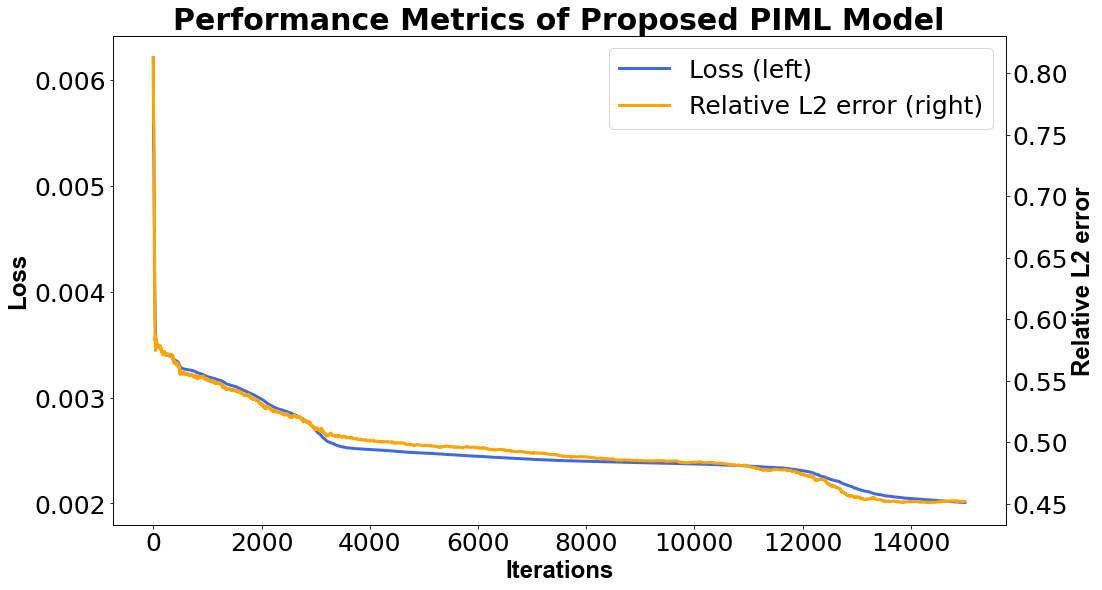

In [17]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax2 = ax1.twinx()
line1 = ax1.plot(loss_record, linewidth = '3', color = "royalblue", label='Loss (left)')
line2 = ax2.plot(l2_record, linewidth = '3', color = "orange", label='Relative L2 error (right)')
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')
plt.title("Performance Metrics of Proposed PIML Model", fontsize=30, fontweight="bold")
ax1.set_xlabel("Iterations", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Loss", fontsize=24, fontname = 'Arial', fontweight="bold")
ax2.set_ylabel("Relative L2 error", fontsize=24, fontname = 'Arial', fontweight="bold")
fig.set_size_inches(16, 9)

# 전체 그리드 비교

In [18]:
u_pred = PINN.evaluate(X_u_grid)
u_pred = np.reshape(u_pred,usol.shape,order='F')

y_test = usol
y_pred = u_pred

error_vec = np.linalg.norm((y_test-y_pred),2)/np.linalg.norm(y_test,2)

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

MAE =  0.019055963291346775
MSE =  0.002458278557959797
RMSE =  0.04958103022285637
L2 relative error = 0.4745444957686607
--------------------------------------------------


Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

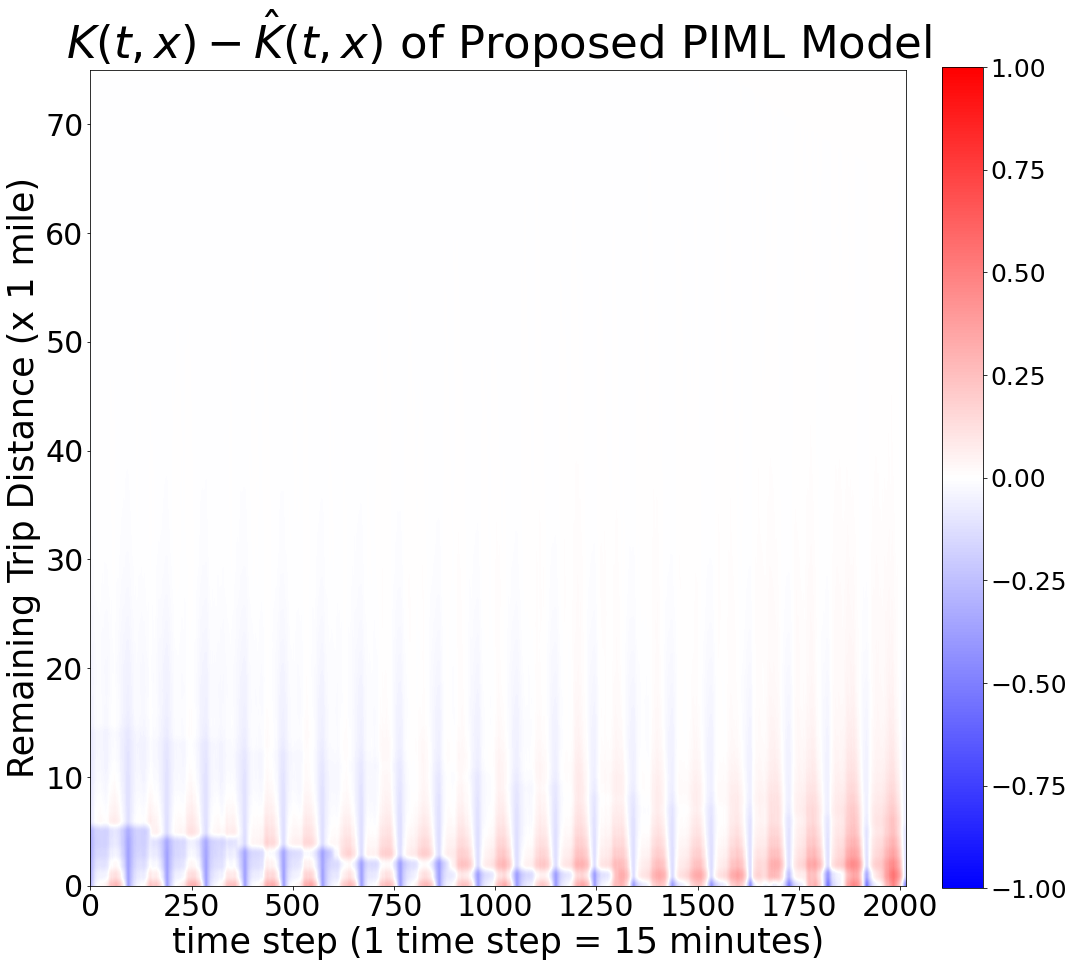

In [19]:
K_array = np.array(u_pred)
K_array = (usol - K_array)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'bwr')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(-1, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$K(t,x)- \hat{K}(t,x)$' ' of Proposed PIML Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

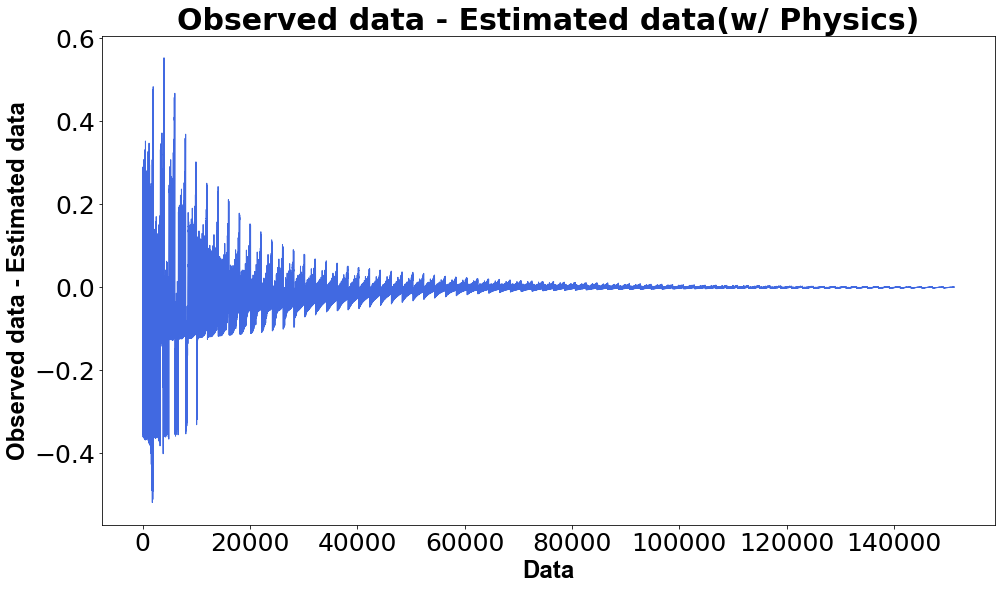

In [20]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax1.plot(K_array.flatten(), linewidth = '1', color = "royalblue", label='Loss (left)')
plt.title("Observed data - Estimated data(w/ Physics)", fontsize=30, fontweight="bold")
ax1.set_xlabel("Data", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Observed data - Estimated data", fontsize=24, fontname = 'Arial', fontweight="bold")

fig.set_size_inches(16, 9)

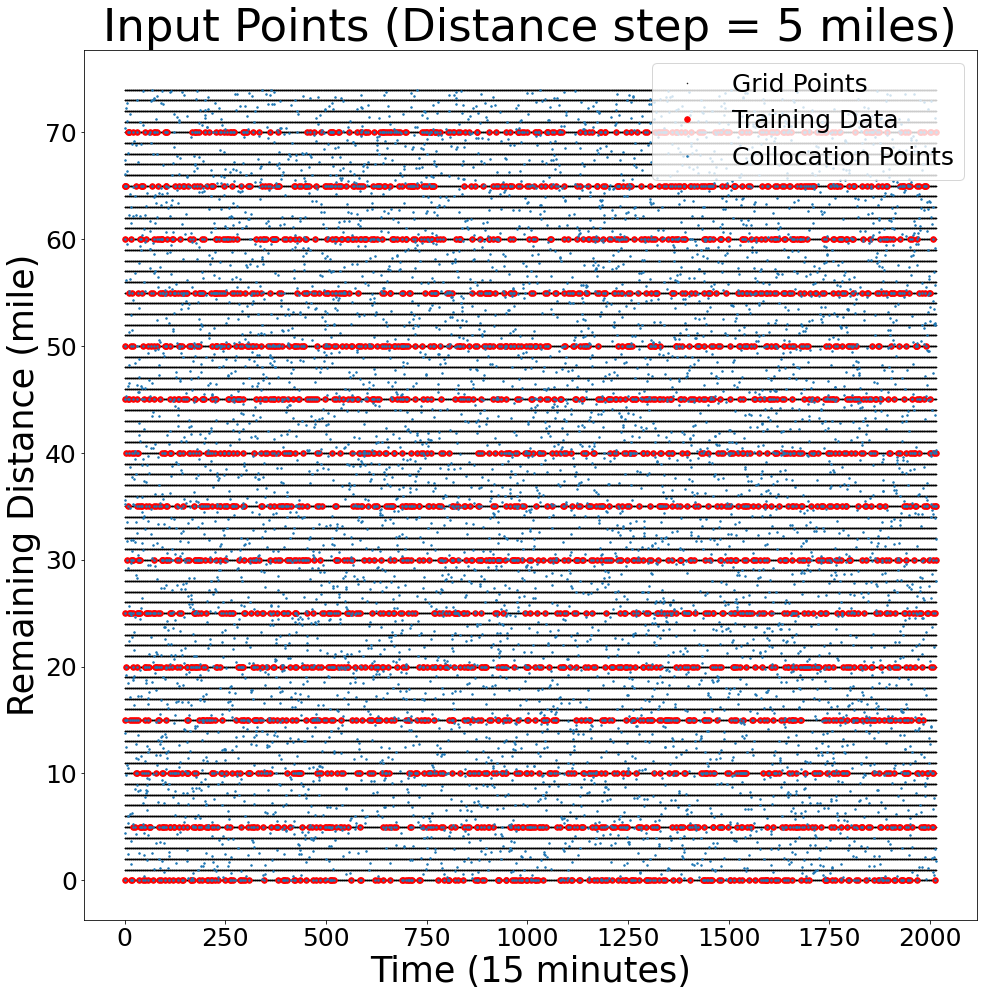

In [21]:
fig,ax = plt.subplots(figsize=(16, 16))
plt.plot(X_u_grid[:,1]*multiplier_time, X_u_grid[:,0]*multiplier_dist, 'o', color = 'black', markersize = 0.5, label = 'Grid Points')
plt.plot(X_u_train[:,1]*multiplier_time, X_u_train[:,0]*multiplier_dist, 'o', color = 'red', markersize = 5.5, label = 'Training Data')
plt.plot(X_f_train[:,1]*multiplier_time, X_f_train[:,0]*multiplier_dist, 'o', markersize = 1.5, label = 'Collocation Points')

plt.rcParams['font.size'] = '25'
plt.xlabel('Time (15 minutes)', fontsize=35)
plt.ylabel('Remaining Distance (mile)', fontsize=35)
plt.title('Input Points (Distance step = 5 miles)', fontsize=45)
plt.legend(loc='upper right')
plt.show()

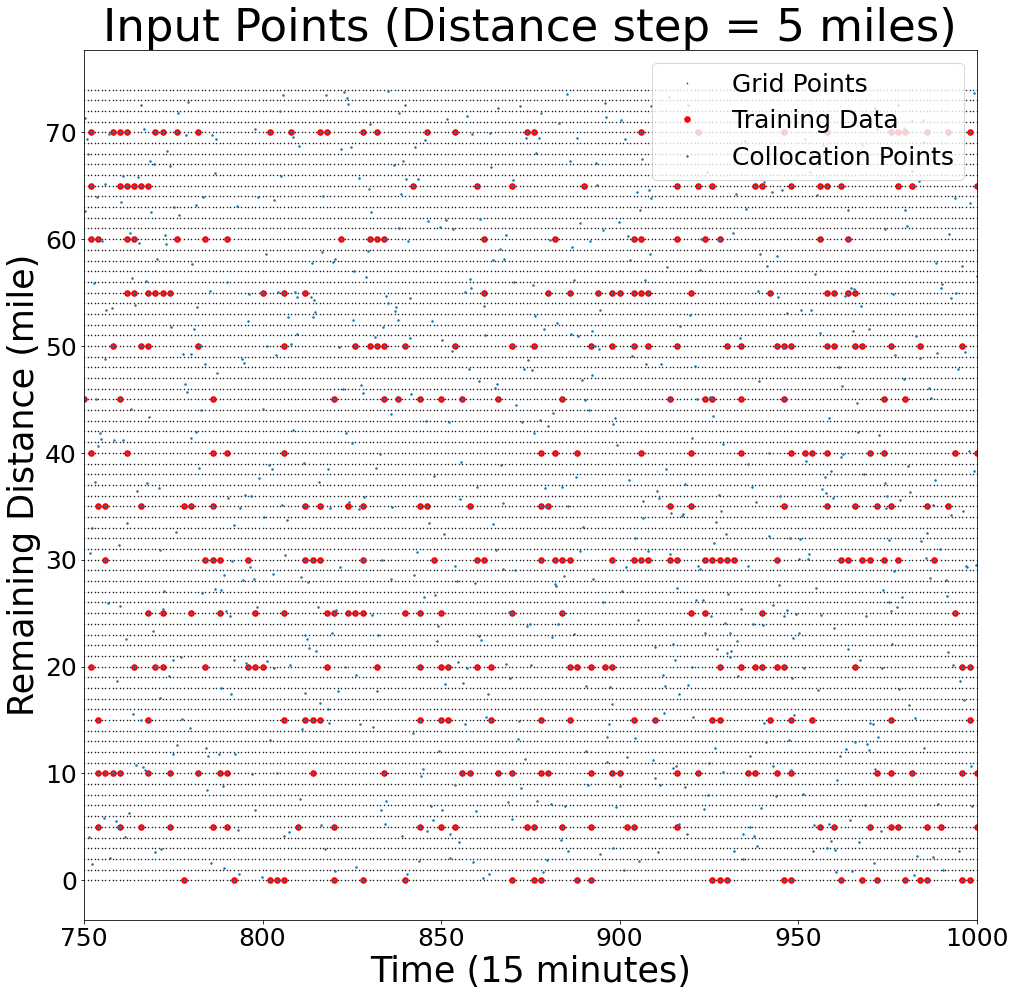

In [26]:
fig,ax = plt.subplots(figsize=(16, 16))
plt.plot(X_u_grid[:,1]*multiplier_time, X_u_grid[:,0]*multiplier_dist, 'o', color = 'black', markersize = 0.5, label = 'Grid Points')
plt.plot(X_u_train[:,1]*multiplier_time, X_u_train[:,0]*multiplier_dist, 'o', color = 'red', markersize = 5.5, label = 'Training Data')
plt.plot(X_f_train[:,1]*multiplier_time, X_f_train[:,0]*multiplier_dist, 'o', markersize = 1.5, label = 'Collocation Points')

plt.rcParams['font.size'] = '25'
plt.xlabel('Time (15 minutes)', fontsize=35)
plt.ylabel('Remaining Distance (mile)', fontsize=35)
plt.xlim((750,1000))
plt.title('Input Points (Distance step = 5 miles)', fontsize=45)
plt.legend(loc='upper right')
plt.show()